# Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, f1_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import shap
from tensorflow.keras import layers, callbacks, optimizers
import keras_tuner as kt
from keras_tuner import HyperModel, Hyperband
from scipy.stats import kendalltau

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
import random
from tensorflow.keras import backend as K


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
data = pd.read_csv("ESS11-set.csv")
data.head()

name  essround  edition    proddate   idno cntry   dweight   pweight  \
0  ESS11e01        11      1.0  20.06.2024  50014    AT  1.185115  0.330915   
1  ESS11e01        11      1.0  20.06.2024  50030    AT  0.609898  0.330915   
2  ESS11e01        11      1.0  20.06.2024  50057    AT  1.392330  0.330915   
3  ESS11e01        11      1.0  20.06.2024  50106    AT  0.556061  0.330915   
4  ESS11e01        11      1.0  20.06.2024  50145    AT  0.722795  0.330915   

   lrscale  nobingnd  ...  wprtbym  wbrgwrm  gndr  agea  maritalb  eisced  \
0        5         1  ...        2        2     1    65         1       3   
1        0         2  ...        2        3     2    21         6       5   
2        3         2  ...        4        2     2    53         1       6   
3        5         2  ...        3        2     2    78         4       5   
4        2         2  ...        3        3     1    64         1       3   

   hinctnta      prob  stratum  psu  
0         6  0.000579      107  317  
1         1  0.001124       69  128  
2         5  0.000493       18  418  
3         2  0.001233      101  295  
4        77  0.000949      115  344  

[5 rows x 45 columns]

In [3]:
# drop default and repeated features
to_drop = ['name', 'essround', 'edition', 'proddate', 'idno', 'dweight', 'pweight', 'prob', 'stratum', 'psu', 'nobingnd']
data = data.drop(to_drop, axis=1)
print(data.shape)
data.describe().T

(22190, 34)


count       mean        std   min   25%   50%   75%    max
lrscale   22190.0  13.401172  24.715767   0.0   4.0   5.0   7.0   99.0
likrisk   22190.0   2.622488   1.808819   0.0   1.0   3.0   4.0    9.0
liklead   22190.0   3.105318   1.819505   0.0   2.0   3.0   4.0    9.0
sothnds   22190.0   4.452952   1.291810   0.0   4.0   5.0   5.0    9.0
actcomp   22190.0   4.770708   1.110371   0.0   4.0   5.0   6.0    9.0
mascfel   22190.0   2.876341   2.520587   0.0   0.0   3.0   5.0    9.0
femifel   22190.0   3.105047   2.565700   0.0   0.0   4.0   6.0    9.0
impbemw   22190.0   6.778909  13.353950   0.0   4.0   5.0   6.0   99.0
trmedmw   22190.0   2.955250   0.559682   1.0   3.0   3.0   3.0    9.0
trwrkmw   22190.0   2.881433   0.747585   1.0   3.0   3.0   3.0    9.0
trplcmw   22190.0   3.102298   0.645650   1.0   3.0   3.0   3.0    9.0
trmdcnt   22190.0   2.944570   1.233660   1.0   3.0   3.0   3.0    9.0
trwkcnt   22190.0   2.260388   1.772437   1.0   1.0   1.0   3.0    9.0
trplcnt   22190.0   3.282470   1.668037   1.0   3.0   3.0   3.0    9.0
eqwrkbg   22190.0   4.559126   1.592293   0.0   3.0   5.0   6.0    9.0
eqpolbg   22190.0   4.755025   1.550396   0.0   4.0   5.0   6.0    9.0
eqmgmbg   22190.0   4.805002   1.471609   0.0   4.0   5.0   6.0    9.0
eqpaybg   22190.0   5.182875   1.293509   0.0   4.0   6.0   6.0    9.0
eqparep   22190.0   2.885895   1.582828   1.0   2.0   3.0   4.0    9.0
eqparlv   22190.0   2.906985   1.609523   1.0   2.0   3.0   4.0    9.0
freinsw   22190.0   2.375935   1.441546   1.0   1.0   2.0   3.0    9.0
fineqpy   22190.0   2.326769   1.455014   1.0   1.0   2.0   3.0    9.0
wsekpwr   22190.0   3.248445   1.526212   1.0   2.0   3.0   4.0    9.0
weasoff   22190.0   3.364398   1.176510   1.0   3.0   3.0   4.0    9.0
wlespdm   22190.0   3.730689   1.394099   1.0   3.0   4.0   4.0    9.0
wexashr   22190.0   3.218612   1.890610   1.0   2.0   3.0   3.0    9.0
wprtbym   22190.0   2.638531   1.263686   1.0   2.0   2.0   3.0    9.0
wbrgwrm   22190.0   2.844479   1.242006   1.0   2.0   3.0   3.0    9.0
gndr      22190.0   1.537134   0.498630   1.0   1.0   2.0   2.0    2.0
agea      22190.0  58.324425  80.070696  15.0  37.0  53.0  67.0  999.0
maritalb  22190.0   3.729518   6.972789   1.0   1.0   2.0   6.0   99.0
eisced    22190.0   4.600721   5.834430   1.0   3.0   4.0   6.0   99.0
hinctnta  22190.0  18.996755  28.954341   1.0   4.0   7.0  10.0   99.0

# Exploratory Data Analysis

## Missing values

In [4]:
# handling invalid response in targets (7 noidea, 8 refusal, 9 missing)
targets = ['eqwrkbg', 'eqpolbg', 'eqmgmbg', 'eqpaybg']
data_delete = data[~(data[targets]>6).any(axis=1)]
print('Shape:', data_delete.shape)
print("Invalid proportion:", round((data.shape[0]-data_delete.shape[0])/data.shape[0]*100, 2),"%")


Shape: (20261, 34)
Invalid proportion: 8.69 %


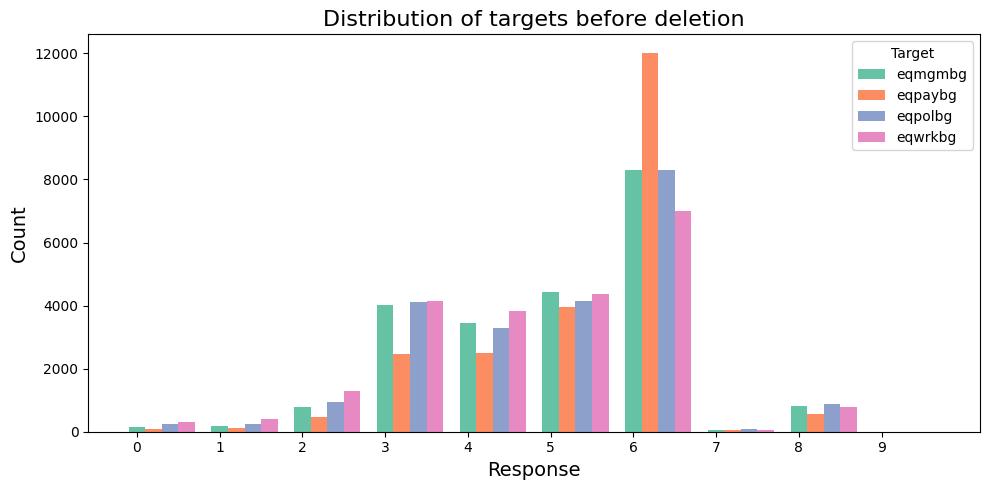

In [5]:
# turn format wide to long
melted_data = pd.melt(data, value_vars=targets, var_name='Target', value_name='Response')
counts = melted_data.groupby(['Target', 'Response']).size().reset_index(name='Count')

# plot
plt.figure(figsize=(10, 5))

for i, feature in enumerate(counts['Target'].unique()):
    feature_data = counts[counts['Target'] == feature]
    plt.bar(feature_data['Response'] + i*0.2, feature_data['Count'], width=0.2, label=feature, color=sns.color_palette("Set2")[i])


plt.xticks(ticks=range(10), labels=range(10))
plt.title("Distribution of targets before deletion", fontsize=16)
plt.xlabel("Response", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Target")

plt.tight_layout()
plt.show()

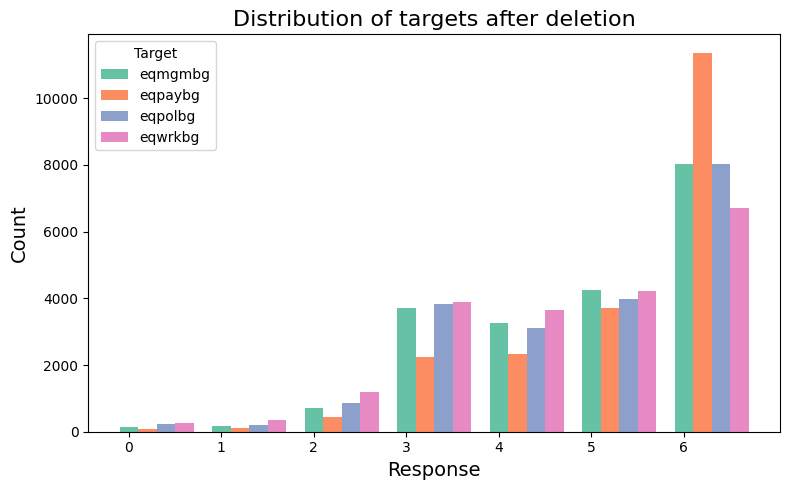

In [6]:
# after deletion
# turn format wide to long
melted_data_delete = pd.melt(data_delete, value_vars=targets, var_name='Target', value_name='Response')
counts_delete = melted_data_delete.groupby(['Target', 'Response']).size().reset_index(name='Count')

# plot
plt.figure(figsize=(8, 5))

for i, feature in enumerate(counts_delete['Target'].unique()):
    feature_data = counts_delete[counts_delete['Target'] == feature]
    plt.bar(feature_data['Response'] + i*0.2, feature_data['Count'], width=0.2, label=feature, color=sns.color_palette("Set2")[i])


plt.xticks(ticks=range(7), labels=range(7))
plt.title("Distribution of targets after deletion", fontsize=16)
plt.xlabel("Response", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Target")

plt.tight_layout()
plt.show()

In [7]:
delete = data_delete.copy()
missing9 = ['likrisk', 'liklead', 'sothnds', 'actcomp', 'mascfel', 'femifel', 'trmedmw', 'trwrkmw', 'trplcmw', 'trmdcnt', 'trwkcnt', 'trplcnt', 'eqparep', 'eqparlv', 'freinsw', 'fineqpy', 'wsekpwr', 'weasoff', 'wlespdm', 'wexashr', 'wprtbym', 'wbrgwrm']
missing99 = ['lrscale', 'impbemw', 'maritalb', 'eisced', 'hinctnta']
delete[missing9] = delete[missing9].replace(9, np.nan)
delete[missing99] = delete[missing99].replace(99, np.nan)
delete['agea'] = data_delete['agea'].replace(999, np.nan)

### Visualisation

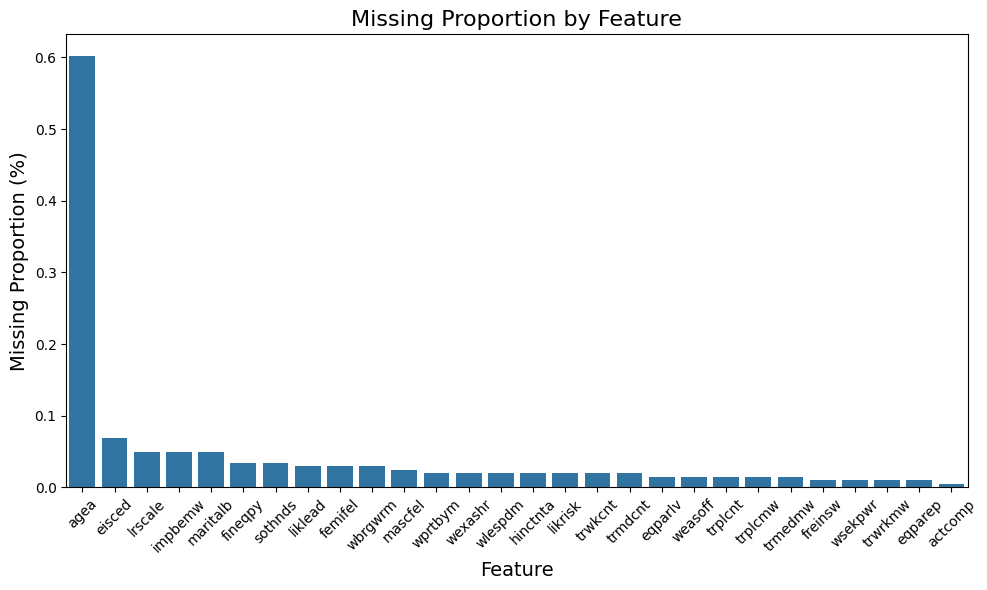

In [8]:
# display null porportion

missing_data = delete.isnull().mean()[delete.isnull().mean()>0].sort_values(ascending=False) * 100

plt.figure(figsize=(10, 6))

sns.barplot(x=missing_data.index, y=missing_data.values)

plt.title('Missing Proportion by Feature', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Missing Proportion (%)', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<Axes: >

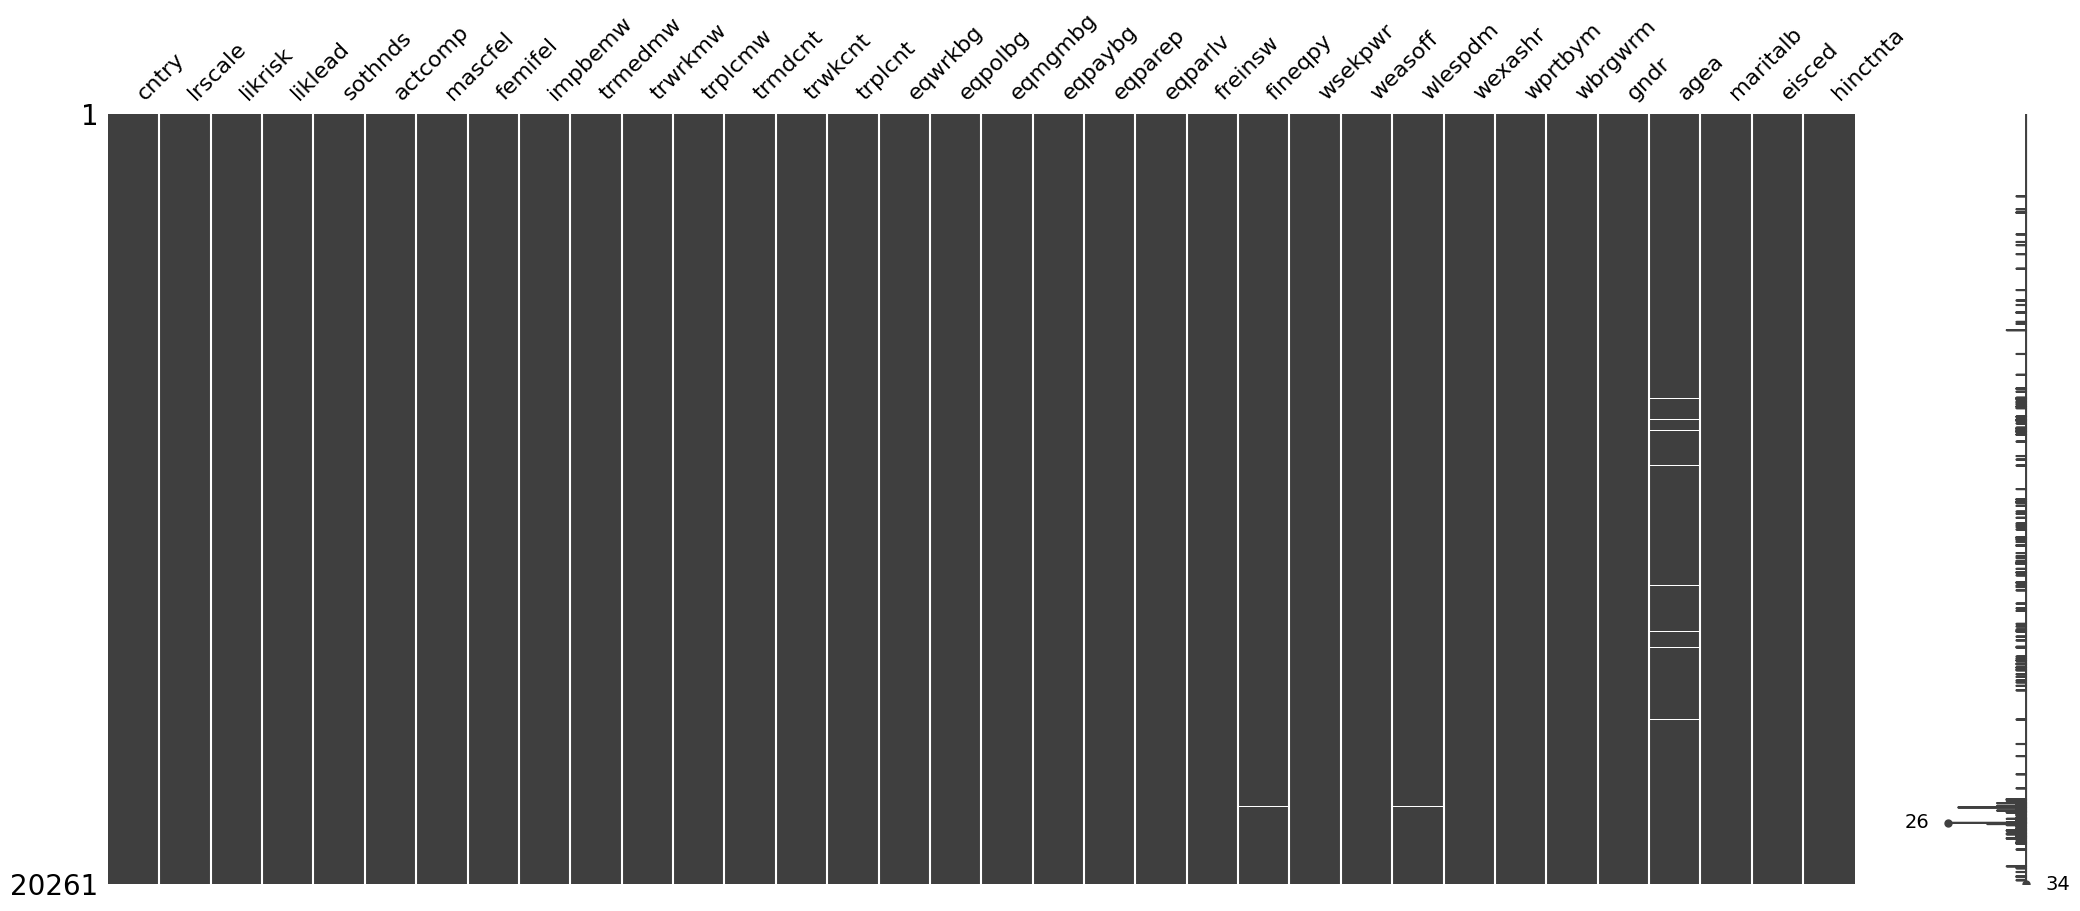

In [9]:
missing_features = missing_data.index.tolist()
msno.matrix(delete)

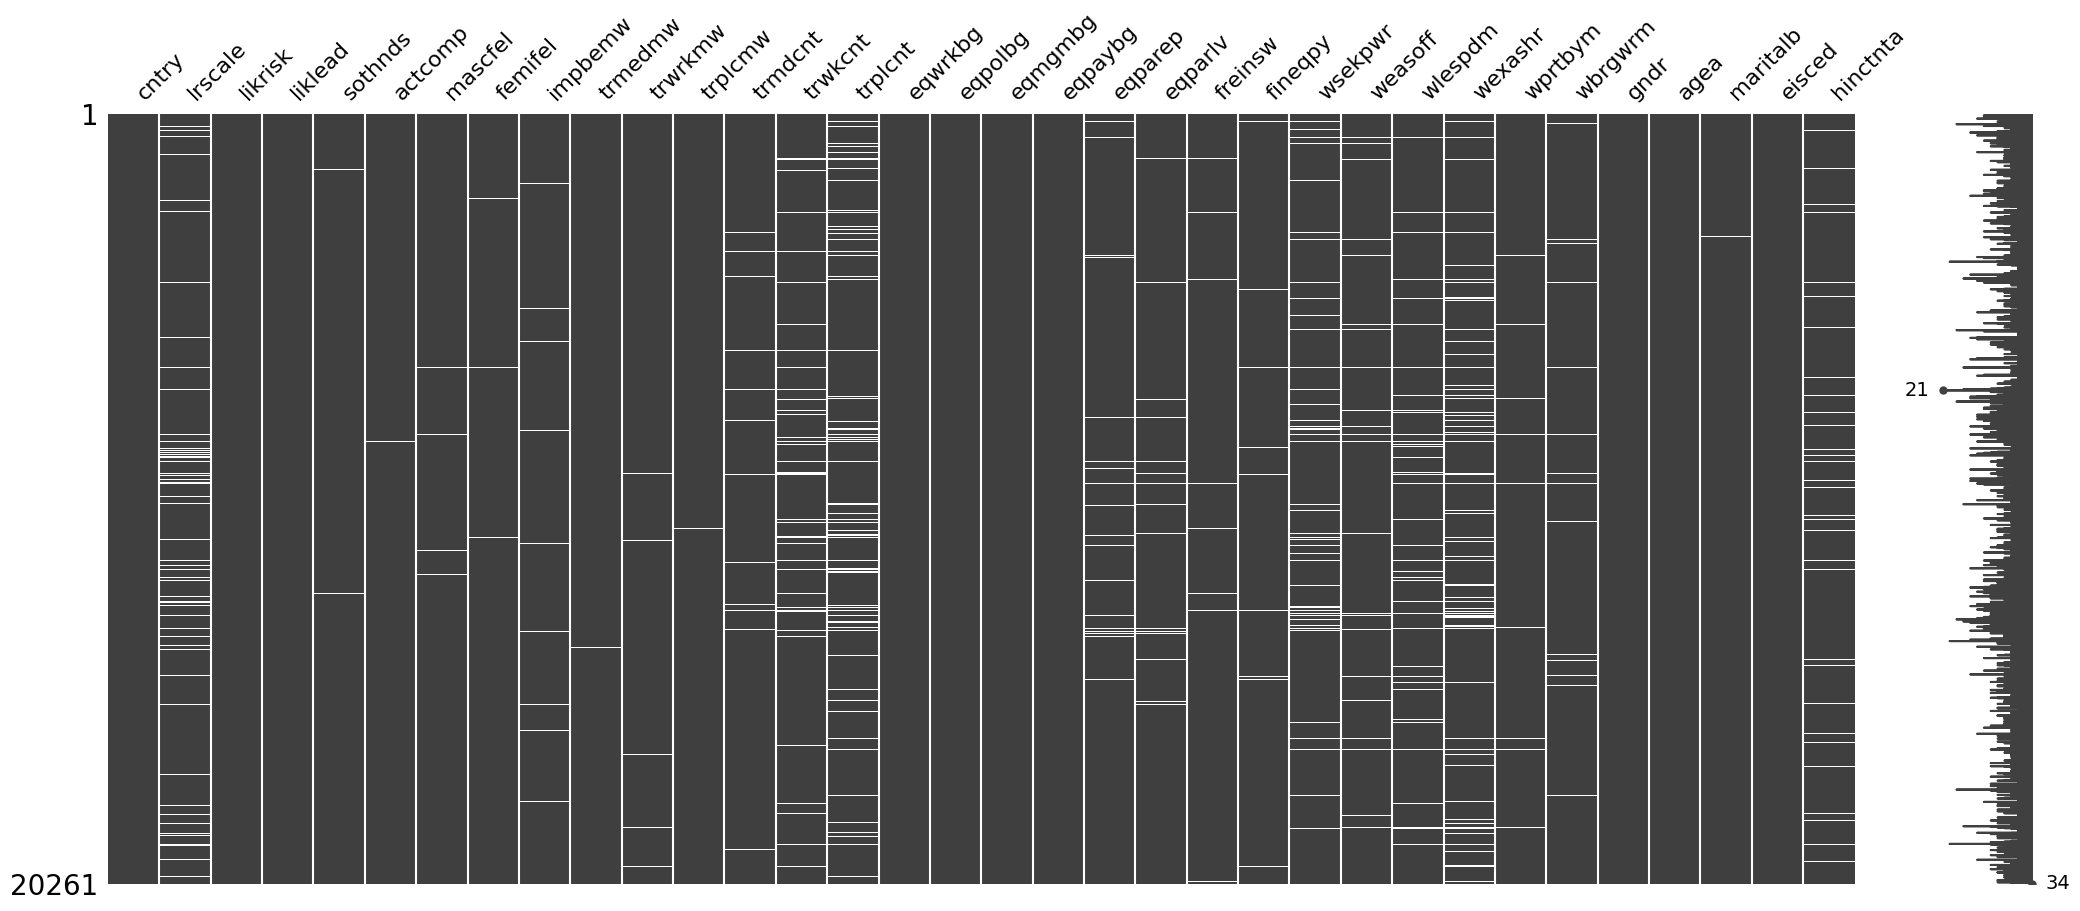

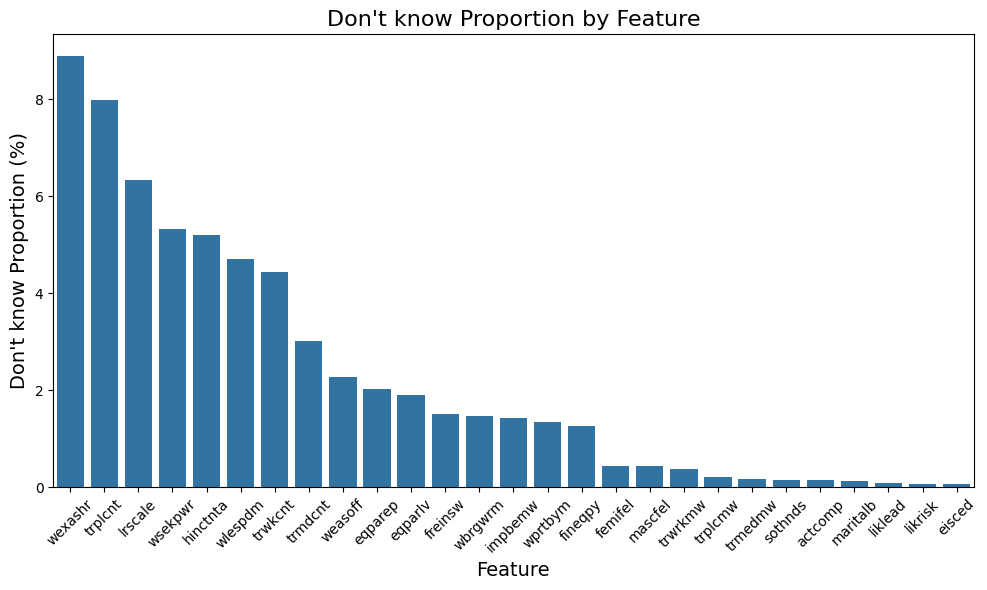

In [10]:
noidea=data_delete.copy()
noidea[missing9] = noidea[missing9].replace(8, np.nan)
noidea[missing99] = noidea[missing99].replace(88, np.nan)
msno.matrix(noidea)

# display noidea porportion
noidea_data = noidea.isnull().mean()[noidea.isnull().mean()>0].sort_values(ascending=False) * 100
noidea_features = noidea_data.index.tolist()

plt.figure(figsize=(10, 6))

sns.barplot(x=noidea_data.index, y=noidea_data.values)

plt.title('Don\'t know Proportion by Feature', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Don\'t know Proportion (%)', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

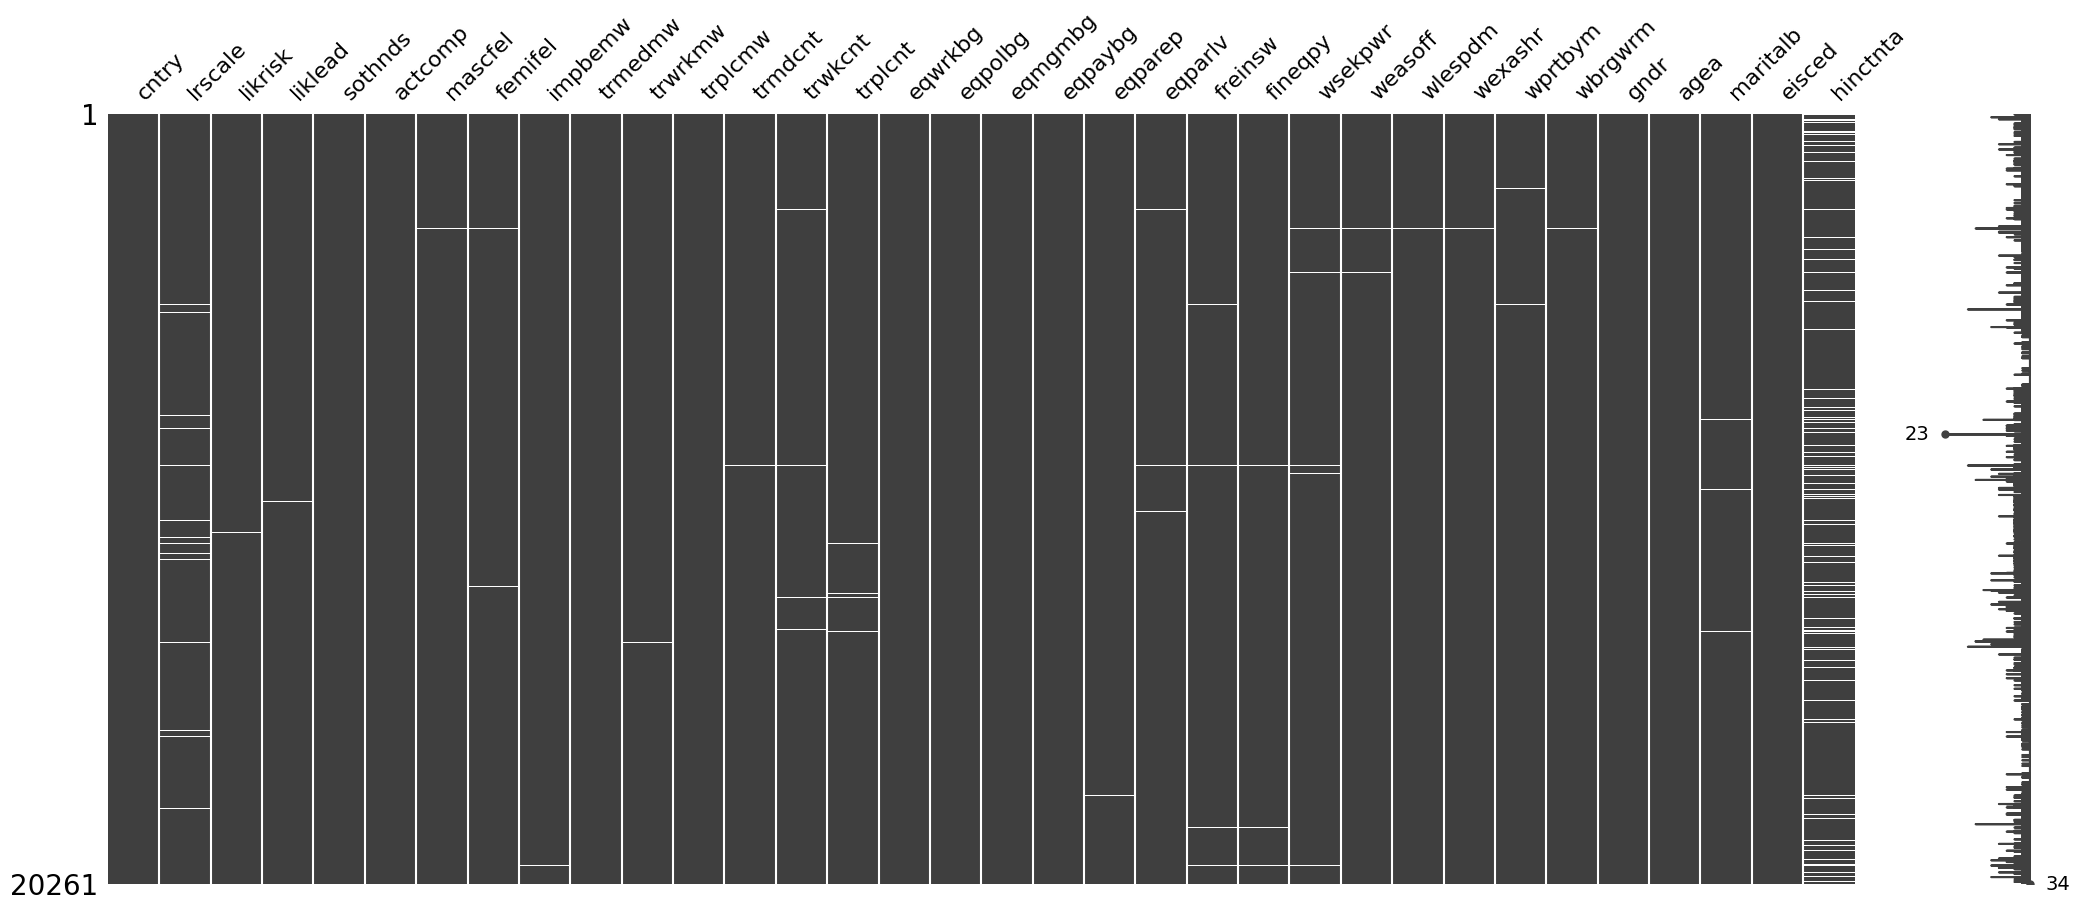

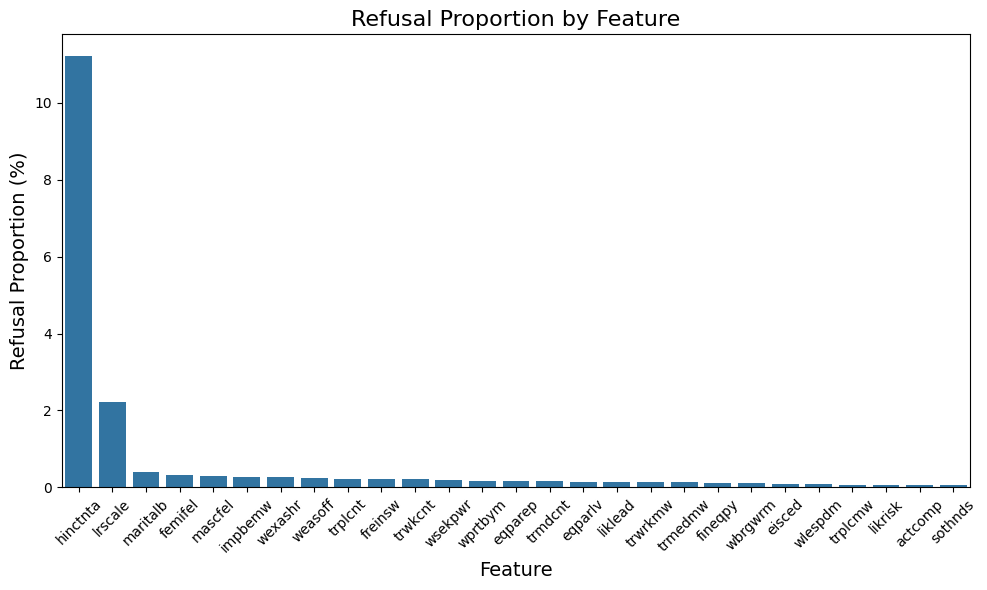

In [11]:
refusal=data_delete.copy()
refusal[missing9] = refusal[missing9].replace(7, np.nan)
refusal[missing99] = refusal[missing99].replace(77, np.nan)
msno.matrix(refusal)

# display refusal porportion
refusal_data = refusal.isnull().mean()[refusal.isnull().mean()>0].sort_values(ascending=False) * 100
refusal_features = refusal_data.index.tolist()

plt.figure(figsize=(10, 6))

sns.barplot(x=refusal_data.index, y=refusal_data.values)

plt.title('Refusal Proportion by Feature', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Refusal Proportion (%)', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [12]:
refusal_encode = refusal_data[refusal_data>2].index.tolist()
noidea_encode = noidea_data[noidea_data>2].index.tolist()


## Feature distribution

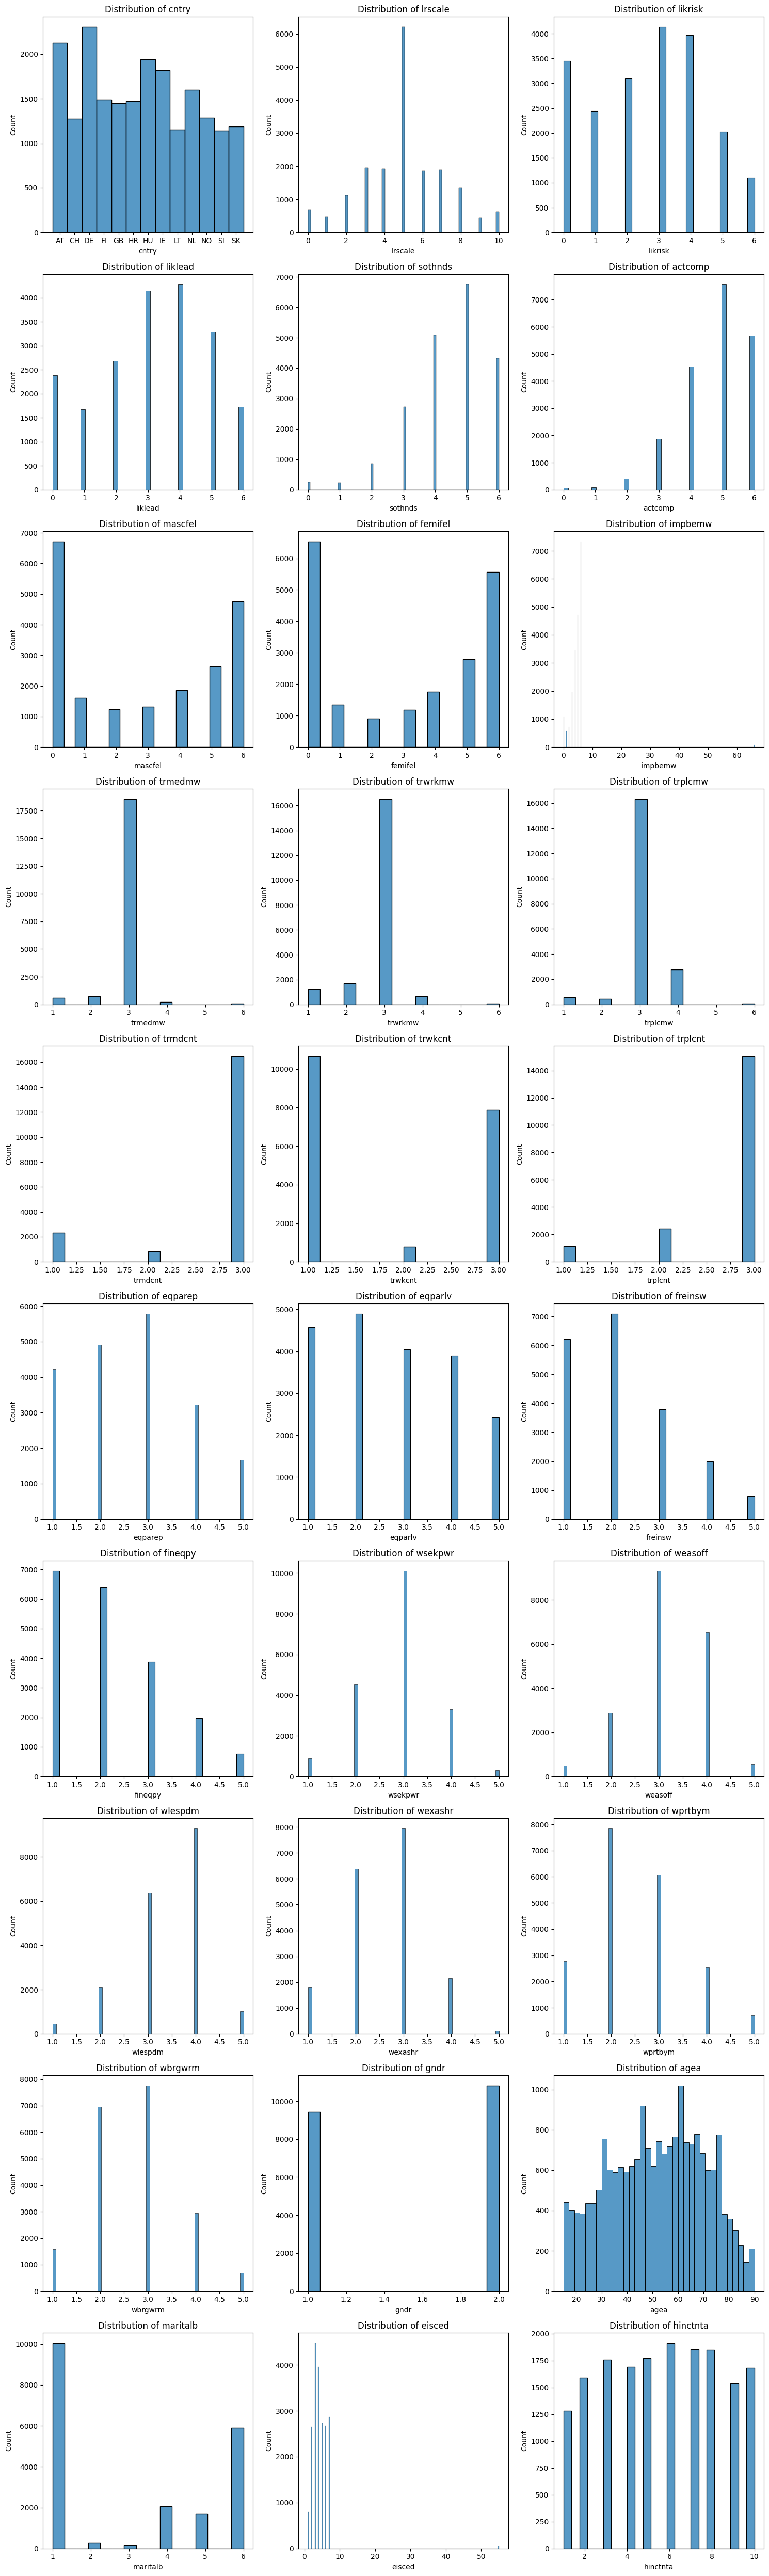

In [13]:
copy = data_delete.copy()
copy = copy.drop(targets, axis=1)
copy[missing9] = copy[missing9].replace({7: np.nan, 8: np.nan, 9: np.nan})
copy[missing99] = copy[missing99].replace({77: np.nan, 88: np.nan, 99: np.nan})
copy['agea'] = copy['agea'].replace(999, np.nan)
# check feature distribution
n_features = copy.shape[1]  
n_rows = (n_features + 2) // 3 
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes = axes.flatten()

for i, feature in enumerate(copy.columns):
    sns.histplot(copy[feature], ax=axes[i])  
    axes[i].set_title(f'Distribution of {feature}')  

# remove additional subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off') 

plt.tight_layout()
plt.show()

In [14]:
copy.describe().T


count       mean        std   min   25%   50%   75%   max
lrscale   18520.0   5.001296   2.187718   0.0   4.0   5.0   6.0  10.0
likrisk   20230.0   2.653485   1.772728   0.0   1.0   3.0   4.0   6.0
liklead   20205.0   3.142242   1.772349   0.0   2.0   3.0   4.0   6.0
sothnds   20212.0   4.457599   1.257989   0.0   4.0   5.0   5.0   6.0
actcomp   20218.0   4.777921   1.074300   0.0   4.0   5.0   6.0   6.0
mascfel   20106.0   2.843330   2.471388   0.0   0.0   3.0   5.0   6.0
femifel   20101.0   3.041640   2.524902   0.0   0.0   4.0   6.0   6.0
impbemw   19906.0   4.725560   4.081029   0.0   4.0   5.0   6.0  66.0
trmedmw   20196.0   2.927560   0.439396   1.0   3.0   3.0   3.0   6.0
trwrkmw   20155.0   2.836269   0.605853   1.0   3.0   3.0   3.0   6.0
trplcmw   20200.0   3.072178   0.545597   1.0   3.0   3.0   3.0   6.0
trmdcnt   19615.0   2.722253   0.660733   1.0   3.0   3.0   3.0   3.0
trwkcnt   19314.0   1.855752   0.968732   1.0   1.0   1.0   3.0   3.0
trplcnt   18596.0   2.747741   0.556835   1.0   3.0   3.0   3.0   3.0
eqparep   19815.0   2.655917   1.217492   1.0   2.0   3.0   3.0   5.0
eqparlv   19841.0   2.734136   1.336231   1.0   2.0   3.0   4.0   5.0
freinsw   19909.0   2.199658   1.107025   1.0   1.0   2.0   3.0   5.0
fineqpy   19971.0   2.159281   1.121652   1.0   1.0   2.0   3.0   5.0
wsekpwr   19142.0   2.874569   0.803181   1.0   2.0   3.0   3.0   5.0
weasoff   19749.0   3.190541   0.805088   1.0   3.0   3.0   4.0   5.0
wlespdm   19285.0   3.431112   0.844646   1.0   3.0   4.0   4.0   5.0
wexashr   18400.0   2.589728   0.842891   1.0   2.0   3.0   3.0   5.0
wprtbym   19954.0   2.525910   0.997393   1.0   2.0   2.0   3.0   5.0
wbrgwrm   19935.0   2.707198   0.931375   1.0   2.0   3.0   3.0   5.0
gndr      20261.0   1.533932   0.498860   1.0   1.0   2.0   2.0   2.0
agea      20139.0  51.652664  18.599641  15.0  37.0  53.0  67.0  90.0
maritalb  20144.0   3.138354   2.250634   1.0   1.0   2.0   6.0   6.0
eisced    20212.0   4.364833   3.180342   1.0   3.0   4.0   6.0  55.0
hinctnta  16931.0   5.627961   2.766152   1.0   3.0   6.0   8.0  10.0

# Preprocessing

In [15]:
# data split
y = delete[targets]
X = delete.drop(targets, axis=1)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)
print(X_train.shape, X_val.shape, X_test.shape)

(20261, 30) (20261, 4)
(16208, 30) (2026, 30) (2027, 30)


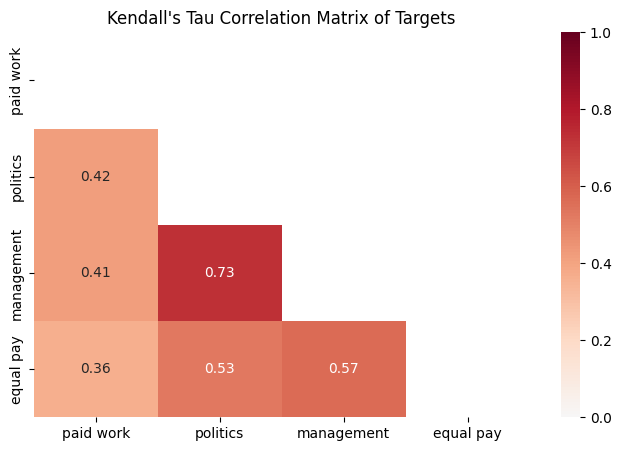

In [16]:
# target correlation
df = pd.DataFrame({'paid work': y.iloc[:,0], 'politics':  y.iloc[:,1], 
                   'management':  y.iloc[:,2], 'equal pay':  y.iloc[:,3]})

kendall_corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Kendall's Tau correlation
for col1 in df.columns:
    for col2 in df.columns:
        tau, _ = kendalltau(df[col1], df[col2])
        kendall_corr_matrix.loc[col1, col2] = tau
kendall_corr_matrix = kendall_corr_matrix.astype(float)

# mask the upper triangle, excluding the diagonal
mask = np.triu(np.ones_like(kendall_corr_matrix, dtype=bool))
np.fill_diagonal(kendall_corr_matrix.values, np.nan)

plt.figure(figsize=(8, 5))
sns.heatmap(kendall_corr_matrix, annot=True, cmap='RdBu_r', vmin=0, vmax=1, center=0, mask=mask)
plt.xticks(rotation=0)

plt.title("Kendall's Tau Correlation Matrix of Targets")
plt.show()

## Set indicator variables

In [17]:
ordinal_feature = ['lrscale', 'likrisk', 'liklead', 'sothnds', 'actcomp', 'mascfel', 'femifel', 'impbemw', 'eqparep', 'eqparlv', 'freinsw', 'fineqpy', 'wsekpwr', 'weasoff', 'wlespdm', 'wexashr', 'wprtbym', 'wbrgwrm', 'eisced', 'hinctnta']
categorical_feature = ['cntry', 'trmedmw', 'trwrkmw', 'trplcmw', 'trmdcnt', 'trwkcnt', 'trplcnt', 'gndr', 'maritalb']
X_train_enc = X_train.copy()
X_train_enc.shape

(16208, 30)

In [18]:
# separate non-ordinal to new feature: train
def encode_non_ordinal(df, ordinals, refusal=7, noidea=8):
    for feature in ordinals:
        if feature in missing9:
            refusal, noidea = 7, 8
        elif feature in missing99:
            refusal, noidea = 77, 88
        
        if feature in noidea_data.index:
            if feature in noidea_encode:
                df[f'{feature}_noidea'] = (df[feature] == noidea).astype(int)
            df[feature] = df[feature].replace(noidea, np.nan)

        if feature in refusal_data.index:
            if feature in refusal_encode:
                df[f'{feature}_refusal'] = (df[feature] == refusal).astype(int)
            df[feature] = df[feature].replace(refusal, np.nan)

        else:
            pass
        # df[feature] = df[feature].replace({77: np.nan, 88: np.nan})

encode_non_ordinal(X_train_enc, ordinal_feature)
X_train_enc.shape


(16208, 39)

In [19]:
# separate non-ordinal to new feature: train
def encode_categorical_missing(df, categoricals, refusal=7, noidea=8):
    for feature in categoricals:
        if feature in missing9:
            refusal, noidea = 7, 8
        elif feature in missing99:
            refusal, noidea = 77, 88
        
        if feature in noidea_data.index:
            if feature in noidea_encode:
                df[f'{feature}_noidea'] = (df[feature] == noidea).astype(int)
            df[feature] = df[feature].replace(noidea, np.nan)

        if feature in refusal_data.index:
            if feature in refusal_encode:
                df[f'{feature}_refusal'] = (df[feature] == refusal).astype(int)
            df[feature] = df[feature].replace(refusal, np.nan)

        else:
            pass
        # df[feature] = df[feature].replace({77: np.nan, 88: np.nan})

encode_categorical_missing(X_train_enc, categorical_feature)
X_train_enc.shape


(16208, 42)

In [20]:
X_train_enc[ordinal_feature].describe().T

count      mean       std  min  25%  50%  75%   max
lrscale   14809.0  5.001080  2.187244  0.0  4.0  5.0  6.0  10.0
likrisk   16180.0  2.648640  1.775793  0.0  1.0  3.0  4.0   6.0
liklead   16163.0  3.148178  1.776876  0.0  2.0  3.0  5.0   6.0
sothnds   16166.0  4.462143  1.254410  0.0  4.0  5.0  5.0   6.0
actcomp   16172.0  4.783886  1.077530  0.0  4.0  5.0  6.0   6.0
mascfel   16078.0  2.823548  2.472294  0.0  0.0  3.0  5.0   6.0
femifel   16079.0  3.065551  2.523911  0.0  0.0  4.0  6.0   6.0
impbemw   15922.0  4.733137  4.126335  0.0  4.0  5.0  6.0  66.0
eqparep   15847.0  2.649271  1.218589  1.0  2.0  3.0  3.0   5.0
eqparlv   15860.0  2.735372  1.338539  1.0  2.0  3.0  4.0   5.0
freinsw   15934.0  2.201895  1.102752  1.0  1.0  2.0  3.0   5.0
fineqpy   15977.0  2.158916  1.123661  1.0  1.0  2.0  3.0   5.0
wsekpwr   15315.0  2.877440  0.801223  1.0  2.0  3.0  3.0   5.0
weasoff   15784.0  3.193170  0.803671  1.0  3.0  3.0  4.0   5.0
wlespdm   15418.0  3.429433  0.843525  1.0  3.0  4.0  4.0   5.0
wexashr   14705.0  2.592860  0.846545  1.0  2.0  3.0  3.0   5.0
wprtbym   15963.0  2.523586  0.996293  1.0  2.0  2.0  3.0   5.0
wbrgwrm   15953.0  2.702062  0.932021  1.0  2.0  3.0  3.0   5.0
eisced    16164.0  4.369216  3.260348  1.0  3.0  4.0  6.0  55.0
hinctnta  13582.0  5.632676  2.765354  1.0  3.0  6.0  8.0  10.0

In [21]:
def special_encode(df, features):
    for feature in features:
        if feature == 'impbemw':
            # df[f'{feature}_not_applicable'] = (df[feature] == 66).astype(int) # not set due to low proportion
            df[feature] = df[feature].replace(66, np.nan)

        if feature == 'eisced':
            # df[f'{feature}_other'] = (df[feature] == 55).astype(int)
            df[feature] = df[feature].replace(55, np.nan)

special_encode(X_train_enc, ['impbemw', 'eisced'])
X_train_enc.shape

(16208, 42)

In [22]:
X_train_enc[ordinal_feature].describe().T

count      mean       std  min  25%  50%  75%   max
lrscale   14809.0  5.001080  2.187244  0.0  4.0  5.0  6.0  10.0
likrisk   16180.0  2.648640  1.775793  0.0  1.0  3.0  4.0   6.0
liklead   16163.0  3.148178  1.776876  0.0  2.0  3.0  5.0   6.0
sothnds   16166.0  4.462143  1.254410  0.0  4.0  5.0  5.0   6.0
actcomp   16172.0  4.783886  1.077530  0.0  4.0  5.0  6.0   6.0
mascfel   16078.0  2.823548  2.472294  0.0  0.0  3.0  5.0   6.0
femifel   16079.0  3.065551  2.523911  0.0  0.0  4.0  6.0   6.0
impbemw   15862.0  4.501387  1.684598  0.0  4.0  5.0  6.0   6.0
eqparep   15847.0  2.649271  1.218589  1.0  2.0  3.0  3.0   5.0
eqparlv   15860.0  2.735372  1.338539  1.0  2.0  3.0  4.0   5.0
freinsw   15934.0  2.201895  1.102752  1.0  1.0  2.0  3.0   5.0
fineqpy   15977.0  2.158916  1.123661  1.0  1.0  2.0  3.0   5.0
wsekpwr   15315.0  2.877440  0.801223  1.0  2.0  3.0  3.0   5.0
weasoff   15784.0  3.193170  0.803671  1.0  3.0  3.0  4.0   5.0
wlespdm   15418.0  3.429433  0.843525  1.0  3.0  4.0  4.0   5.0
wexashr   14705.0  2.592860  0.846545  1.0  2.0  3.0  3.0   5.0
wprtbym   15963.0  2.523586  0.996293  1.0  2.0  2.0  3.0   5.0
wbrgwrm   15953.0  2.702062  0.932021  1.0  2.0  3.0  3.0   5.0
eisced    16116.0  4.218416  1.732985  1.0  3.0  4.0  6.0   7.0
hinctnta  13582.0  5.632676  2.765354  1.0  3.0  6.0  8.0  10.0

In [23]:
# separate non-ordinal to new feature: val and test
X_val_enc = X_val.copy()
print(X_val_enc.shape)
encode_non_ordinal(X_val_enc, ordinal_feature)
encode_categorical_missing(X_val_enc, categorical_feature)

special_encode(X_val_enc, ['impbemw', 'eisced'])
print(X_val_enc.shape)

X_test_enc = X_test.copy()
print(X_test_enc.shape)
encode_non_ordinal(X_test_enc, ordinal_feature)
encode_categorical_missing(X_test_enc, categorical_feature)
special_encode(X_test_enc, ['impbemw', 'eisced'])
print(X_test_enc.shape)

(2026, 30)
(2026, 42)
(2027, 30)
(2027, 42)


### Encode Categorical features

In [24]:
X_train_enc['cntry'].unique()

array(['DE', 'FI', 'CH', 'LT', 'HU', 'IE', 'SI', 'SK', 'NO', 'GB', 'AT',
       'NL', 'HR'], dtype=object)

In [25]:
# add a GEI based feature
above_avg_GEI = ['DE', 'AT', 'IE', 'FI', 'NL']
below_avg_GEI = ['HU', 'SK', 'HR', 'LT', 'SI']
non_EU = ['CH', 'NO', 'GB']
def categorize_country(cntry):
    if cntry in above_avg_GEI:
        return 'GEI_above'
    elif cntry in below_avg_GEI:
        return 'GEI_below'
    else:
        return 'non_EU'

X_train_enc['country_group'] = X_train_enc['cntry'].apply(categorize_country)
X_val_enc['country_group'] = X_val_enc['cntry'].apply(categorize_country)
X_test_enc['country_group'] = X_test_enc['cntry'].apply(categorize_country)
print(X_train_enc.shape, X_test_enc.shape)

(16208, 43) (2027, 43)


In [26]:
categorical_feature = ['cntry', 'trmedmw', 'trwrkmw', 'trplcmw', 'trmdcnt', 'trwkcnt', 'trplcnt', 'gndr', 'maritalb', 'country_group']
print(categorical_feature)

['cntry', 'trmedmw', 'trwrkmw', 'trplcmw', 'trmdcnt', 'trwkcnt', 'trplcnt', 'gndr', 'maritalb', 'country_group']


['agea', 'eisced', 'lrscale', 'impbemw', 'maritalb', 'fineqpy', 'sothnds', 'liklead', 'femifel', 'wbrgwrm', 'mascfel', 'wprtbym', 'wexashr', 'wlespdm', 'hinctnta', 'likrisk', 'trwkcnt', 'trmdcnt', 'eqparlv', 'weasoff', 'trplcnt', 'trplcmw', 'trmedmw', 'freinsw', 'wsekpwr', 'trwrkmw', 'eqparep', 'actcomp']


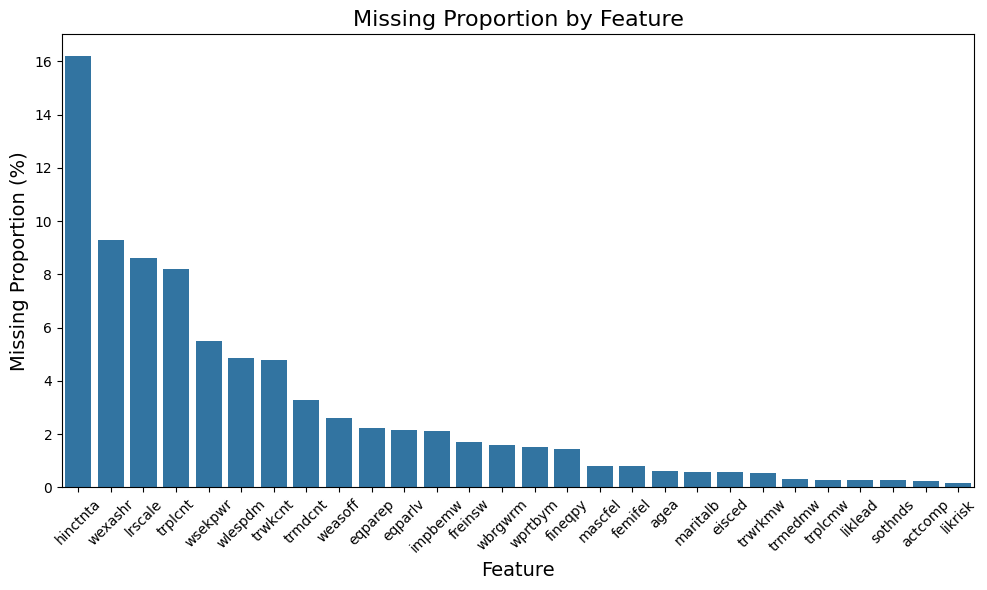

In [27]:
# see features with missing values
with_missing = missing_features + refusal_features + noidea_features
with_missing = list(dict.fromkeys(with_missing))
print(with_missing)
missing_category = [feature for feature in with_missing if feature in categorical_feature]
# visualise
final_missing = X_train_enc.isnull().mean()[X_train_enc.isnull().sum()>0].sort_values(ascending=False) * 100
plt.figure(figsize=(10, 6))

sns.barplot(x=final_missing.index, y=final_missing.values)

plt.title('Missing Proportion by Feature', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Missing Proportion (%)', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [28]:
category_impute_features = [i for i in missing_category if i not in refusal_encode + noidea_encode]
simple_imputer = SimpleImputer(strategy='most_frequent')
X_train_enc[category_impute_features] = simple_imputer.fit_transform(X_train_enc[category_impute_features])
X_val_enc[category_impute_features] = simple_imputer.transform(X_val_enc[category_impute_features])
X_test_enc[category_impute_features] = simple_imputer.transform(X_test_enc[category_impute_features])

In [29]:
# one-hot encoding: train
oh_enc = OneHotEncoder(sparse_output=False)
train_encoded = oh_enc.fit_transform(X_train_enc[categorical_feature])

# create a one-hot df and concat with original
one_hot_train = pd.DataFrame(train_encoded, columns=oh_enc.get_feature_names_out(categorical_feature),index=X_train_enc.index)

X_train_df = X_train_enc.copy()
X_train_df = X_train_df.drop(categorical_feature, axis=1)
X_train_oh = pd.concat([X_train_df, one_hot_train], axis=1)

print(X_train_oh.shape)

# one-hot encoding: val and test
X_val_df = X_val_enc.copy()
val_encoded = oh_enc.transform(X_val_enc[categorical_feature])
one_hot_test = pd.DataFrame(val_encoded, columns=oh_enc.get_feature_names_out(categorical_feature),index=X_val_enc.index)

X_val_df = X_val_enc.copy()
X_val_df = X_val_df.drop(categorical_feature, axis=1)
X_val_oh = pd.concat([X_val_df, one_hot_test], axis=1)

X_test_df = X_test_enc.copy()
test_encoded = oh_enc.transform(X_test_enc[categorical_feature])
one_hot_test = pd.DataFrame(test_encoded, columns=oh_enc.get_feature_names_out(categorical_feature),index=X_test_enc.index)

X_test_df = X_test_enc.copy()
X_test_df = X_test_df.drop(categorical_feature, axis=1)
X_test_oh = pd.concat([X_test_df, one_hot_test], axis=1)

print(X_val_oh.shape)
print(X_test_oh.shape)

(16208, 84)
(2026, 84)
(2027, 84)


In [30]:
rename_dict = {'lrscale': 'left/right', 
                           'likrisk':"risk", 
                           'liklead':"leader", 
                           'sothnds':"sensitive",
                            'actcomp':"compassionate",
                            'mascfel':"masculine",
                            'femifel':"feminine", 
                            'impbemw':"gender importance", 
                            'eqparep':"unequally divide seats", 
                            'eqparlv':"unequal parent leave", 
                            'freinsw':"not fire workplace insult", 
                            'fineqpy':"not fine equal pay",
                            'wsekpwr':"women control men", 
                            'weasoff':"women easily offended", 
                            'wlespdm':"women less pay", 
                            'wexashr':"women sexual harass", 
                            'wprtbym':"women not be protected", 
                            'wbrgwrm':"women not in better sense",
                            'agea':"age", 
                            'eisced':"education", 
                            'hinctnta':"income_level", 
                            'lrscale_noidea':"left/right_noidea", 
                            'lrscale_refusal':"left/right_refusal",
                            'eqparep_noidea':"seats divide_noidea",
                            'wsekpwr_noidea':"women control men_noidea", 
                            'weasoff_noidea':"women easily offend_noidea", 
                            'wlespdm_noidea':"women less pay_noidea",
                            'wexashr_noidea':"women sexual harass_noidea", 
                            'hinctnta_noidea':"income_level_noidea", 
                            'hinctnta_refusal':"income_level_refusal",
                            'trmdcnt_noidea':"equal medical treat_noidea", 
                            'trwkcnt_noidea':"equal work treat_noidea", 
                            'trplcnt_noidea':"equal police treat_noidea", 
                            'cntry_AT':"Austria",
                            'cntry_CH':"Switzerland", 
                            'cntry_DE':"Germany", 
                            'cntry_FI':"Finland", 
                            'cntry_GB':"UK", 
                            'cntry_HR':"Croatia", 
                            'cntry_HU':"Hungary",
                            'cntry_IE':"Ireland",
                            'cntry_LT':"Lithuania", 
                            'cntry_NL':"Netherlands", 
                            'cntry_NO':"Norway",
                            'cntry_SI':"Slovenia", 
                            'cntry_SK':"Slovakia",
                            'trmedmw_1.0':"unfair medical treat_once",
                            'trmedmw_2.0':"unfair medical treat_more", 
                            'trmedmw_3.0':"unfair medical treat_never", 
                            'trmedmw_4.0':"never visit doctor", 
                            'trmedmw_6.0':"unfair medical treat_notapplicable",
                            'trwrkmw_1.0':"unfair work treat_once", 
                            'trwrkmw_2.0': "unfair work treat_more", 
                            'trwrkmw_3.0':"unfair work treat_never", 
                            'trwrkmw_4.0':"never work",
                            'trwrkmw_6.0':"unfair work treat_notapplicable", 
                            'trplcmw_1.0':"unfair police treat_once", 
                            'trplcmw_2.0':"unfair police treat_more", 
                            'trplcmw_3.0':"unfair police treat_never",
                            'trplcmw_4.0':"never contact police", 
                            'trplcmw_6.0':"unfair police treat_notapplicable", 
                            'trmdcnt_1.0':"women treated less fairly medical", 
                            'trmdcnt_2.0':"men treated less fairly medical",
                            'trmdcnt_3.0':"equal treat medical", 
                            'trmdcnt_nan':"equal treat medical_nan", 
                            'trwkcnt_1.0':"women treated less fairly work", 
                            'trwkcnt_2.0':"men treated less fairly work",
                            'trwkcnt_3.0':"equal treat work", 
                            'trwkcnt_nan':"equal treat work_nan", 
                            'trplcnt_1.0':"women treated less fairly police", 
                            'trplcnt_2.0':"men treated less fairly police",
                            'trplcnt_3.0':"equal treat police", 
                            'trplcnt_nan':"equal treat police_nan", 
                            'gndr_1':"male", 
                            'gndr_2':"female", 
                            'maritalb_1.0':"legally married",
                            'maritalb_2.0':"legally registered civil union", 
                            'maritalb_3.0':"legally separated", 
                            'maritalb_4.0':"legally divorced/dissolved", 
                            'maritalb_5.0':"widowed/partner died",
                            'maritalb_6.0':"never married", 
                            'country_group_GEI_above':"GEI_above", 
                            'country_group_GEI_below':"GEI_below",
                            'country_group_non_EU':"non_EU"}

In [31]:
X_train_oh.columns = X_train_oh.rename(columns=rename_dict).columns
X_val_oh.columns = X_val_oh.rename(columns=rename_dict).columns
X_test_oh.columns = X_test_oh.rename(columns=rename_dict).columns

In [32]:
ordinal_feature_re = [
    'left/right', 'risk', 'leader', 'sensitive', 
    'compassionate', 'masculine', 'feminine', 'gender importance', 
    'unequally divide seats', 'unequal parent leave', 'not fire workplace insult', 
    'not fine equal pay', 'women control men', 'women easily offended', 
    'women less pay', 'women sexual harass', 'women not be protected',
    'women not in better sense', 'education', 'income_level']

## Missing Imputation

In [33]:
imputer = IterativeImputer(max_iter=10, random_state=42)
train_imputed = imputer.fit_transform(X_train_oh)
X_train_imputed = pd.DataFrame(train_imputed, columns=X_train_oh.columns).round()

X_train_imputed.head()

left/right  risk  leader  sensitive  compassionate  masculine  feminine  \
0         5.0   3.0     5.0        5.0            6.0        6.0       0.0   
1         0.0   1.0     3.0        6.0            6.0        2.0       4.0   
2         5.0   6.0     4.0        3.0            2.0        5.0       2.0   
3         5.0   3.0     4.0        5.0            5.0        4.0       0.0   
4         4.0   3.0     4.0        4.0            4.0        1.0       3.0   

   gender importance  unequally divide seats  unequal parent leave  ...  \
0                6.0                     5.0                   2.0  ...   
1                0.0                     3.0                   2.0  ...   
2                5.0                     2.0                   1.0  ...   
3                5.0                     4.0                   4.0  ...   
4                4.0                     2.0                   2.0  ...   

   female  legally married  legally registered civil union  legally separated  \
0     0.0              0.0                             0.0                0.0   
1     0.0              0.0                             0.0                0.0   
2     0.0              0.0                             0.0                0.0   
3     0.0              1.0                             0.0                0.0   
4     1.0              1.0                             0.0                0.0   

   legally divorced/dissolved  widowed/partner died  never married  GEI_above  \
0                         0.0                   1.0            0.0        1.0   
1                         0.0                   0.0            1.0        1.0   
2                         1.0                   0.0            0.0        0.0   
3                         0.0                   0.0            0.0        1.0   
4                         0.0                   0.0            0.0        0.0   

   GEI_below  non_EU  
0        0.0     0.0  
1        0.0     0.0  
2        0.0     1.0  
3        0.0     0.0  
4        1.0     0.0  

[5 rows x 84 columns]

In [34]:
X_train_imputed[ordinal_feature_re].describe().T


count      mean       std  min  25%  50%  75%  \
left/right                 16208.0  4.998766  2.101162  0.0  4.0  5.0  6.0   
risk                       16208.0  2.649124  1.774642  0.0  1.0  3.0  4.0   
leader                     16208.0  3.147088  1.775750  0.0  2.0  3.0  4.0   
sensitive                  16208.0  4.460698  1.253882  0.0  4.0  5.0  5.0   
compassionate              16208.0  4.783317  1.076829  0.0  4.0  5.0  6.0   
masculine                  16208.0  2.821138  2.469690  0.0  0.0  3.0  5.0   
feminine                   16208.0  3.060094  2.521377 -0.0  0.0  4.0  6.0   
gender importance          16208.0  4.497409  1.670262  0.0  4.0  5.0  6.0   
unequally divide seats     16208.0  2.646347  1.208781  1.0  2.0  3.0  3.0   
unequal parent leave       16208.0  2.735563  1.327168  1.0  2.0  3.0  4.0   
not fire workplace insult  16208.0  2.205454  1.096105  1.0  1.0  2.0  3.0   
not fine equal pay         16208.0  2.160785  1.117489  1.0  1.0  2.0  3.0   
women control men          16208.0  2.878702  0.784779  1.0  2.0  3.0  3.0   
women easily offended      16208.0  3.190091  0.796012  1.0  3.0  3.0  4.0   
women less pay             16208.0  3.419423  0.829247  1.0  3.0  4.0  4.0   
women sexual harass        16208.0  2.601493  0.820807  1.0  2.0  3.0  3.0   
women not be protected     16208.0  2.522952  0.991090  1.0  2.0  2.0  3.0   
women not in better sense  16208.0  2.702554  0.926596  1.0  2.0  3.0  3.0   
education                  16208.0  4.216190  1.729617  1.0  3.0  4.0  6.0   
income_level               16208.0  5.581750  2.609740 -0.0  4.0  6.0  8.0   

                            max  
left/right                 10.0  
risk                        6.0  
leader                      6.0  
sensitive                   6.0  
compassionate               6.0  
masculine                   6.0  
feminine                    6.0  
gender importance           6.0  
unequally divide seats      5.0  
unequal parent leave        5.0  
not fire workplace insult   5.0  
not fine equal pay          5.0  
women control men           5.0  
women easily offended       5.0  
women less pay              5.0  
women sexual harass         5.0  
women not be protected      5.0  
women not in better sense   5.0  
education                   7.0  
income_level               10.0

In [35]:
# impute val and test null
val_imputed = imputer.transform(X_val_oh)
X_val_imputed = pd.DataFrame(val_imputed, columns=X_val_oh.columns).round()

test_imputed = imputer.transform(X_test_oh)
X_test_imputed = pd.DataFrame(test_imputed, columns=X_test_oh.columns).round()

X_test_imputed.head()

left/right  risk  leader  sensitive  compassionate  masculine  feminine  \
0         5.0   3.0     0.0        6.0            6.0        1.0       6.0   
1         5.0   2.0     3.0        4.0            4.0        5.0       0.0   
2         3.0   5.0     4.0        6.0            6.0        6.0       0.0   
3         6.0   4.0     2.0        5.0            5.0        2.0       5.0   
4        10.0   2.0     3.0        6.0            6.0        0.0       6.0   

   gender importance  unequally divide seats  unequal parent leave  ...  \
0                3.0                     3.0                   4.0  ...   
1                4.0                     2.0                   4.0  ...   
2                3.0                     3.0                   3.0  ...   
3                5.0                     4.0                   4.0  ...   
4                6.0                     4.0                   1.0  ...   

   female  legally married  legally registered civil union  legally separated  \
0     1.0              1.0                             0.0                0.0   
1     0.0              0.0                             0.0                0.0   
2     0.0              0.0                             0.0                1.0   
3     1.0              1.0                             0.0                0.0   
4     1.0              0.0                             0.0                0.0   

   legally divorced/dissolved  widowed/partner died  never married  GEI_above  \
0                         0.0                   0.0            0.0        0.0   
1                         0.0                   1.0            0.0        0.0   
2                         0.0                   0.0            0.0        0.0   
3                         0.0                   0.0            0.0        1.0   
4                         0.0                   0.0            1.0        1.0   

   GEI_below  non_EU  
0        1.0     0.0  
1        1.0     0.0  
2        0.0     1.0  
3        0.0     0.0  
4        0.0     0.0  

[5 rows x 84 columns]

In [36]:
X_train_imputed[ordinal_feature_re].describe().T


count      mean       std  min  25%  50%  75%  \
left/right                 16208.0  4.998766  2.101162  0.0  4.0  5.0  6.0   
risk                       16208.0  2.649124  1.774642  0.0  1.0  3.0  4.0   
leader                     16208.0  3.147088  1.775750  0.0  2.0  3.0  4.0   
sensitive                  16208.0  4.460698  1.253882  0.0  4.0  5.0  5.0   
compassionate              16208.0  4.783317  1.076829  0.0  4.0  5.0  6.0   
masculine                  16208.0  2.821138  2.469690  0.0  0.0  3.0  5.0   
feminine                   16208.0  3.060094  2.521377 -0.0  0.0  4.0  6.0   
gender importance          16208.0  4.497409  1.670262  0.0  4.0  5.0  6.0   
unequally divide seats     16208.0  2.646347  1.208781  1.0  2.0  3.0  3.0   
unequal parent leave       16208.0  2.735563  1.327168  1.0  2.0  3.0  4.0   
not fire workplace insult  16208.0  2.205454  1.096105  1.0  1.0  2.0  3.0   
not fine equal pay         16208.0  2.160785  1.117489  1.0  1.0  2.0  3.0   
women control men          16208.0  2.878702  0.784779  1.0  2.0  3.0  3.0   
women easily offended      16208.0  3.190091  0.796012  1.0  3.0  3.0  4.0   
women less pay             16208.0  3.419423  0.829247  1.0  3.0  4.0  4.0   
women sexual harass        16208.0  2.601493  0.820807  1.0  2.0  3.0  3.0   
women not be protected     16208.0  2.522952  0.991090  1.0  2.0  2.0  3.0   
women not in better sense  16208.0  2.702554  0.926596  1.0  2.0  3.0  3.0   
education                  16208.0  4.216190  1.729617  1.0  3.0  4.0  6.0   
income_level               16208.0  5.581750  2.609740 -0.0  4.0  6.0  8.0   

                            max  
left/right                 10.0  
risk                        6.0  
leader                      6.0  
sensitive                   6.0  
compassionate               6.0  
masculine                   6.0  
feminine                    6.0  
gender importance           6.0  
unequally divide seats      5.0  
unequal parent leave        5.0  
not fire workplace insult   5.0  
not fine equal pay          5.0  
women control men           5.0  
women easily offended       5.0  
women less pay              5.0  
women sexual harass         5.0  
women not be protected      5.0  
women not in better sense   5.0  
education                   7.0  
income_level               10.0

In [37]:
X_train_imputed['income_level'] = X_train_imputed['income_level'].clip(lower=1, upper=10000)
X_val_imputed['income_level'] = X_train_imputed['income_level'].clip(lower=1, upper=10000)
X_test_imputed['income_level'] = X_train_imputed['income_level'].clip(lower=1, upper=10000)

## Ordinal Encoding

In [38]:
# ordinal encodeing: train
ordinal_enc = OrdinalEncoder()
X_train_or = X_train_imputed.copy()
X_train_or[ordinal_feature_re] = ordinal_enc.fit_transform(X_train_or[ordinal_feature_re])
X_train_or[ordinal_feature_re].describe().T

count      mean       std  min  25%  50%  75%  \
left/right                 16208.0  4.998766  2.101162  0.0  4.0  5.0  6.0   
risk                       16208.0  2.649124  1.774642  0.0  1.0  3.0  4.0   
leader                     16208.0  3.147088  1.775750  0.0  2.0  3.0  4.0   
sensitive                  16208.0  4.460698  1.253882  0.0  4.0  5.0  5.0   
compassionate              16208.0  4.783317  1.076829  0.0  4.0  5.0  6.0   
masculine                  16208.0  2.821138  2.469690  0.0  0.0  3.0  5.0   
feminine                   16208.0  3.060094  2.521377  0.0  0.0  4.0  6.0   
gender importance          16208.0  4.497409  1.670262  0.0  4.0  5.0  6.0   
unequally divide seats     16208.0  1.646347  1.208781  0.0  1.0  2.0  2.0   
unequal parent leave       16208.0  1.735563  1.327168  0.0  1.0  2.0  3.0   
not fire workplace insult  16208.0  1.205454  1.096105  0.0  0.0  1.0  2.0   
not fine equal pay         16208.0  1.160785  1.117489  0.0  0.0  1.0  2.0   
women control men          16208.0  1.878702  0.784779  0.0  1.0  2.0  2.0   
women easily offended      16208.0  2.190091  0.796012  0.0  2.0  2.0  3.0   
women less pay             16208.0  2.419423  0.829247  0.0  2.0  3.0  3.0   
women sexual harass        16208.0  1.601493  0.820807  0.0  1.0  2.0  2.0   
women not be protected     16208.0  1.522952  0.991090  0.0  1.0  1.0  2.0   
women not in better sense  16208.0  1.702554  0.926596  0.0  1.0  2.0  2.0   
education                  16208.0  3.216190  1.729617  0.0  2.0  3.0  5.0   
income_level               16208.0  4.581935  2.609379  0.0  3.0  5.0  7.0   

                            max  
left/right                 10.0  
risk                        6.0  
leader                      6.0  
sensitive                   6.0  
compassionate               6.0  
masculine                   6.0  
feminine                    6.0  
gender importance           6.0  
unequally divide seats      4.0  
unequal parent leave        4.0  
not fire workplace insult   4.0  
not fine equal pay          4.0  
women control men           4.0  
women easily offended       4.0  
women less pay              4.0  
women sexual harass         4.0  
women not be protected      4.0  
women not in better sense   4.0  
education                   6.0  
income_level                9.0

In [39]:
# ordinal encoding: val and test
X_val_or = X_val_imputed.copy()
X_val_or[ordinal_feature_re] = ordinal_enc.transform(X_val_or[ordinal_feature_re])
print(X_val_or.shape)

X_test_or = X_test_imputed.copy()
X_test_or[ordinal_feature_re] = ordinal_enc.transform(X_test_or[ordinal_feature_re])
print(X_test_or.shape)

(2026, 84)
(2027, 84)


## Standardisation

In [40]:
# standard scale
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_or)
X_val_sc = scaler.transform(X_val_or)
X_test_sc = scaler.transform(X_test_or)

# Model Training

In [41]:
# set y

y_train_wrk = y_train.iloc[:,0].to_numpy()
y_train_pol = y_train.iloc[:,1].to_numpy()
y_train_mgm = y_train.iloc[:,2].to_numpy()
y_train_pay = y_train.iloc[:,3].to_numpy()

y_val_wrk = y_val.iloc[:,0].to_numpy()
y_val_pol = y_val.iloc[:,1].to_numpy()
y_val_mgm = y_val.iloc[:,2].to_numpy()
y_val_pay = y_val.iloc[:,3].to_numpy()

y_test_wrk = y_test.iloc[:,0].to_numpy()
y_test_pol = y_test.iloc[:,1].to_numpy()
y_test_mgm = y_test.iloc[:,2].to_numpy()
y_test_pay = y_test.iloc[:,3].to_numpy()

In [42]:
def set_seed():
    SEED = 42
    import random
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    keras.utils.set_random_seed(SEED)  
    # if use tensorflow
    tf.config.experimental.enable_op_determinism()

## loss, metrics

In [43]:
# define qwk loss

def quadratic_weighted_kappa_loss(num_classes):
    """
    Quadratic weighted kappa loss for ordinal multi-class classification.
    """
    def loss_fn(y_true, y_pred):
        # turn y_true to one-hot format
        y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
        # y_true_onehot = tf.squeeze(y_true_onehot, axis=-2) 

        # probability distribution
        y_pred = tf.cast(y_pred, tf.float32)

        # create observed matrix O
        O = tf.einsum('bi,bj->ij', y_true_onehot, y_pred)

        # weighted matrix w(i, j) = (i - j)^2
        i = tf.range(num_classes)
        j = tf.range(num_classes)
        i, j = tf.meshgrid(i, j)
        weights = tf.square(i - j)
        weights = tf.cast(weights, tf.float32)

        # compute expected matrix E
        row_sum = tf.reduce_sum(O, axis=1, keepdims=True)
        col_sum = tf.reduce_sum(O, axis=0, keepdims=True)
        total = tf.reduce_sum(O)
        E = tf.matmul(row_sum, col_sum) / total

        # same data type
        E = tf.cast(E, tf.float32)

        # weighted error of observed matrix O and expected matrix E
        weighted_O = tf.reduce_sum(tf.multiply(O, weights))
        weighted_E = tf.reduce_sum(tf.multiply(E, weights))

        # QWK = 1 - (weighted_O / weighted_E)
        qwk = 1 - (weighted_O / weighted_E)

        # return to loss (1 - QWK 或 log(QWK) 以便最小化)
        # 使用负值或对 QWK 取 log 增加稳定性
        loss = -tf.math.log(tf.maximum(qwk, 1e-8))  # 避免 log(0) 问题
        # loss = 1 - qwk
        return loss

    return loss_fn


# define focal loss
def focal_loss(gamma=2., num_classes=7, class_frequencies=None):
    """
    Focal loss for multi-class classification.

    Args:
        alpha: (float) Weighting factor for the rare class (default: 0.25)
        gamma: (float) Focusing parameter (level of focus) (default: 2.)
        num_classes: (int) Number of classes (default: 7)
    """
    def focal_loss_fn(y_true, y_pred):
        # calculate alpha
        if class_frequencies is not None:
            class_weights = 1. / class_frequencies
            # normalise
            alpha = class_weights / K.sum(class_weights)
        else: 
            alpha = 0.25  # default value

        # clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())   
        # one-hot encoding of true labels
        y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes)
        
        # cross-entropy loss
        cross_entropy = -y_true * K.log(y_pred)
        
        # calculate the modulating factor (1 - p_t) ^ gamma
        modulating_factor = K.pow(1 - y_pred, gamma)

        # tensors float32
        alpha = tf.cast(alpha, tf.float32)
        modulating_factor = tf.cast(modulating_factor, tf.float32)
        cross_entropy = tf.cast(cross_entropy, tf.float32)

        # calculate the final loss
        loss = alpha * modulating_factor * cross_entropy
        
        # sum over all classes and return total loss
        return K.sum(loss, axis=-1)
    
    return focal_loss_fn


def combined_loss(alpha=None, gamma=2., num_classes=7, qwk_weight=0.5, focal_weight=0.5, class_frequencies=None):
    """
    Combined loss function: weight_qwk * QWK Loss + weight_focal * Focal Loss

    Args:
        alpha: (float) Weighting factor for the rare class (default: 0.25)
        gamma: (float) Focusing parameter (level of focus) (default: 2.)
        num_classes: (int) Number of classes (default: 7)
        qwk_weight: (float) Weighting factor for QWK loss (default: 0.5)
        focal_weight: (float) Weighting factor for Focal loss (default: 0.5)
    """
    def loss_fn(y_true, y_pred):
        # Calculate QWK loss
        qwk_loss = quadratic_weighted_kappa_loss(num_classes)(y_true, y_pred)
        
        # calculate Focal loss
        focal_loss_fn = focal_loss(gamma=gamma, num_classes=num_classes, class_frequencies=class_frequencies)
        focal_loss_value = focal_loss_fn(y_true, y_pred)
        
        # combine the losses 
        combined_loss_value = qwk_weight * qwk_loss + focal_weight * focal_loss_value
        
        return combined_loss_value
    
    return loss_fn


In [44]:

class QuadraticWeightedKappa(tf.keras.metrics.Metric):
    def __init__(self, name="quadratic_weighted_kappa", **kwargs):
        super(QuadraticWeightedKappa, self).__init__(name=name, **kwargs)
        self.total_qwk = self.add_weight(name="total_qwk", initializer="zeros", dtype=tf.float32)
        self.total_count = self.add_weight(name="total_count", initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)  # the most probable class

        num_classes = tf.reduce_max([tf.reduce_max(y_true), tf.reduce_max(y_pred)]) + 1
        
        O = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes)
        i = tf.range(num_classes)
        j = tf.range(num_classes)
        i, j = tf.meshgrid(i, j)
        weights = tf.square(i - j)
        weights = tf.cast(weights, tf.float32)
        O = tf.cast(O, tf.float32)
        
        weighted_O = tf.reduce_sum(tf.multiply(O, weights))
        row_sum = tf.reduce_sum(O, axis=1, keepdims=True)
        col_sum = tf.reduce_sum(O, axis=0, keepdims=True)
        total = tf.reduce_sum(O)
        E = tf.matmul(row_sum, col_sum) / total
        E = tf.cast(E, tf.float32)
        weighted_E = tf.reduce_sum(tf.multiply(E, weights))
        
        qwk = 1 - (weighted_O / weighted_E)
        
        # Accumulate QWK
        self.total_qwk.assign_add(qwk)
        self.total_count.assign_add(1.0)

    def result(self):
        return self.total_qwk / tf.maximum(self.total_count, 1.0)

    def reset_state(self):
        self.total_qwk.assign(0.0)
        self.total_count.assign(0.0)


class MacroAveragedMAE(tf.keras.metrics.Metric):
    def __init__(self, name="macro_averaged_mae", **kwargs):
        super(MacroAveragedMAE, self).__init__(name=name, **kwargs)
        self.total_mae = self.add_weight(name="total_mae", initializer="zeros", dtype=tf.float32)
        self.total_count = self.add_weight(name="total_count", initializer="zeros", dtype=tf.float32)

    @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)
        
        num_classes = tf.maximum(tf.reduce_max(y_true), tf.reduce_max(y_pred)) + 1
        for c in tf.range(num_classes):
            mask = tf.equal(y_true, c)
            y_true_c = tf.boolean_mask(y_true, mask)
            y_pred_c = tf.boolean_mask(y_pred, mask)
            if tf.size(y_true_c) > 0:
                mae_c = tf.reduce_mean(tf.abs(tf.cast(y_true_c, tf.float32) - tf.cast(y_pred_c, tf.float32)))
                self.total_mae.assign_add(mae_c * tf.cast(tf.size(y_true_c), tf.float32))
                self.total_count.assign_add(tf.cast(tf.size(y_true_c), tf.float32))

    def result(self):
        return self.total_mae / tf.maximum(self.total_count, 1.0)

    def reset_state(self):
        self.total_mae.assign(0.0)
        self.total_count.assign(0.0)


## Models: STL Baseline

In [45]:
class_counts_wrk = np.bincount(y_train_wrk, minlength=7)
total_samples_wrk = np.sum(class_counts_wrk)
class_frequencies_wrk = class_counts_wrk / total_samples_wrk
class_counts_pol = np.bincount(y_train_pol, minlength=7)
total_samples_pol = np.sum(class_counts_pol)
class_frequencies_pol = class_counts_pol / total_samples_pol
class_counts_mgm = np.bincount(y_train_mgm, minlength=7)
total_samples_mgm = np.sum(class_counts_mgm)
class_frequencies_mgm = class_counts_mgm / total_samples_wrk
class_counts_pay = np.bincount(y_train_pay, minlength=7)
total_samples_pay = np.sum(class_counts_pay)
class_frequencies_pay = class_counts_pay / total_samples_wrk

combined_frequency = class_frequencies_wrk + class_frequencies_pol + class_frequencies_mgm + class_frequencies_pay

In [46]:
set_seed()
def baseline(input_size, hidden_size, output_size):
    model = Sequential()
    # input layer + first hidden
    model.add(Input(shape=(input_size,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    # hidden layers
    model.add(layers.Dense(hidden_size, activation='relu')) 
    # batch normalization
    model.add(layers.BatchNormalization())

    # output layer
    model.add(layers.Dense(output_size, activation='softmax')) 
    print(model.summary())

    return model

# def compile_baseline(model, loss_func, metric_func, X_train, y_train, optimizer):
    
def compile_baseline(X_train, y_train, loss, metrics, X_val, y_val, X_test, y_test, epochs=10, batch_size=32):

    # define input, hidden, output size
    input_size = X_train.shape[1]  
    hidden_size = 64  
    output_size = len(np.unique(y_train)) 

    # create the model
    model = baseline(input_size, hidden_size, output_size)

    # compile the model 
    model.compile(optimizer='adam', loss=loss, metrics=metrics)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_val, y_val))
    
    # y_train_pred = model.predict(X_train)
    evaluations_train = model.evaluate(X_train, y_train)
    evaluations_val = model.evaluate(X_val, y_val)
    evaluations_test = model.evaluate(X_test, y_test)
    

    train_loss, train_qwk, train_mamae = evaluations_train
    val_loss, val_qwk, val_mamae = evaluations_val
    test_loss, test_qwk, test_mamae = evaluations_test

    print(f"Train loss: {train_loss}; Train qwk: {train_qwk}; Train ma-mae: {train_mamae}")
    print(f"Val loss: {val_loss}; Val qwk: {val_qwk}; Val ma-mae: {val_mamae}")
    print(f"Test loss: {test_loss}; Test qwk: {test_qwk}; Test ma-mae: {test_mamae}")


    return history, evaluations_train, evaluations_val, evaluations_test

# plot learning curves
def summarize_diagnostics(history):

    epochs_range = range(10)

  # plot metric
    plt.figure(figsize=(16, 5))
    plt.subplot(131)
    plt.title('Baseline Model Training and Validation QWK')
    plt.plot(epochs_range, history.history['quadratic_weighted_kappa'], color='red', label='train')
    plt.plot(epochs_range, history.history['val_quadratic_weighted_kappa'], color='green', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('QWK')
    plt.legend(['training', 'validation'])

    plt.subplot(132)
    plt.title('Baseline Model Training and Validation MA-MAE')
    plt.plot(epochs_range, history.history['macro_averaged_mae'], color='red', label='train')
    plt.plot(epochs_range, history.history['val_macro_averaged_mae'], color='green', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('MA-MAE')
    plt.legend(['training', 'validation'])

	# plot loss
    plt.subplot(133)
    plt.title('Baseline Model Training and Validation Loss')
    plt.plot(epochs_range, history.history['loss'], color='red', label='train')
    plt.plot(epochs_range, history.history['val_loss'], color='green', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['training', 'validation'])


    plt.show()


### Work

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,359 (79.53 KB)

 Trainable params: 19,975 (78.03 KB)

 Non-trainable params: 384 (1.50 KB)

None
Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.8216 - macro_averaged_mae: 2.1262 - quadratic_weighted_kappa: 0.1145 - val_loss: 1.3111 - val_macro_averaged_mae: 1.8184 - val_quadratic_weighted_kappa: 0.2155
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.0980 - macro_averaged_mae: 1.7272 - quadratic_weighted_kappa: 0.2562 - val_loss: 1.1562 - val_macro_averaged_mae: 1.5706 - val_quadratic_weighted_kappa: 0.2565
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.7670 - macro_averaged_mae: 1.4923 - quadratic_weighted_kappa: 0.3266 - val_loss: 1.1077 - val_macro_averaged_mae: 1.4654 - val_quadratic_weighted_kappa: 0.2716
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.6991 - macro_averaged_mae: 1.3656 - quadratic_weighted_kappa: 0.3633 - val_loss: 0.9578 - val_macro_averaged_mae: 1.3578 - val_quadratic_weighted_kappa: 0.2800
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.6372 - macro_averaged_mae: 1.2808 - q

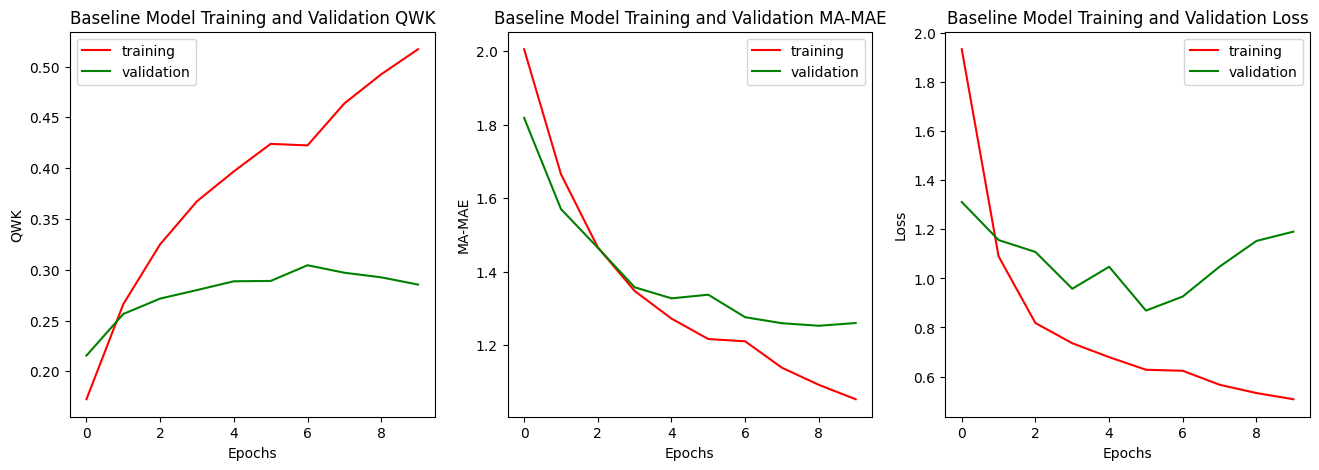

In [47]:
set_seed()
if __name__ == "__main__":
    history, evaluations_train, evaluations_val, evaluation_test = compile_baseline(X_train=X_train_sc, y_train=y_train_wrk, 
                                            loss=combined_loss(gamma=2., num_classes=7, qwk_weight=0.5, focal_weight=0.5, class_frequencies=class_frequencies_wrk), 
                                            metrics=[QuadraticWeightedKappa(), MacroAveragedMAE()],
                                            X_val=X_val_sc, y_val=y_val_wrk, X_test=X_test_sc, y_test=y_test_wrk)

    summarize_diagnostics(history)

### Politics

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        10,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,359 (79.53 KB)

 Trainable params: 19,975 (78.03 KB)

 Non-trainable params: 384 (1.50 KB)

None
Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8726 - macro_averaged_mae: 2.0291 - quadratic_weighted_kappa: 0.1963 - val_loss: 0.6613 - val_macro_averaged_mae: 1.4985 - val_quadratic_weighted_kappa: 0.3561
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.6199 - macro_averaged_mae: 1.4557 - quadratic_weighted_kappa: 0.3761 - val_loss: 0.7318 - val_macro_averaged_mae: 1.2981 - val_quadratic_weighted_kappa: 0.3799
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.5115 - macro_averaged_mae: 1.2030 - quadratic_weighted_kappa: 0.4445 - val_loss: 0.6941 - val_macro_averaged_mae: 1.1535 - val_quadratic_weighted_kappa: 0.4124
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.4612 - macro_averaged_mae: 1.0733 - quadratic_weighted_kappa: 0.4859 - val_loss: 0.6779 - val_macro_averaged_mae: 1.0933 - val_quadratic_weighted_kappa: 0.4272
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.4250 - macro_averaged_mae: 0.9937 - q

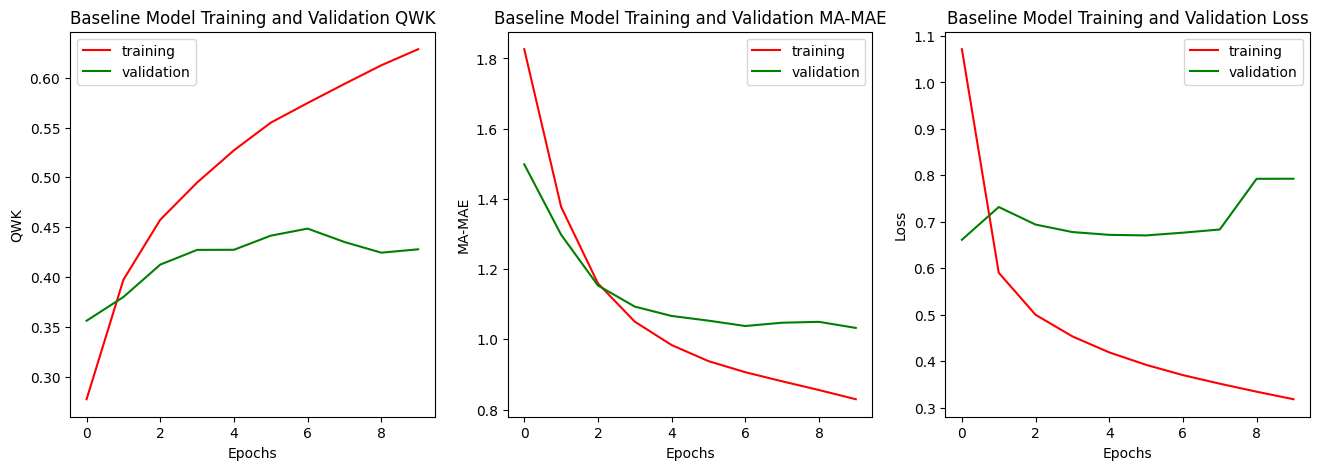

In [48]:
set_seed()
if __name__ == "__main__":
    history, evaluations_train, evaluations_val, evaluations_test = compile_baseline(X_train=X_train_sc, y_train=y_train_pol, 
                                            loss=combined_loss(gamma=2., num_classes=7, qwk_weight=0.5, focal_weight=0.5, class_frequencies=class_frequencies_pol),
                                            metrics=[QuadraticWeightedKappa(), MacroAveragedMAE()],
                                            X_val=X_val_sc, y_val=y_val_pol, X_test=X_test_sc, y_test=y_test_pol)

    summarize_diagnostics(history)

### Management

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │        10,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,359 (79.53 KB)

 Trainable params: 19,975 (78.03 KB)

 Non-trainable params: 384 (1.50 KB)

None
Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.6026 - macro_averaged_mae: 2.2854 - quadratic_weighted_kappa: 0.0783 - val_loss: 1.5009 - val_macro_averaged_mae: 2.0859 - val_quadratic_weighted_kappa: 0.1737
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 1.1029 - macro_averaged_mae: 1.9851 - quadratic_weighted_kappa: 0.2214 - val_loss: 1.0579 - val_macro_averaged_mae: 1.8707 - val_quadratic_weighted_kappa: 0.2435
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.8970 - macro_averaged_mae: 1.8202 - quadratic_weighted_kappa: 0.2852 - val_loss: 0.8374 - val_macro_averaged_mae: 1.7660 - val_quadratic_weighted_kappa: 0.2705
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 0.7846 - macro_averaged_mae: 1.6833 - quadratic_weighted_kappa: 0.3248 - val_loss: 0.7595 - val_macro_averaged_mae: 1.6066 - val_quadratic_weighted_kappa: 0.3237
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.7180 - macro_averaged_mae: 1.5645 - q

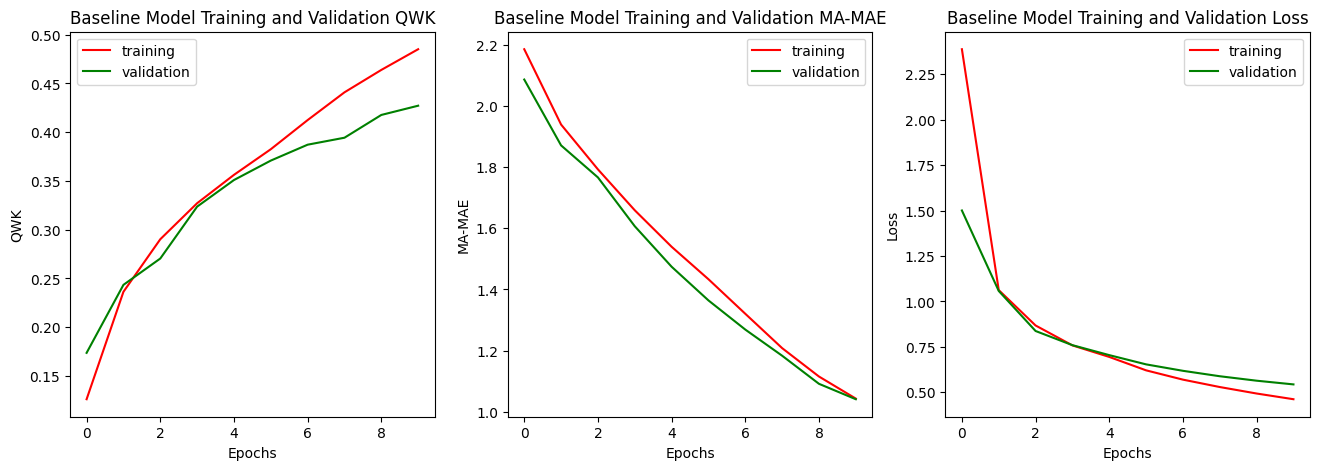

In [49]:
set_seed()
if __name__ == "__main__":
    history, evaluations_train, evaluations_val, evaluation_test = compile_baseline(X_train=X_train_sc, y_train=y_train_mgm, 
                                            loss=combined_loss(gamma=2., num_classes=7, qwk_weight=0.5, focal_weight=0.5, class_frequencies=class_frequencies_mgm), 
                                            metrics=[QuadraticWeightedKappa(), MacroAveragedMAE()],
                                            X_val=X_val_sc, y_val=y_val_mgm, X_test=X_test_sc, y_test=y_test_mgm)

    summarize_diagnostics(history)

### Pay

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │        10,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,359 (79.53 KB)

 Trainable params: 19,975 (78.03 KB)

 Non-trainable params: 384 (1.50 KB)

None
Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9453 - macro_averaged_mae: 1.8491 - quadratic_weighted_kappa: 0.2076 - val_loss: 0.6508 - val_macro_averaged_mae: 1.0484 - val_quadratic_weighted_kappa: 0.3447
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.6009 - macro_averaged_mae: 0.9572 - quadratic_weighted_kappa: 0.4126 - val_loss: 0.6665 - val_macro_averaged_mae: 0.8870 - val_quadratic_weighted_kappa: 0.4140
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 0.4741 - macro_averaged_mae: 0.8466 - quadratic_weighted_kappa: 0.4591 - val_loss: 0.6451 - val_macro_averaged_mae: 0.8346 - val_quadratic_weighted_kappa: 0.4283
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.4124 - macro_averaged_mae: 0.7737 - quadratic_weighted_kappa: 0.5063 - val_loss: 0.7545 - val_macro_averaged_mae: 0.8124 - val_quadratic_weighted_kappa: 0.4317
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.3813 - macro_averaged_mae: 0.7418 - q

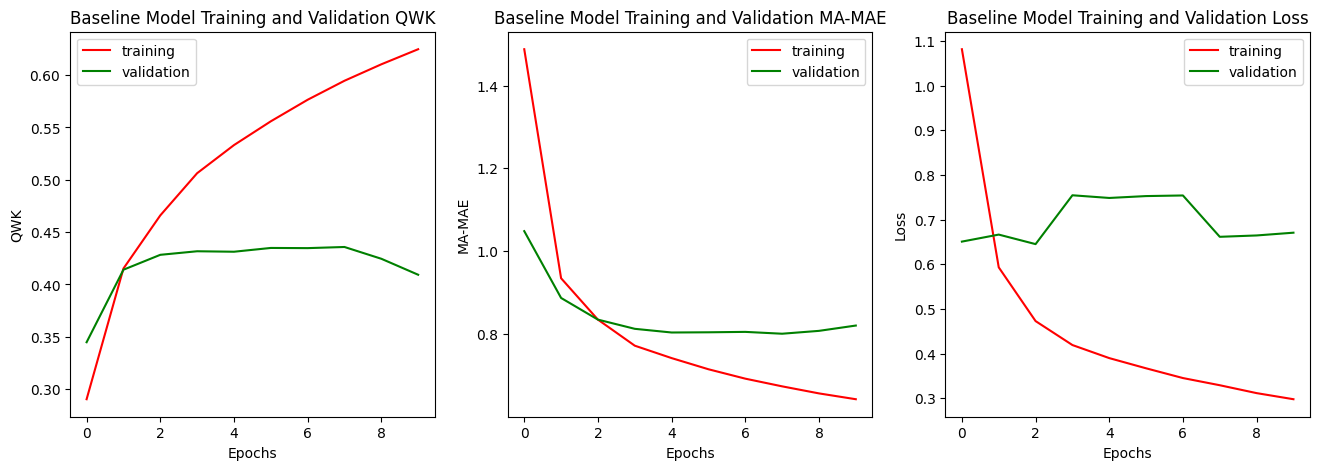

In [50]:
set_seed()
if __name__ == "__main__":
    history, evaluations_train, evaluations_val, evaluation_test = compile_baseline(X_train=X_train_sc, y_train=y_train_pay, 
                                            loss=combined_loss(gamma=2., num_classes=7, qwk_weight=0.5, focal_weight=0.5, class_frequencies=class_frequencies_pay), 
                                            metrics=[QuadraticWeightedKappa(), MacroAveragedMAE()],
                                            X_val=X_val_sc, y_val=y_val_pay, X_test=X_test_sc, y_test=y_test_pay)

    summarize_diagnostics(history)

## Models: MTL Baseline

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 84)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     10,880 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_12[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task_work_output    │ (None, 7)         │        455 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task_politics_outp… │ (None, 7)         │        455 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task_management_ou… │ (None, 7)         │        455 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task_pay_output     │ (None, 7)         │        455 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,724 (84.86 KB)

 Trainable params: 21,340 (83.36 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.8414 - task_management_output_loss: 1.7682 - task_management_output_macro_averaged_mae: 2.1488 - task_management_output_quadratic_weighted_kappa: 0.1513 - task_pay_output_loss: 2.5556 - task_pay_output_macro_averaged_mae: 2.3263 - task_pay_output_quadratic_weighted_kappa: 0.0898 - task_politics_output_loss: 2.1204 - task_politics_output_macro_averaged_mae: 1.8614 - task_politics_output_quadratic_weighted_kappa: 0.1780 - task_work_output_loss: 2.3972 - task_work_output_macro_averaged_mae: 2.1360 - task_work_output_quadratic_weighted_kappa: 0.0841 - val_loss: 3.7304 - val_task_management_output_loss: 0.7423 - val_task_management_output_macro_averaged_mae: 1.7478 - val_task_management_output_quadratic_weighted_kappa: 0.2936 - val_task_pay_output_loss: 1.3527 - val_task_pay_output_macro_averaged_mae: 2.0247 - val_task_pay_output_quadratic_weighted_kappa: 0.1736 - val_task_politics_output_loss: 0.8534 - val_task_politics_output_m

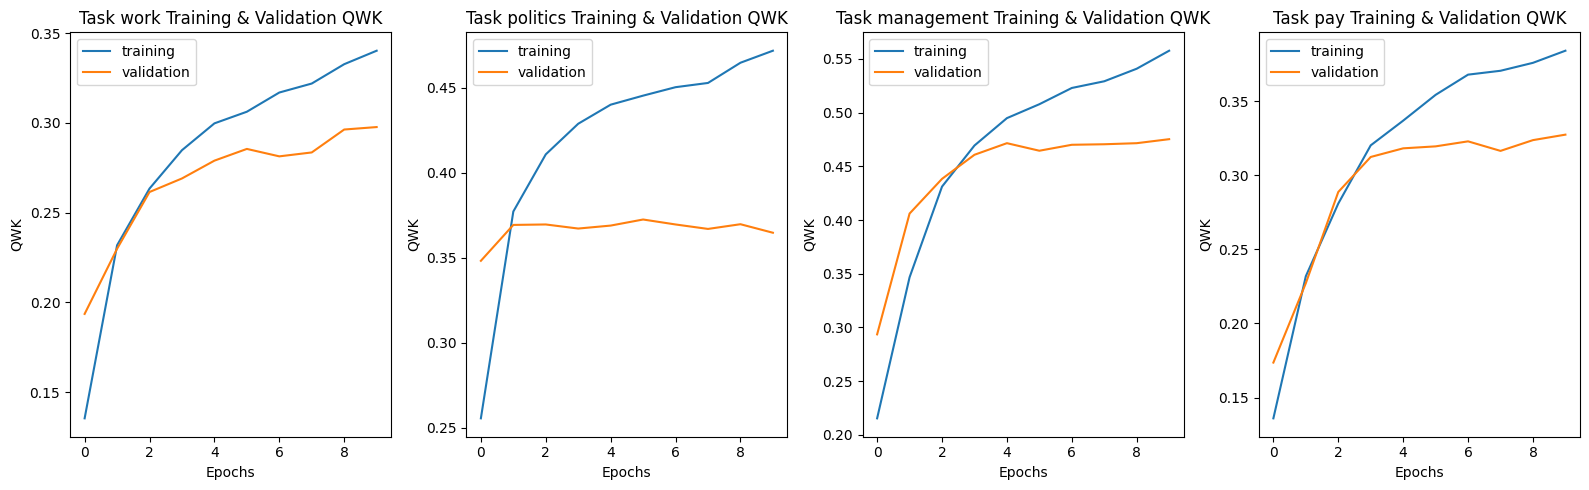


Task Work - Train:
  Loss: 0.3816
  QWK: 0.3234
  MA-MAE: 1.1807

Task Work - Validation:
  Loss: 0.4739
  QWK: 0.2977
  MA-MAE: 1.1742

Task Work - Test:
  Loss: 0.4852
  QWK: 0.2694
  MA-MAE: 1.2052

Task Politics - Train:
  Loss: 0.4122
  QWK: 0.4514
  MA-MAE: 0.9296

Task Politics - Validation:
  Loss: 0.6498
  QWK: 0.3646
  MA-MAE: 1.0262

Task Politics - Test:
  Loss: 0.6604
  QWK: 0.3763
  MA-MAE: 1.0044

Task Management - Train:
  Loss: 0.3826
  QWK: 0.5452
  MA-MAE: 0.8810

Task Management - Validation:
  Loss: 0.4828
  QWK: 0.4752
  MA-MAE: 0.9309

Task Management - Test:
  Loss: 0.5210
  QWK: 0.4698
  MA-MAE: 0.9531

Task Pay - Train:
  Loss: 0.6188
  QWK: 0.3823
  MA-MAE: 1.1501

Task Pay - Validation:
  Loss: 0.8670
  QWK: 0.3273
  MA-MAE: 1.2024

Task Pay - Test:
  Loss: 1.2858
  QWK: 0.3065
  MA-MAE: 1.2018


In [51]:
set_seed()
# set input, class, output size
input_size = X_train_sc.shape[1]
output_sizes = [7, 7, 7, 7]  # classes 0-6

# build model
# input layer
inputs = Input(shape=(input_size,))

# shared layer
shared = Dense(128, activation='relu')(inputs)
shared = BatchNormalization()(shared)
shared = Dense(64, activation='relu')(shared)
shared = BatchNormalization()(shared)

# output for each task
task_outputs = []

task_names = {1: 'work', 2: 'politics', 3: 'management', 4: 'pay'}
# specific task layers and output layers
for i, output_size in enumerate(output_sizes):
    # task_branch = Dense(64, activation='relu', name=f"task_{task_names[i+1]}_branch")(shared)
    task_output = Dense(output_size, activation='softmax', name=f"task_{task_names[i+1]}_output")(shared)
    task_outputs.append(task_output)

model = Model(inputs=inputs, outputs=task_outputs)

model.summary()

# loss and metrics
losses = {
    f"task_{task_names[i+1]}_output": combined_loss(gamma=2., num_classes=output_sizes[i], qwk_weight=0.5, focal_weight=0.5, class_frequencies=combined_frequency)
    for i in range(len(output_sizes))
}
metrics = {
    f"task_{task_names[i+1]}_output": [QuadraticWeightedKappa(), MacroAveragedMAE()]
    for i in range(len(output_sizes))
}

model.compile(optimizer=Adam(), loss=losses, metrics=metrics)

# data
y_trains = [y_train_wrk, y_train_pol, y_train_mgm, y_train_pay]
y_vals = [y_val_wrk, y_val_pol, y_val_mgm, y_val_pay]
y_tests = [y_test_wrk, y_test_pol, y_test_mgm, y_test_pay]

history = model.fit(
    X_train_sc, 
    {f"task_{task_names[i+1]}_output": y_trains[i] for i in range(len(y_trains))},
    validation_data=(X_val_sc, {f"task_{task_names[i+1]}_output": y_vals[i] for i in range(len(y_vals))}),
    epochs=10,
    batch_size=32
)

# visualise
epochs_range = range(10)

plt.figure(figsize=(16, 5))
for i in range(len(output_sizes)):
    task_name = f"task_{task_names[i+1]}_output"

    # QWK for every task
    plt.subplot(1, len(output_sizes), i + 1)
    plt.title(f'Task {task_names[i+1]} Training & Validation QWK')
    plt.plot(epochs_range, history.history[f'{task_name}_quadratic_weighted_kappa'], label='train')
    plt.plot(epochs_range, history.history[f'val_{task_name}_quadratic_weighted_kappa'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('QWK')
    plt.legend(['training', 'validation'])


plt.tight_layout()
plt.show()

train_eval = model.evaluate(X_train_sc, {f"task_{task_names[i+1]}_output": y_trains[i] for i in range(len(y_trains))}, verbose=0, return_dict=True)
val_eval = model.evaluate(X_val_sc, {f"task_{task_names[i+1]}_output": y_vals[i] for i in range(len(y_vals))}, verbose=0, return_dict=True)
test_eval = model.evaluate(X_test_sc, {f"task_{task_names[i+1]}_output": y_tests[i] for i in range(len(y_tests))}, verbose=0, return_dict=True)


for task in task_names.values():
    print(f"\nTask {task.capitalize()} - Train:")
    print(f"  Loss: {train_eval[f'task_{task}_output_loss']:.4f}")
    print(f"  QWK: {train_eval[f'task_{task}_output_quadratic_weighted_kappa']:.4f}")
    print(f"  MA-MAE: {train_eval[f'task_{task}_output_macro_averaged_mae']:.4f}")
    
    print(f"\nTask {task.capitalize()} - Validation:")
    print(f"  Loss: {val_eval[f'task_{task}_output_loss']:.4f}")
    print(f"  QWK: {val_eval[f'task_{task}_output_quadratic_weighted_kappa']:.4f}")
    print(f"  MA-MAE: {val_eval[f'task_{task}_output_macro_averaged_mae']:.4f}")

    print(f"\nTask {task.capitalize()} - Test:")
    print(f"  Loss: {test_eval[f'task_{task}_output_loss']:.4f}")
    print(f"  QWK: {test_eval[f'task_{task}_output_quadratic_weighted_kappa']:.4f}")
    print(f"  MA-MAE: {test_eval[f'task_{task}_output_macro_averaged_mae']:.4f}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 84)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     10,880 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task_work_output    │ (None, 7)         │        455 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task_politics_outp… │ (None, 7)         │        455 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task_management_ou… │ (None, 7)         │        455 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ task_pay_output     │ (None, 7)         │        455 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,724 (84.86 KB)

 Trainable params: 21,340 (83.36 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 10.2857 - task_management_output_loss: 2.1601 - task_management_output_macro_averaged_mae: 2.2738 - task_management_output_quadratic_weighted_kappa: 0.1231 - task_pay_output_loss: 3.4923 - task_pay_output_macro_averaged_mae: 2.3919 - task_pay_output_quadratic_weighted_kappa: 0.0610 - task_politics_output_loss: 2.8508 - task_politics_output_macro_averaged_mae: 2.1156 - task_politics_output_quadratic_weighted_kappa: 0.1287 - task_work_output_loss: 1.7825 - task_work_output_macro_averaged_mae: 1.9937 - task_work_output_quadratic_weighted_kappa: 0.0937 - val_loss: 4.7358 - val_task_management_output_loss: 0.9976 - val_task_management_output_macro_averaged_mae: 1.9269 - val_task_management_output_quadratic_weighted_kappa: 0.2467 - val_task_pay_output_loss: 1.5677 - val_task_pay_output_macro_averaged_mae: 2.1693 - val_task_pay_output_quadratic_weighted_kappa: 0.1421 - val_task_politics_output_loss: 1.3015 - val_task_politics_output_

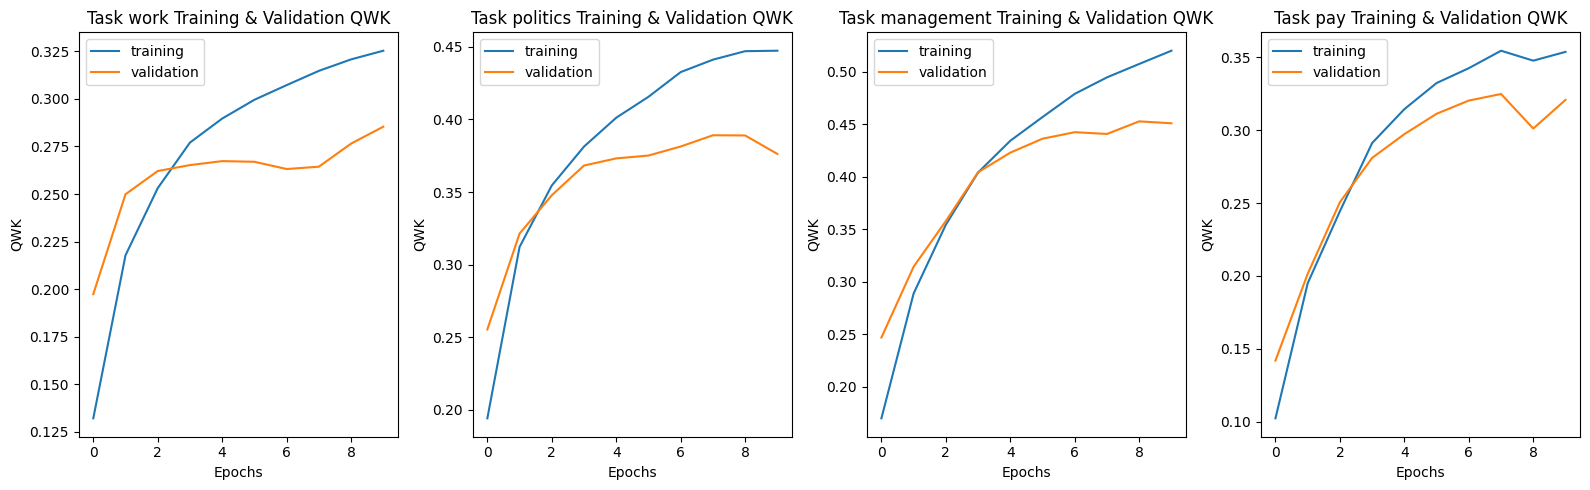


Task Work - Train:
  Loss: 0.3929
  QWK: 0.3215
  MA-MAE: 1.1822

Task Work - Validation:
  Loss: 0.4882
  QWK: 0.2854
  MA-MAE: 1.1945

Task Work - Test:
  Loss: 0.4841
  QWK: 0.2747
  MA-MAE: 1.1949

Task Politics - Train:
  Loss: 0.4656
  QWK: 0.4341
  MA-MAE: 0.9551

Task Politics - Validation:
  Loss: 0.6692
  QWK: 0.3763
  MA-MAE: 1.0252

Task Politics - Test:
  Loss: 0.6353
  QWK: 0.3898
  MA-MAE: 1.0020

Task Management - Train:
  Loss: 0.4081
  QWK: 0.5259
  MA-MAE: 0.9094

Task Management - Validation:
  Loss: 0.5278
  QWK: 0.4509
  MA-MAE: 0.9793

Task Management - Test:
  Loss: 0.5037
  QWK: 0.4672
  MA-MAE: 0.9689

Task Pay - Train:
  Loss: 0.6687
  QWK: 0.3695
  MA-MAE: 1.1479

Task Pay - Validation:
  Loss: 0.7278
  QWK: 0.3206
  MA-MAE: 1.1634

Task Pay - Test:
  Loss: 1.2033
  QWK: 0.3037
  MA-MAE: 1.2008


In [76]:
set_seed()
# set input, class, output size
input_size = X_train_sc.shape[1]
output_sizes = [7, 7, 7, 7]  # classes 0-6

# build model
# input layer
inputs = Input(shape=(input_size,))

# shared layer
shared = Dense(128, activation='relu')(inputs)
shared = BatchNormalization()(shared)
shared = Dense(64, activation='relu')(shared)
shared = BatchNormalization()(shared)

# output for each task
task_outputs = []

task_names = {1: 'work', 2: 'politics', 3: 'management', 4: 'pay'}
# specific task layers and output layers
for i, output_size in enumerate(output_sizes):
    task_branch = Dense(64, activation='relu', name=f"task_{task_names[i+1]}_branch")(shared)
    task_output = Dense(output_size, activation='softmax', name=f"task_{task_names[i+1]}_output")(shared)
    task_outputs.append(task_output)

model = Model(inputs=inputs, outputs=task_outputs)

model.summary()

# loss and metrics
losses = {
    f"task_{task_names[i+1]}_output": combined_loss(gamma=2., num_classes=output_sizes[i], qwk_weight=0.5, focal_weight=0.5, class_frequencies=combined_frequency)
    for i in range(len(output_sizes))
}
metrics = {
    f"task_{task_names[i+1]}_output": [QuadraticWeightedKappa(), MacroAveragedMAE()]
    for i in range(len(output_sizes))
}

model.compile(optimizer=Adam(), loss=losses, metrics=metrics)

# data
y_trains = [y_train_wrk, y_train_pol, y_train_mgm, y_train_pay]
y_vals = [y_val_wrk, y_val_pol, y_val_mgm, y_val_pay]
y_tests = [y_test_wrk, y_test_pol, y_test_mgm, y_test_pay]

history = model.fit(
    X_train_sc, 
    {f"task_{task_names[i+1]}_output": y_trains[i] for i in range(len(y_trains))},
    validation_data=(X_val_sc, {f"task_{task_names[i+1]}_output": y_vals[i] for i in range(len(y_vals))}),
    epochs=10,
    batch_size=32
)

# visualise
epochs_range = range(10)

plt.figure(figsize=(16, 5))
for i in range(len(output_sizes)):
    task_name = f"task_{task_names[i+1]}_output"

    # QWK for every task
    plt.subplot(1, len(output_sizes), i + 1)
    plt.title(f'Task {task_names[i+1]} Training & Validation QWK')
    plt.plot(epochs_range, history.history[f'{task_name}_quadratic_weighted_kappa'], label='train')
    plt.plot(epochs_range, history.history[f'val_{task_name}_quadratic_weighted_kappa'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('QWK')
    plt.legend(['training', 'validation'])


plt.tight_layout()
plt.show()

train_eval = model.evaluate(X_train_sc, {f"task_{task_names[i+1]}_output": y_trains[i] for i in range(len(y_trains))}, verbose=0, return_dict=True)
val_eval = model.evaluate(X_val_sc, {f"task_{task_names[i+1]}_output": y_vals[i] for i in range(len(y_vals))}, verbose=0, return_dict=True)
test_eval = model.evaluate(X_test_sc, {f"task_{task_names[i+1]}_output": y_tests[i] for i in range(len(y_tests))}, verbose=0, return_dict=True)


for task in task_names.values():
    print(f"\nTask {task.capitalize()} - Train:")
    print(f"  Loss: {train_eval[f'task_{task}_output_loss']:.4f}")
    print(f"  QWK: {train_eval[f'task_{task}_output_quadratic_weighted_kappa']:.4f}")
    print(f"  MA-MAE: {train_eval[f'task_{task}_output_macro_averaged_mae']:.4f}")
    
    print(f"\nTask {task.capitalize()} - Validation:")
    print(f"  Loss: {val_eval[f'task_{task}_output_loss']:.4f}")
    print(f"  QWK: {val_eval[f'task_{task}_output_quadratic_weighted_kappa']:.4f}")
    print(f"  MA-MAE: {val_eval[f'task_{task}_output_macro_averaged_mae']:.4f}")

    print(f"\nTask {task.capitalize()} - Test:")
    print(f"  Loss: {test_eval[f'task_{task}_output_loss']:.4f}")
    print(f"  QWK: {test_eval[f'task_{task}_output_quadratic_weighted_kappa']:.4f}")
    print(f"  MA-MAE: {test_eval[f'task_{task}_output_macro_averaged_mae']:.4f}")


## Models: STL tuning

### work

In [52]:
set_seed()
class STLModel_wrk(HyperModel):
    def build(self, hp):
        input_layer = layers.Input(shape=(X_train_sc.shape[1],))

        x = layers.Dense(hp.Int('units1', min_value=32, max_value=256, step=32), activation='relu')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1))(x)

        num_layers = hp.Int('num_layers', 2, 5)
        for _ in range(num_layers - 1):
            x = layers.Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(hp.Float('dropout2', 0.0, 0.5, step=0.1))(x)
        output_layer = layers.Dense(7, activation='softmax')(x)

        model = Model(inputs=input_layer, outputs=output_layer)
        
        model.compile(optimizer=Adam(
                        learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                      loss=combined_loss(
                          gamma=2., num_classes=7, qwk_weight=0.5, focal_weight=0.5,
                          class_frequencies=class_frequencies_wrk),
                      metrics=[QuadraticWeightedKappa(), MacroAveragedMAE()]
                      )
        
        return model
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32,64]),
            **kwargs,
        )
    
# keras tuner
tuner_wrk = Hyperband(
    STLModel_wrk(),  
    objective='val_loss', 
    max_epochs=20,  # max epoch
    factor=3,  # 
    directory='kt_tuning_wrk',  # save catalog
    project_name='single_task_model_tuning',  # project name
    overwrite=True 
)

tuner_wrk.search(
    X_train_sc, y_train_wrk, 
    validation_data=(X_val_sc, y_val_wrk), 
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

tuner_wrk.results_summary()

best_hyperparameters_wrk = tuner_wrk.get_best_hyperparameters(num_trials=1)[0]
print(
    "Best hyperparameters wrk: ", 
    "neuron units first:", best_hyperparameters_wrk.get('units1'), 
    "neuron units follwing:", best_hyperparameters_wrk.get('units2'),
    "dropout1:", best_hyperparameters_wrk.get('dropout1'), 
    "dropout2:", best_hyperparameters_wrk.get('dropout2'), 
    "layer nums:", best_hyperparameters_wrk.get('num_layers'), 
    "learning rate:",best_hyperparameters_wrk.get('learning_rate'),
    "batch size:", best_hyperparameters_wrk.get('batch_size'))

Trial 30 Complete [00h 00m 05s]
val_loss: 0.8427863717079163

Best val_loss So Far: 0.6335456371307373
Total elapsed time: 00h 02m 48s
Results summary
Results in kt_tuning_wrk/single_task_model_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0016 summary
Hyperparameters:
units1: 96
dropout1: 0.30000000000000004
num_layers: 3
units2: 128
dropout2: 0.30000000000000004
learning_rate: 0.00886506988861822
batch_size: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.6335456371307373

Trial 0017 summary
Hyperparameters:
units1: 32
dropout1: 0.1
num_layers: 3
units2: 96
dropout2: 0.4
learning_rate: 0.00678176549630065
batch_size: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.6439286470413208

Trial 0012 summary
Hyperparameters:
units1: 96
dropout1: 0.30000000000000004
num_layers: 3
units2: 128
dropout2: 0.30000000000000004
learning_rate: 0.00886506

In [53]:
set_seed()
# best model
best_model_wrk = tuner_wrk.hypermodel.build(best_hyperparameters_wrk)
history = best_model_wrk.fit(X_train_sc, y_train_wrk, epochs=20, validation_data=(X_val_sc, y_val_wrk), batch_size=64, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])
loss, qwk, mamae = best_model_wrk.evaluate(X_test_sc, y_test_wrk)
print(f"Work Test- Loss: {loss}; QWK: {qwk}; MA-MAE: {mamae}")

Epoch 1/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.4643 - macro_averaged_mae: 1.9216 - quadratic_weighted_kappa: 0.1241 - val_loss: 1.1362 - val_macro_averaged_mae: 1.6283 - val_quadratic_weighted_kappa: 0.2405
Epoch 2/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9604 - macro_averaged_mae: 1.4703 - quadratic_weighted_kappa: 0.2738 - val_loss: 0.7234 - val_macro_averaged_mae: 1.3031 - val_quadratic_weighted_kappa: 0.3215
Epoch 3/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7275 - macro_averaged_mae: 1.3033 - quadratic_weighted_kappa: 0.3256 - val_loss: 0.6926 - val_macro_averaged_mae: 1.2251 - val_quadratic_weighted_kappa: 0.3257
Epoch 4/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6895 - macro_averaged_mae: 1.2486 - quadratic_weighted_kappa: 0.3409 - val_loss: 0.6869 - val_macro_averaged_mae: 1.2394 - val_quadratic_weighted_kappa: 0.3345
Epoch 5/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6622 - macro_averaged_mae: 1.2438 - quadratic_weig

### politics

In [54]:
set_seed()
class STLModel_pol(HyperModel):
    def build(self, hp):
        input_layer = layers.Input(shape=(X_train_sc.shape[1],))

        x = layers.Dense(hp.Int('units1', min_value=32, max_value=256, step=32), activation='relu')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1))(x)

        num_layers = hp.Int('num_layers', 2, 5)
        for _ in range(num_layers - 1):
            x = layers.Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(hp.Float('dropout2', 0.0, 0.5, step=0.1))(x)
        output_layer = layers.Dense(7, activation='softmax')(x)

        model = Model(inputs=input_layer, outputs=output_layer)
        
        model.compile(optimizer=Adam(
                        learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                      loss=combined_loss(
                          gamma=2., num_classes=7, qwk_weight=0.5, focal_weight=0.5,
                          class_frequencies=class_frequencies_pol),
                      metrics=[QuadraticWeightedKappa(), MacroAveragedMAE()]
                      )
        
        return model
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32,64]),
            **kwargs,
        )
# keras tuner
tuner_pol = Hyperband(
    STLModel_pol(),  
    objective='val_loss', 
    max_epochs=20,  # max epoch
    factor=3,  # 
    directory='kt_tuning_pol',  # save catalog
    project_name='single_task_model_tuning',  # project name
    overwrite=True 
)

tuner_pol.search(
    X_train_sc, y_train_pol, 
    validation_data=(X_val_sc, y_val_pol), 
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

tuner_pol.results_summary()

best_hyperparameters_pol = tuner_pol.get_best_hyperparameters(num_trials=1)[0]
print(
    "Best hyperparameters pol: ", 
    "neuron units first:", best_hyperparameters_pol.get('units1'), 
    "neuron units follwing:", best_hyperparameters_pol.get('units2'),
    "dropout1:", best_hyperparameters_pol.get('dropout1'), 
    "dropout2:", best_hyperparameters_pol.get('dropout2'), 
    "layer nums:", best_hyperparameters_pol.get('num_layers'), 
    "learning rate:",best_hyperparameters_pol.get('learning_rate'),
    "batch size:", best_hyperparameters_pol.get('batch_size'))

Trial 30 Complete [00h 00m 09s]
val_loss: 0.4757319986820221

Best val_loss So Far: 0.41958463191986084
Total elapsed time: 00h 02m 51s
Results summary
Results in kt_tuning_pol/single_task_model_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0012 summary
Hyperparameters:
units1: 96
dropout1: 0.30000000000000004
num_layers: 3
units2: 128
dropout2: 0.30000000000000004
learning_rate: 0.00886506988861822
batch_size: 64
tuner/epochs: 7
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0009
Score: 0.41958463191986084

Trial 0017 summary
Hyperparameters:
units1: 32
dropout1: 0.1
num_layers: 3
units2: 96
dropout2: 0.4
learning_rate: 0.00678176549630065
batch_size: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.4226556718349457

Trial 0016 summary
Hyperparameters:
units1: 96
dropout1: 0.30000000000000004
num_layers: 3
units2: 128
dropout2: 0.30000000000000004
learning_rate: 0.0088650

In [55]:
set_seed()
# best model
best_model_pol = tuner_pol.hypermodel.build(best_hyperparameters_pol)
history = best_model_pol.fit(X_train_sc, y_train_pol, epochs=20, validation_data=(X_val_sc, y_val_pol), batch_size=64, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])
loss, qwk, mamae = best_model_pol.evaluate(X_test_sc, y_test_pol)
print(f"Politics Test- Loss: {loss}; QWK: {qwk}; MA-MAE: {mamae}")

Epoch 1/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0784 - macro_averaged_mae: 1.5289 - quadratic_weighted_kappa: 0.3070 - val_loss: 0.4875 - val_macro_averaged_mae: 1.0967 - val_quadratic_weighted_kappa: 0.4576
Epoch 2/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4679 - macro_averaged_mae: 1.0284 - quadratic_weighted_kappa: 0.4737 - val_loss: 0.4649 - val_macro_averaged_mae: 0.9951 - val_quadratic_weighted_kappa: 0.4760
Epoch 3/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5227 - macro_averaged_mae: 1.0431 - quadratic_weighted_kappa: 0.4440 - val_loss: 0.4532 - val_macro_averaged_mae: 1.0030 - val_quadratic_weighted_kappa: 0.4856
Epoch 4/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4365 - macro_averaged_mae: 0.9824 - quadratic_weighted_kappa: 0.4958 - val_loss: 0.4397 - val_macro_averaged_mae: 0.9610 - val_quadratic_weighted_kappa: 0.4885
Epoch 5/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4150 - macro_averaged_mae: 0.9509 - quadratic_weig

### management

In [56]:
set_seed()
class STLModel_mgm(HyperModel):
    def build(self, hp):
        input_layer = layers.Input(shape=(X_train_sc.shape[1],))

        x = layers.Dense(hp.Int('units1', min_value=32, max_value=256, step=32), activation='relu')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1))(x)

        num_layers = hp.Int('num_layers', 2, 5)
        for _ in range(num_layers - 1):
            x = layers.Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(hp.Float('dropout2', 0.0, 0.5, step=0.1))(x)
        output_layer = layers.Dense(7, activation='softmax')(x)

        model = Model(inputs=input_layer, outputs=output_layer)
        
        model.compile(optimizer=Adam(
                        learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                      loss=combined_loss(
                          gamma=2., num_classes=7, qwk_weight=0.5, focal_weight=0.5,
                          class_frequencies=class_frequencies_mgm),
                      metrics=[QuadraticWeightedKappa(), MacroAveragedMAE()]
                      )
        
        return model
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32,64]),
            **kwargs,
        )
    
# keras tuner
tuner_mgm = Hyperband(
    STLModel_mgm(),  
    objective='val_loss', 
    max_epochs=20,  # max epoch
    factor=3,  # 
    directory='kt_tuning_mgm',  # save catalog
    project_name='single_task_model_tuning',  # project name
    overwrite=True 
)

tuner_mgm.search(
    X_train_sc, y_train_mgm, 
    validation_data=(X_val_sc, y_val_mgm), 
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

tuner_mgm.results_summary()

best_hyperparameters_mgm = tuner_mgm.get_best_hyperparameters(num_trials=1)[0]
print(
    "Best hyperparameters mgm: ", 
    "neuron units first:", best_hyperparameters_mgm.get('units1'), 
    "neuron units follwing:", best_hyperparameters_mgm.get('units2'),
    "dropout1:", best_hyperparameters_mgm.get('dropout1'), 
    "dropout2:", best_hyperparameters_mgm.get('dropout2'), 
    "layer nums:", best_hyperparameters_mgm.get('num_layers'), 
    "learning rate:",best_hyperparameters_mgm.get('learning_rate'),
    "batch size:", best_hyperparameters_mgm.get('batch_size'))

Trial 30 Complete [00h 00m 08s]
val_loss: 0.4389673173427582

Best val_loss So Far: 0.4017200469970703
Total elapsed time: 00h 03m 26s
Results summary
Results in kt_tuning_mgm/single_task_model_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0027 summary
Hyperparameters:
units1: 128
dropout1: 0.30000000000000004
num_layers: 4
units2: 96
dropout2: 0.4
learning_rate: 0.0018258615095410535
batch_size: 64
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.4017200469970703

Trial 0016 summary
Hyperparameters:
units1: 96
dropout1: 0.30000000000000004
num_layers: 3
units2: 128
dropout2: 0.30000000000000004
learning_rate: 0.00886506988861822
batch_size: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.4058242440223694

Trial 0017 summary
Hyperparameters:
units1: 32
dropout1: 0.1
num_layers: 3
units2: 96
dropout2: 0.4
learning_rate: 0.00678176549630065
batch_size: 64
tuner/epoc

In [57]:
set_seed()
# best model
best_model_mgm = tuner_mgm.hypermodel.build(best_hyperparameters_mgm)
history = best_model_mgm.fit(X_train_sc, y_train_mgm, epochs=20, validation_data=(X_val_sc, y_val_mgm), batch_size=64, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])
loss, qwk, mamae = best_model_mgm.evaluate(X_test_sc, y_test_mgm)
print(f"Management Test- Loss: {loss}; QWK: {qwk}; MA-MAE: {mamae}")

Epoch 1/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3108 - macro_averaged_mae: 2.1609 - quadratic_weighted_kappa: 0.1245 - val_loss: 0.5669 - val_macro_averaged_mae: 1.4729 - val_quadratic_weighted_kappa: 0.3715
Epoch 2/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6146 - macro_averaged_mae: 1.4212 - quadratic_weighted_kappa: 0.3487 - val_loss: 0.4663 - val_macro_averaged_mae: 1.0701 - val_quadratic_weighted_kappa: 0.4598
Epoch 3/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5107 - macro_averaged_mae: 1.1129 - quadratic_weighted_kappa: 0.4291 - val_loss: 0.4341 - val_macro_averaged_mae: 0.9882 - val_quadratic_weighted_kappa: 0.4751
Epoch 4/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4676 - macro_averaged_mae: 1.0106 - quadratic_weighted_kappa: 0.4560 - val_loss: 0.4159 - val_macro_averaged_mae: 0.9279 - val_quadratic_weighted_kappa: 0.4937
Epoch 5/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4449 - macro_averaged_mae: 0.9637 - quadratic_weig

### pay

In [58]:
set_seed()
class STLModel_pay(HyperModel):
    def build(self, hp):
        input_layer = layers.Input(shape=(X_train_sc.shape[1],))

        x = layers.Dense(hp.Int('units1', min_value=32, max_value=256, step=32), activation='relu')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1))(x)

        num_layers = hp.Int('num_layers', 2, 5)
        for _ in range(num_layers - 1):
            x = layers.Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(hp.Float('dropout2', 0.0, 0.5, step=0.1))(x)
        output_layer = layers.Dense(7, activation='softmax')(x)

        model = Model(inputs=input_layer, outputs=output_layer)
        
        model.compile(optimizer=Adam(
                        learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                      loss=combined_loss(
                          gamma=2., num_classes=7, qwk_weight=0.5, focal_weight=0.5,
                          class_frequencies=class_frequencies_pay),
                      metrics=[QuadraticWeightedKappa(), MacroAveragedMAE()]
                      )
        
        return model
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32,64]),
            **kwargs,
        )
    
# keras tuner
tuner_pay = Hyperband(
    STLModel_pay(),  
    objective='val_loss', 
    max_epochs=20,  # max epoch
    factor=3,  # 
    directory='kt_tuning_pol',  # save catalog
    project_name='single_task_model_tuning',  # project name
    overwrite=True 
)

tuner_pay.search(
    X_train_sc, y_train_pay, 
    validation_data=(X_val_sc, y_val_pay), 
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

tuner_pay.results_summary()

best_hyperparameters_pay = tuner_pay.get_best_hyperparameters(num_trials=1)[0]
print(
    "Best hyperparameters pay: ", 
    "neuron units first:", best_hyperparameters_pay.get('units1'), 
    "neuron units follwing:", best_hyperparameters_pay.get('units2'),
    "dropout1:", best_hyperparameters_pay.get('dropout1'), 
    "dropout2:", best_hyperparameters_pay.get('dropout2'), 
    "layer nums:", best_hyperparameters_pay.get('num_layers'), 
    "learning rate:",best_hyperparameters_pay.get('learning_rate'),
    "batch size:", best_hyperparameters_pay.get('batch_size'))

Trial 30 Complete [00h 00m 06s]
val_loss: 0.6319159269332886

Best val_loss So Far: 0.4115487337112427
Total elapsed time: 00h 03m 56s
Results summary
Results in kt_tuning_pol/single_task_model_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0017 summary
Hyperparameters:
units1: 96
dropout1: 0.30000000000000004
num_layers: 3
units2: 128
dropout2: 0.30000000000000004
learning_rate: 0.00886506988861822
batch_size: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.4115487337112427

Trial 0016 summary
Hyperparameters:
units1: 32
dropout1: 0.1
num_layers: 3
units2: 96
dropout2: 0.4
learning_rate: 0.00678176549630065
batch_size: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.4144768714904785

Trial 0027 summary
Hyperparameters:
units1: 128
dropout1: 0.30000000000000004
num_layers: 4
units2: 96
dropout2: 0.4
learning_rate: 0.0018258615095410535
batc

In [59]:
set_seed()
# best model
best_model_pay = tuner_pay.hypermodel.build(best_hyperparameters_pay)
history = best_model_pay.fit(X_train_sc, y_train_pay, epochs=20, validation_data=(X_val_sc, y_val_pay), batch_size=64, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])
loss, qwk, mamae = best_model_pay.evaluate(X_test_sc, y_test_pay)
print(f"Pay Test- Loss: {loss}; QWK: {qwk}; MA-MAE: {mamae}")

Epoch 1/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0066 - macro_averaged_mae: 1.3904 - quadratic_weighted_kappa: 0.2773 - val_loss: 0.4783 - val_macro_averaged_mae: 0.8959 - val_quadratic_weighted_kappa: 0.4316
Epoch 2/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4812 - macro_averaged_mae: 0.8647 - quadratic_weighted_kappa: 0.4408 - val_loss: 0.4547 - val_macro_averaged_mae: 0.8317 - val_quadratic_weighted_kappa: 0.4595
Epoch 3/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4600 - macro_averaged_mae: 0.8082 - quadratic_weighted_kappa: 0.4519 - val_loss: 0.4601 - val_macro_averaged_mae: 0.7532 - val_quadratic_weighted_kappa: 0.4581
Epoch 4/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4342 - macro_averaged_mae: 0.7641 - quadratic_weighted_kappa: 0.4777 - val_loss: 0.4359 - val_macro_averaged_mae: 0.7843 - val_quadratic_weighted_kappa: 0.4681
Epoch 5/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4073 - macro_averaged_mae: 0.7647 - quadratic_weig

## Models: MTL tuned

In [60]:
set_seed()
class MTLModel(kt.HyperModel):
    def build(self, hp):
        input_layer = layers.Input(shape=(X_train_sc.shape[1],))

        # shared hidden layers
        x = layers.Dense(hp.Int('units1', min_value=32, max_value=256, step=32), activation='relu')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1))(x)

        num_layers = hp.Int('num_layers', 2, 5)
        for _ in range(num_layers - 1):
            x = layers.Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(hp.Float('dropout2', 0.0, 0.5, step=0.1))(x)

        task_outputs = []

        task_names = ['work', 'politics', 'management', 'pay']
        for task in task_names:
            task_x = x 
            task_x = layers.Dense(hp.Int(f'{task}_units', min_value=32, max_value=256, step=32), activation='relu')(task_x)
            task_x = layers.BatchNormalization()(task_x)
            task_x = layers.Dropout(hp.Float(f'{task}_dropout', 0.0, 0.5, step=0.1))(task_x)

            task_output = layers.Dense(7, activation='softmax', name=f'{task}_output')(task_x)
            task_outputs.append(task_output)

        model = Model(inputs=input_layer, outputs=task_outputs)

        model.compile(
            optimizer=Adam(
                learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
            ),
            loss={
                f'{task}_output': combined_loss(
                    gamma=2., num_classes=7, qwk_weight=0.5, focal_weight=0.5, class_frequencies=combined_frequency
                ) for task in task_names
            },
            metrics={
                f'{task}_output': [QuadraticWeightedKappa(), MacroAveragedMAE()] for task in task_names
            }
        )

        return model

    def fit(self, hp, model, *args, **kwargs):
        # Allow different batch sizes
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64]),
            **kwargs,
        )


tuner_mtl = kt.Hyperband(
    MTLModel(),  
    objective='val_loss',  
    max_epochs=20,  
    factor=3,  # factor to decrease resources per trial
    directory='kt_tuning_mtl',  
    project_name='multi_task_model_tuning', 
    overwrite=True  
)

tuner_mtl.search(
    X_train_sc, 
    {
        'work_output': y_train_wrk,
        'politics_output': y_train_pol,
        'management_output': y_train_mgm,
        'pay_output': y_train_pay
    },
    validation_data=(
        X_val_sc, 
        {
            'work_output': y_val_wrk,
            'politics_output': y_val_pol,
            'management_output': y_val_mgm,
            'pay_output': y_val_pay
        }
    ),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)


tuner_mtl.results_summary()

# get the best hyperparameters
best_hyperparameters_mtl = tuner_mtl.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters for MTL model:")
print("First units:", best_hyperparameters_mtl.get('units1'))
print("Other units:", best_hyperparameters_mtl.get('units2'))
print("First dropout:", best_hyperparameters_mtl.get('dropout1'))
print("Other dropout:", best_hyperparameters_mtl.get('dropout2'))
print("Shared layers:", best_hyperparameters_mtl.get('num_layers'))
print("Learning rate:", best_hyperparameters_mtl.get('learning_rate'))
print("Batch size:", best_hyperparameters_mtl.get('batch_size'))

for task in ['work', 'politics', 'management', 'pay']:
    print(f"Task '{task}' specific units:", best_hyperparameters_mtl.get(f'{task}_units'))
    print(f"Task '{task}' specific dropout:", best_hyperparameters_mtl.get(f'{task}_dropout'))



Trial 30 Complete [00h 00m 48s]
val_loss: 1.9021031856536865

Best val_loss So Far: 1.878722071647644
Total elapsed time: 00h 09m 01s
Results summary
Results in kt_tuning_mtl/multi_task_model_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0024 summary
Hyperparameters:
units1: 160
dropout1: 0.2
num_layers: 2
units2: 256
dropout2: 0.1
work_units: 64
work_dropout: 0.0
politics_units: 256
politics_dropout: 0.4
management_units: 64
management_dropout: 0.2
pay_units: 160
pay_dropout: 0.1
learning_rate: 0.004438186255424764
batch_size: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 1.878722071647644

Trial 0016 summary
Hyperparameters:
units1: 256
dropout1: 0.30000000000000004
num_layers: 5
units2: 128
dropout2: 0.0
work_units: 32
work_dropout: 0.0
politics_units: 64
politics_dropout: 0.30000000000000004
management_units: 256
management_dropout: 0.1
pay_units: 128
pay_dropout: 0.4
learning_rate: 0.007264

In [61]:
set_seed()

task_names = {1: 'work', 2: 'politics', 3: 'management', 4: 'pay'}
y_trains = [y_train_wrk, y_train_pol, y_train_mgm, y_train_pay]
y_vals = [y_val_wrk, y_val_pol, y_val_mgm, y_val_pay]
y_tests = [y_test_wrk, y_test_pol, y_test_mgm, y_test_pay]

# best model
best_model_mtl = tuner_mtl.hypermodel.build(best_hyperparameters_mtl)
history = model.fit(
    X_train_sc, 
    {f"task_{task_names[i+1]}_output": y_trains[i] for i in range(len(y_trains))},
    validation_data=(X_val_sc, {f"task_{task_names[i+1]}_output": y_vals[i] for i in range(len(y_vals))}),
    epochs=20,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)
test_eval = model.evaluate(X_test_sc, {f"task_{task_names[i+1]}_output": y_tests[i] for i in range(len(y_tests))}, verbose=0, return_dict=True)

for task in task_names.values():   

    print(f"\nTask {task.capitalize()} - Test:")
    print(f"  Loss: {test_eval[f'task_{task}_output_loss']:.4f}")
    print(f"  QWK: {test_eval[f'task_{task}_output_quadratic_weighted_kappa']:.4f}")
    print(f"  MA-MAE: {test_eval[f'task_{task}_output_macro_averaged_mae']:.4f}")


Epoch 1/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5845 - task_management_output_loss: 0.3614 - task_management_output_macro_averaged_mae: 0.8783 - task_management_output_quadratic_weighted_kappa: 0.5615 - task_pay_output_loss: 0.5073 - task_pay_output_macro_averaged_mae: 1.1613 - task_pay_output_quadratic_weighted_kappa: 0.3810 - task_politics_output_loss: 0.3626 - task_politics_output_macro_averaged_mae: 0.9208 - task_politics_output_quadratic_weighted_kappa: 0.4659 - task_work_output_loss: 0.3532 - task_work_output_macro_averaged_mae: 1.1712 - task_work_output_quadratic_weighted_kappa: 0.3406 - val_loss: 2.0480 - val_task_management_output_loss: 0.4538 - val_task_management_output_macro_averaged_mae: 0.9289 - val_task_management_output_quadratic_weighted_kappa: 0.4912 - val_task_pay_output_loss: 0.6770 - val_task_pay_output_macro_averaged_mae: 1.1851 - val_task_pay_output_quadratic_weighted_kappa: 0.3305 - val_task_politics_output_loss: 0.4787 - val_task_politics_output_m

### no task-specific layer

In [62]:
set_seed()
class MTLModel1(kt.HyperModel):
    def build(self, hp):
        input_layer = layers.Input(shape=(X_train_sc.shape[1],))

        # shared hidden layers
        x = layers.Dense(hp.Int('units1', min_value=32, max_value=256, step=32), activation='relu')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1))(x)

        num_layers = hp.Int('num_layers', 2, 5)
        for _ in range(num_layers - 1):
            x = layers.Dense(hp.Int('units2', min_value=32, max_value=256, step=32), activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(hp.Float('dropout2', 0.0, 0.5, step=0.1))(x)

        task_outputs = []

        task_names = ['work', 'politics', 'management', 'pay']
        for task in task_names:
            task_x = x 
           
            task_output = layers.Dense(7, activation='softmax', name=f'{task}_output')(task_x)
            task_outputs.append(task_output)

        model = Model(inputs=input_layer, outputs=task_outputs)

        model.compile(
            optimizer=Adam(
                learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
            ),
            loss={
                f'{task}_output': combined_loss(
                    gamma=2., num_classes=7, qwk_weight=0.5, focal_weight=0.5, class_frequencies=combined_frequency
                ) for task in task_names
            },
            metrics={
                f'{task}_output': [QuadraticWeightedKappa(), MacroAveragedMAE()] for task in task_names
            }
        )

        return model

    def fit(self, hp, model, *args, **kwargs):
        # Allow different batch sizes
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64]),
            **kwargs,
        )


tuner_mtl1 = kt.Hyperband(
    MTLModel1(),  
    objective='val_loss',  
    max_epochs=20,  
    factor=3,  # factor to decrease resources per trial
    directory='kt_tuning_mtl',  
    project_name='multi_task_model_tuning_without_specific_layer', 
    overwrite=True  
)

tuner_mtl1.search(
    X_train_sc, 
    {
        'work_output': y_train_wrk,
        'politics_output': y_train_pol,
        'management_output': y_train_mgm,
        'pay_output': y_train_pay
    },
    validation_data=(
        X_val_sc, 
        {
            'work_output': y_val_wrk,
            'politics_output': y_val_pol,
            'management_output': y_val_mgm,
            'pay_output': y_val_pay
        }
    ),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)


tuner_mtl1.results_summary()

# get the best hyperparameters
best_hyperparameters_mtl1 = tuner_mtl1.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters for MTL model:")
print("First units:", best_hyperparameters_mtl1.get('units1'))
print("Other units:", best_hyperparameters_mtl1.get('units2'))
print("First dropout:", best_hyperparameters_mtl1.get('dropout1'))
print("Other dropout:", best_hyperparameters_mtl1.get('dropout2'))
print("Shared layers:", best_hyperparameters_mtl1.get('num_layers'))
print("Learning rate:", best_hyperparameters_mtl1.get('learning_rate'))
print("Batch size:", best_hyperparameters_mtl1.get('batch_size'))



Trial 30 Complete [00h 00m 23s]
val_loss: 2.659120798110962

Best val_loss So Far: 1.86520516872406
Total elapsed time: 00h 08m 39s
Results summary
Results in kt_tuning_mtl/multi_task_model_tuning_without_specific_layer
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0016 summary
Hyperparameters:
units1: 96
dropout1: 0.30000000000000004
num_layers: 3
units2: 128
dropout2: 0.30000000000000004
learning_rate: 0.00886506988861822
batch_size: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 1.86520516872406

Trial 0017 summary
Hyperparameters:
units1: 32
dropout1: 0.1
num_layers: 3
units2: 96
dropout2: 0.4
learning_rate: 0.00678176549630065
batch_size: 64
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 1.9083874225616455

Trial 0012 summary
Hyperparameters:
units1: 96
dropout1: 0.30000000000000004
num_layers: 3
units2: 128
dropout2: 0.30000000000000004
learning

In [63]:
set_seed()

task_names = {1: 'work', 2: 'politics', 3: 'management', 4: 'pay'}
y_trains = [y_train_wrk, y_train_pol, y_train_mgm, y_train_pay]
y_vals = [y_val_wrk, y_val_pol, y_val_mgm, y_val_pay]
y_tests = [y_test_wrk, y_test_pol, y_test_mgm, y_test_pay]

# best model
best_model_mtl1 = tuner_mtl1.hypermodel.build(best_hyperparameters_mtl1)
history = model.fit(
    X_train_sc, 
    {f"task_{task_names[i+1]}_output": y_trains[i] for i in range(len(y_trains))},
    validation_data=(X_val_sc, {f"task_{task_names[i+1]}_output": y_vals[i] for i in range(len(y_vals))}),
    epochs=20,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)]
)
test_eval = model.evaluate(X_test_sc, {f"task_{task_names[i+1]}_output": y_tests[i] for i in range(len(y_tests))}, verbose=0, return_dict=True)

for task in task_names.values():   

    print(f"\nTask {task.capitalize()} - Test:")
    print(f"  Loss: {test_eval[f'task_{task}_output_loss']:.4f}")
    print(f"  QWK: {test_eval[f'task_{task}_output_quadratic_weighted_kappa']:.4f}")
    print(f"  MA-MAE: {test_eval[f'task_{task}_output_macro_averaged_mae']:.4f}")


Epoch 1/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3916 - task_management_output_loss: 0.3256 - task_management_output_macro_averaged_mae: 0.8327 - task_management_output_quadratic_weighted_kappa: 0.5988 - task_pay_output_loss: 0.4368 - task_pay_output_macro_averaged_mae: 1.1264 - task_pay_output_quadratic_weighted_kappa: 0.3838 - task_politics_output_loss: 0.3157 - task_politics_output_macro_averaged_mae: 0.8949 - task_politics_output_quadratic_weighted_kappa: 0.4896 - task_work_output_loss: 0.3136 - task_work_output_macro_averaged_mae: 1.1437 - task_work_output_quadratic_weighted_kappa: 0.3559 - val_loss: 2.1153 - val_task_management_output_loss: 0.4813 - val_task_management_output_macro_averaged_mae: 0.9452 - val_task_management_output_quadratic_weighted_kappa: 0.4744 - val_task_pay_output_loss: 0.6828 - val_task_pay_output_macro_averaged_mae: 1.1708 - val_task_pay_output_quadratic_weighted_kappa: 0.3156 - val_task_politics_output_loss: 0.4994 - val_task_politics_output_m

## Feature Importance

PermutationExplainer explainer: 2028it [01:00, 28.35it/s]                          


Top 15 Features for Work:


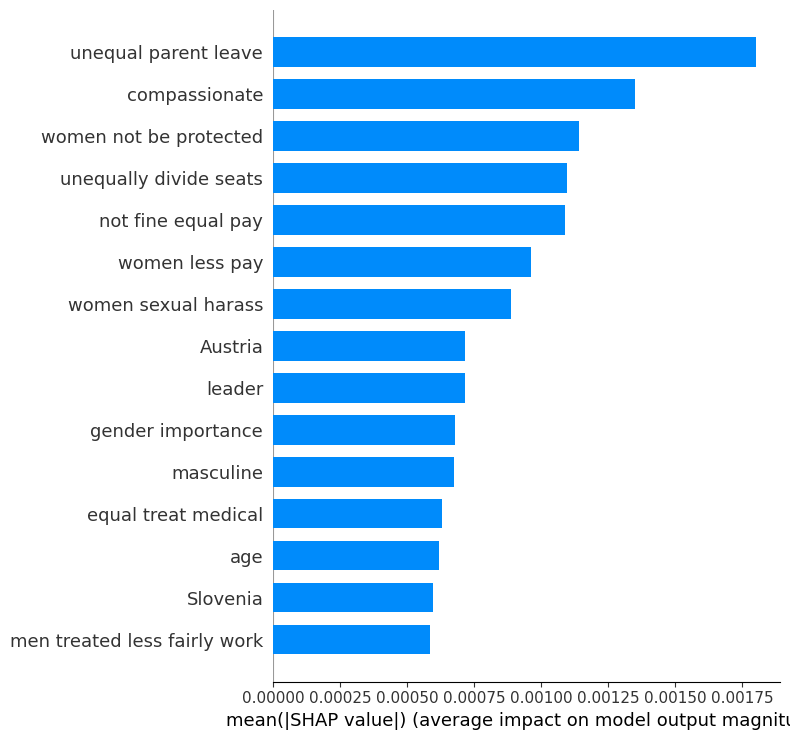

Interaction Plot for Work:


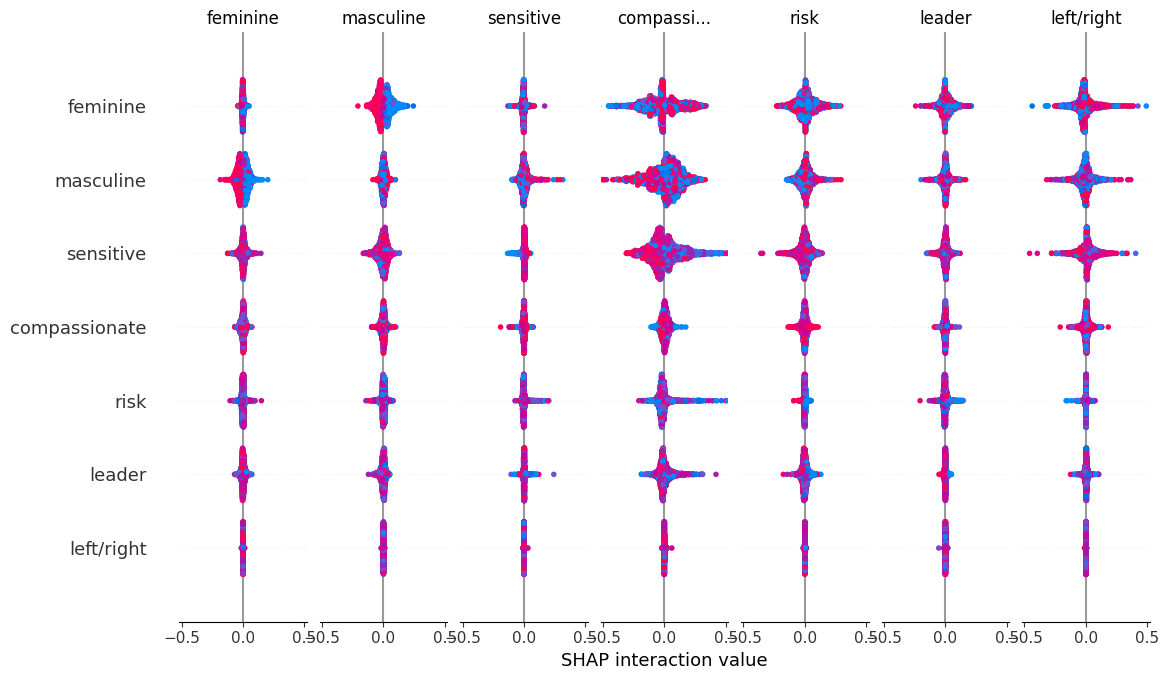

In [64]:
set_seed()
shap.initjs()
exp_wrk = shap.Explainer(best_model_wrk, X_train_sc)
shap_values_wrk = exp_wrk(X_test_sc)
print("Top 15 Features for Work:")
shap.summary_plot(shap_values_wrk[:,:,0], X_test_sc, plot_type='bar', feature_names=X_train_or.columns, max_display=15)
print("Interaction Plot for Work:")
shap.summary_plot(shap_values_wrk, X_test_sc, feature_names=X_train_or.columns)



PermutationExplainer explainer: 2028it [01:00, 27.76it/s]                          


Top 15 Features for Politics:


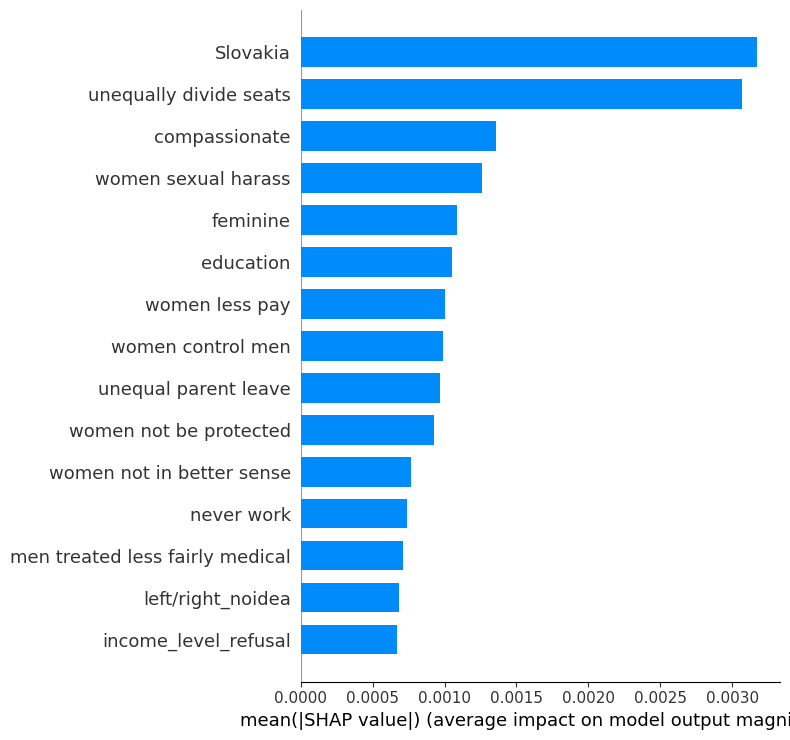

Interaction Plot for Politics:


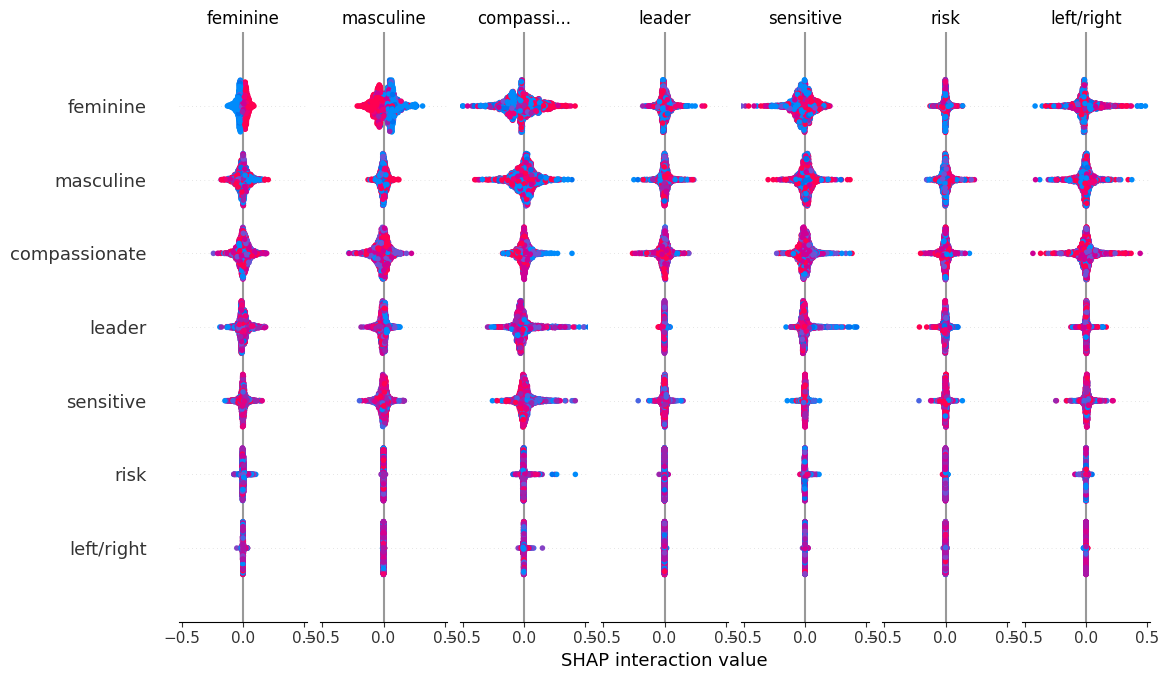

In [65]:
set_seed()
shap.initjs()
exp_pol = shap.Explainer(best_model_pol, X_train_sc)
shap_values_pol = exp_pol(X_test_sc)
print("Top 15 Features for Politics:")
shap.summary_plot(shap_values_pol[:,:,0], X_test_sc, plot_type='bar', feature_names=X_train_or.columns, max_display=15)
print("Interaction Plot for Politics:")
shap.summary_plot(shap_values_pol, X_test_sc, feature_names=X_train_or.columns)

PermutationExplainer explainer: 2028it [01:10, 24.79it/s]                          


Top 15 Features for Management:


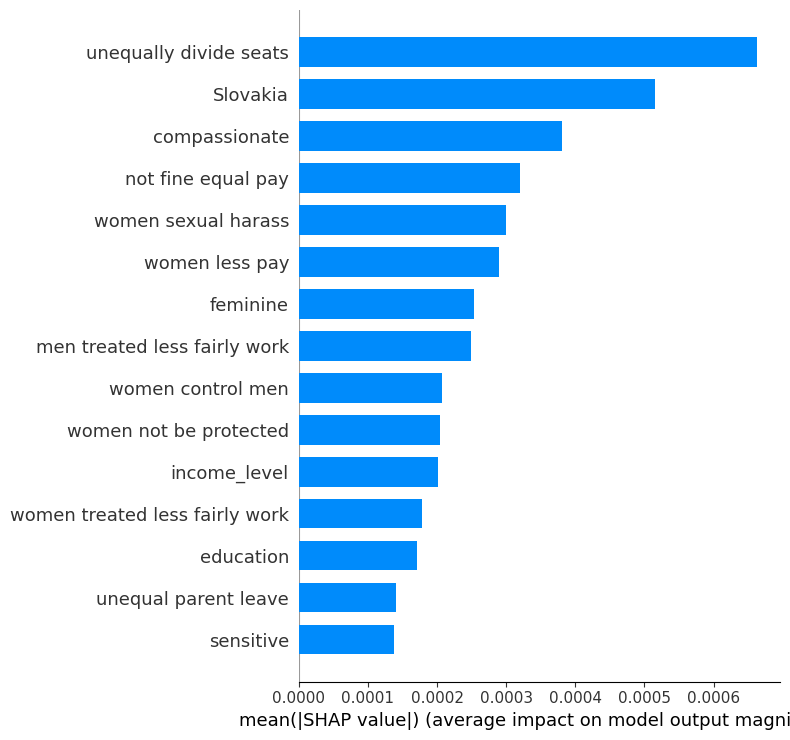

Interaction Plot for Management:


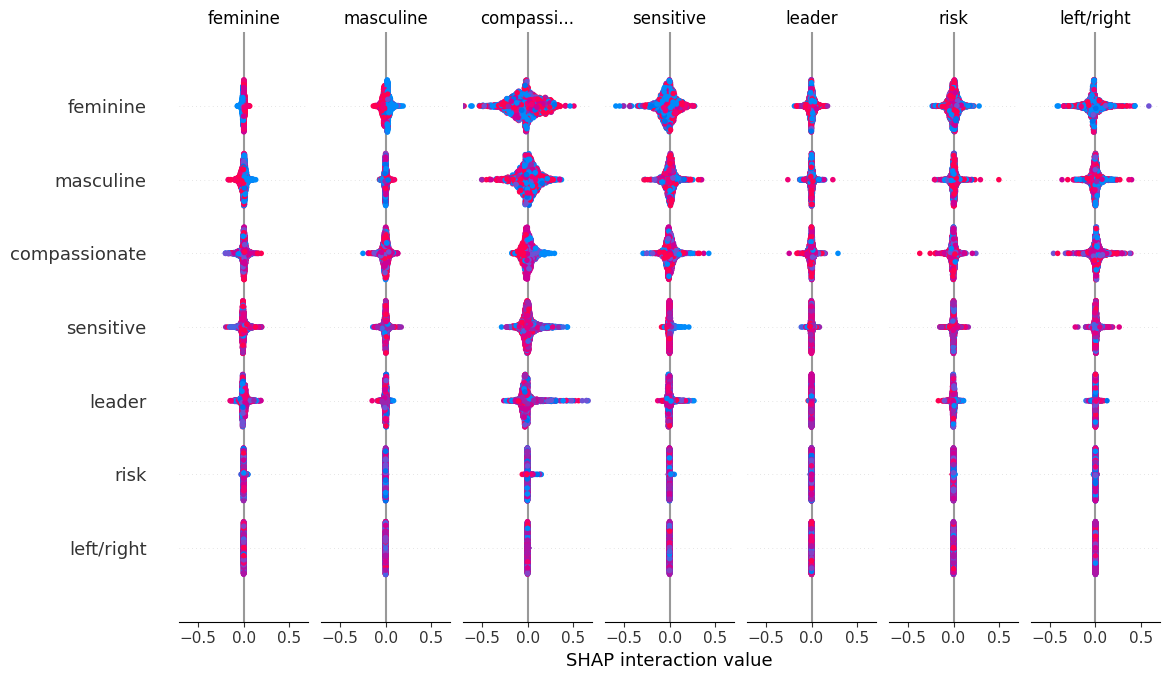

In [66]:
set_seed()
shap.initjs()
exp_mgm = shap.Explainer(best_model_mgm, X_train_sc)
shap_values_mgm = exp_mgm(X_test_sc)
print("Top 15 Features for Management:")
shap.summary_plot(shap_values_mgm[:,:,0], X_test_sc, plot_type='bar', feature_names=X_train_or.columns, max_display=15)
print("Interaction Plot for Management:")
shap.summary_plot(shap_values_mgm, X_test_sc, feature_names=X_train_or.columns)

PermutationExplainer explainer: 2028it [01:12, 24.02it/s]                          


Top 15 Features for Equal Pay:


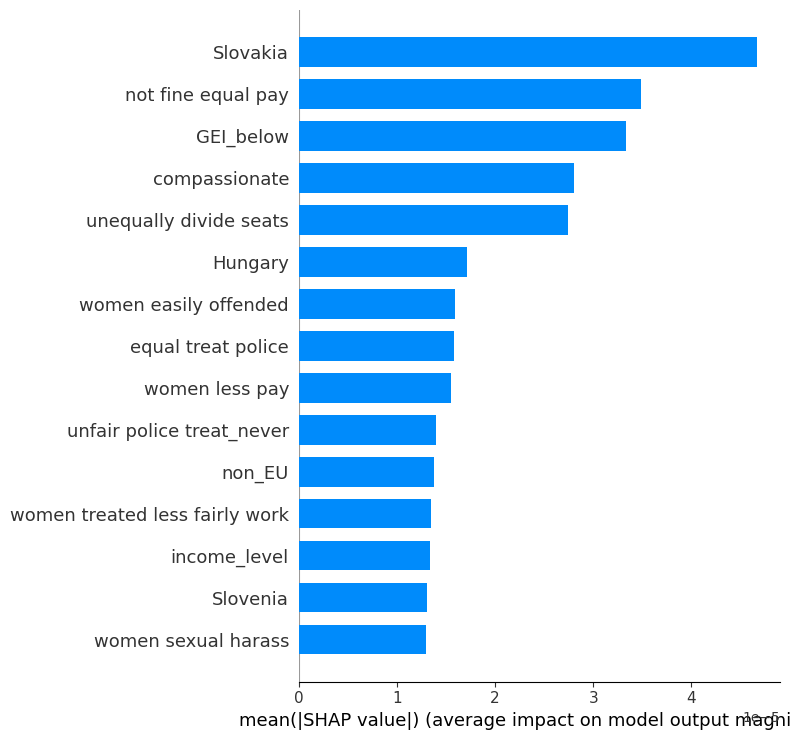

Interaction Plot for Equal Pay:


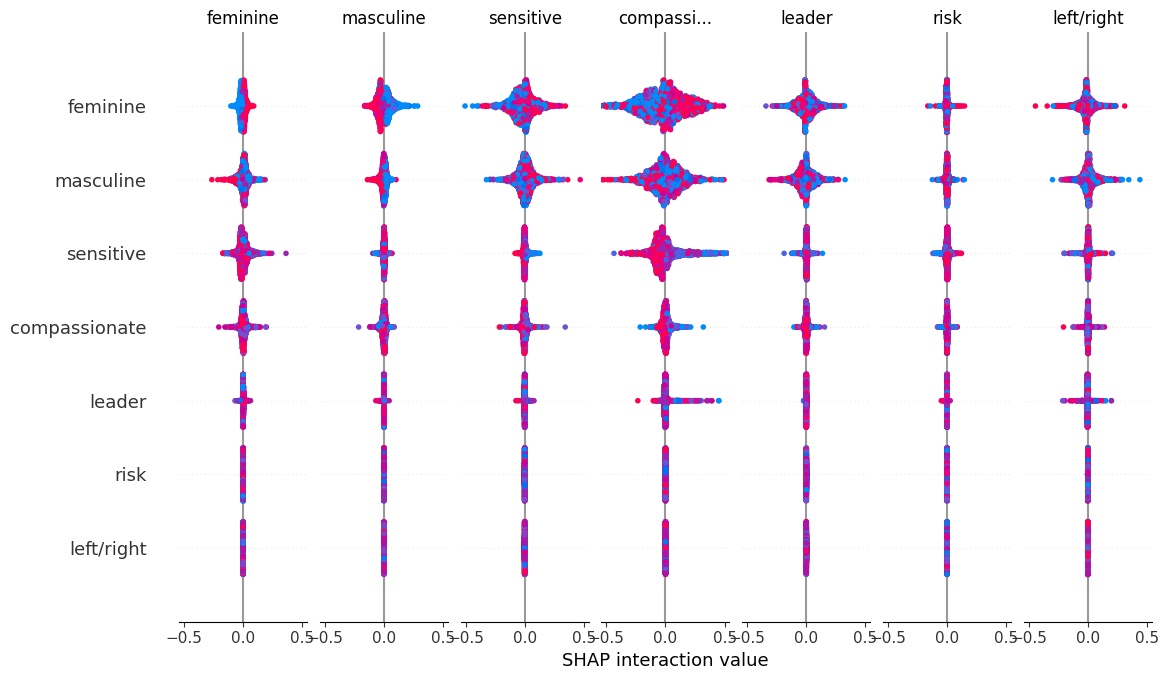

In [67]:
set_seed()
shap.initjs()
exp_pay = shap.Explainer(best_model_pay, X_train_sc)
shap_values_pay = exp_pay(X_test_sc)
print("Top 15 Features for Equal Pay:")
shap.summary_plot(shap_values_pay[:,:,0], X_test_sc, plot_type='bar', feature_names=X_train_or.columns, max_display=15)
print("Interaction Plot for Equal Pay:")
shap.summary_plot(shap_values_pay, X_test_sc, feature_names=X_train_or.columns)

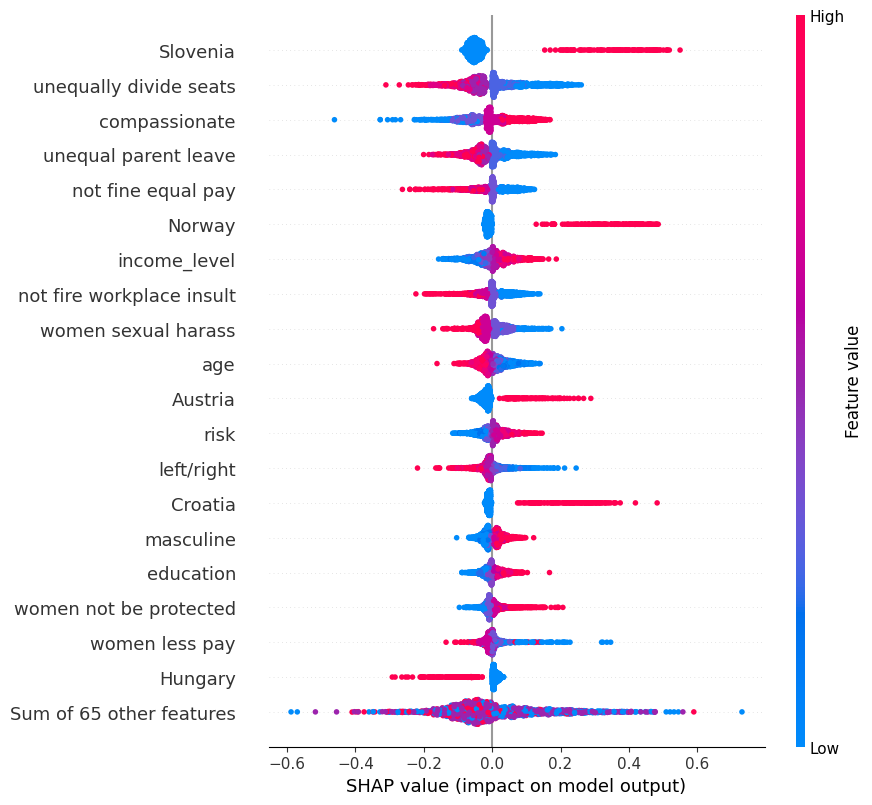

In [224]:
shap.plots.beeswarm(shap_values_wrk[:,:,-1], max_display=20)

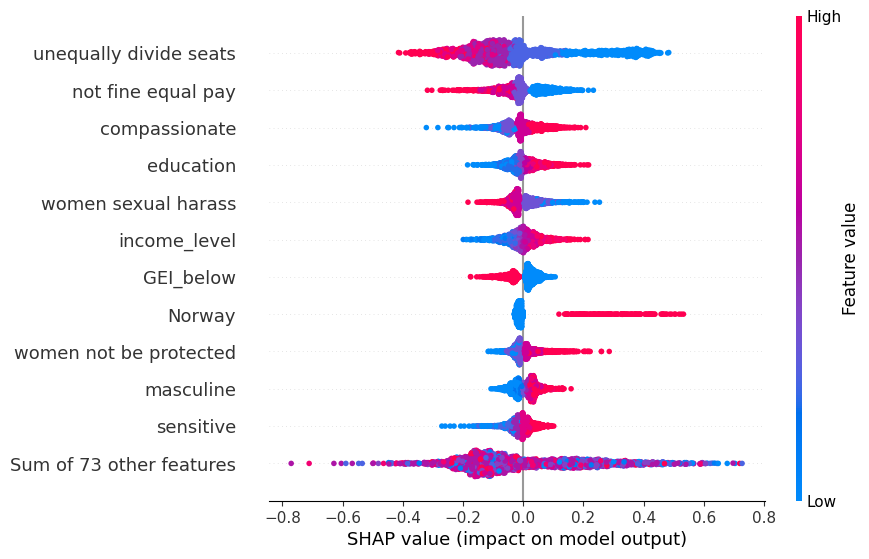

In [204]:
shap.plots.beeswarm(shap_values_pol[:,:,-1], max_display=12)

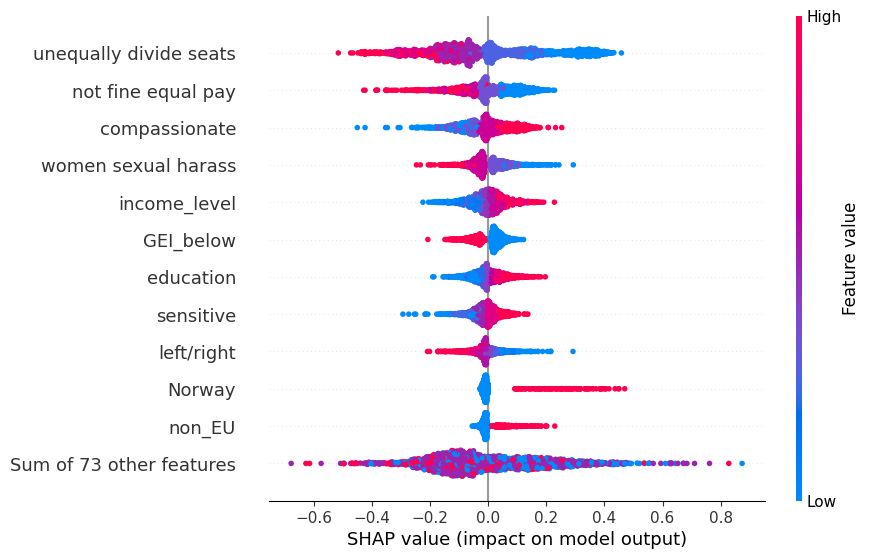

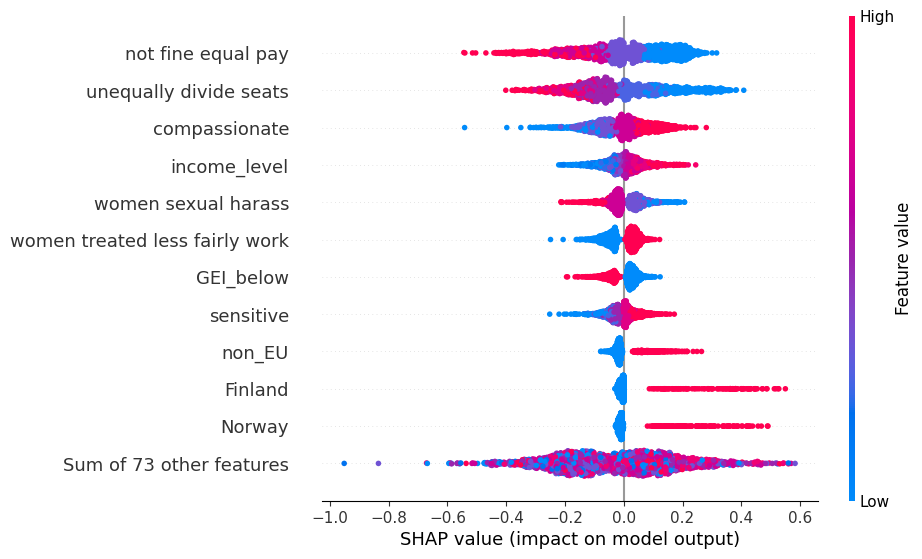

In [206]:

shap.plots.beeswarm(shap_values_mgm[:,:,-1], max_display=12)
shap.plots.beeswarm(shap_values_pay[:,:,-1], max_display=12)


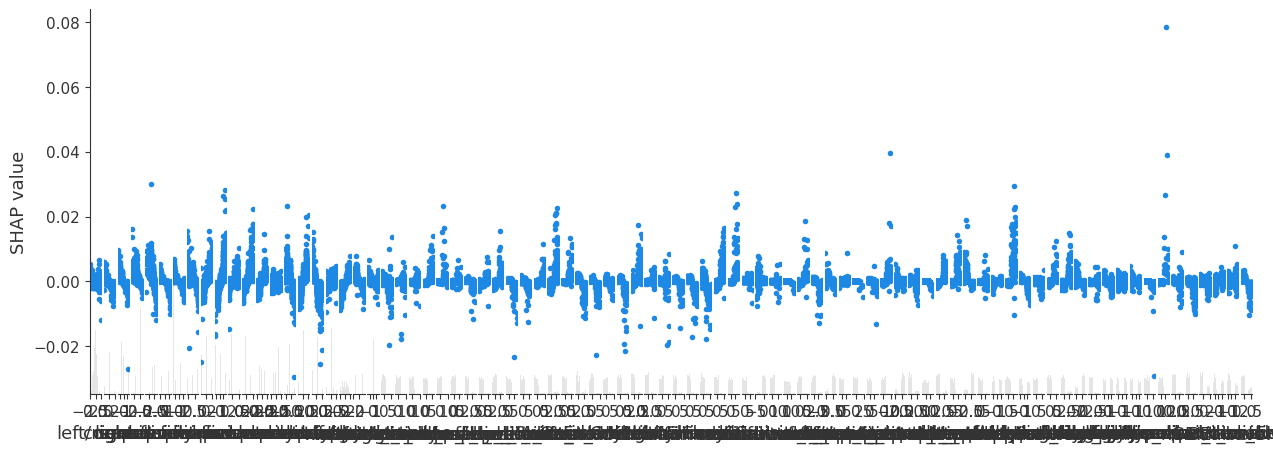

In [219]:
shap.plots.scatter(shap_values_wrk[:,:,0])

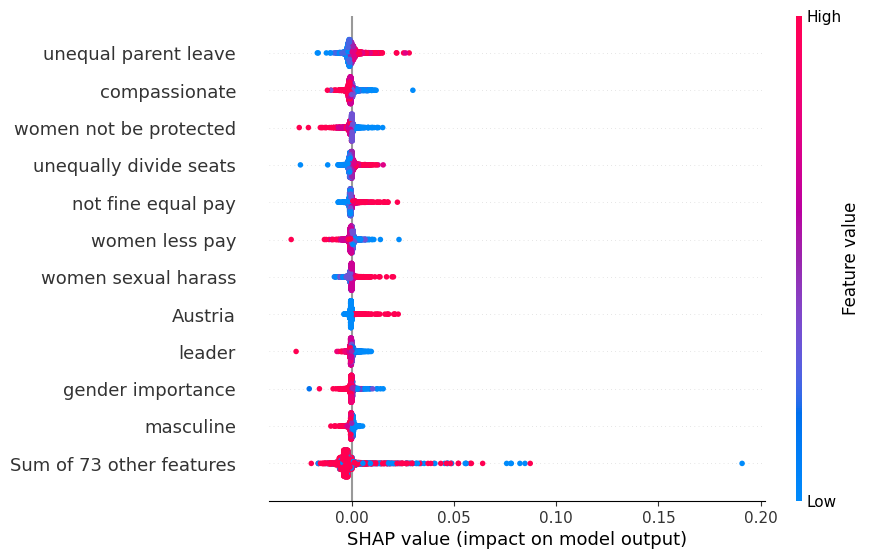

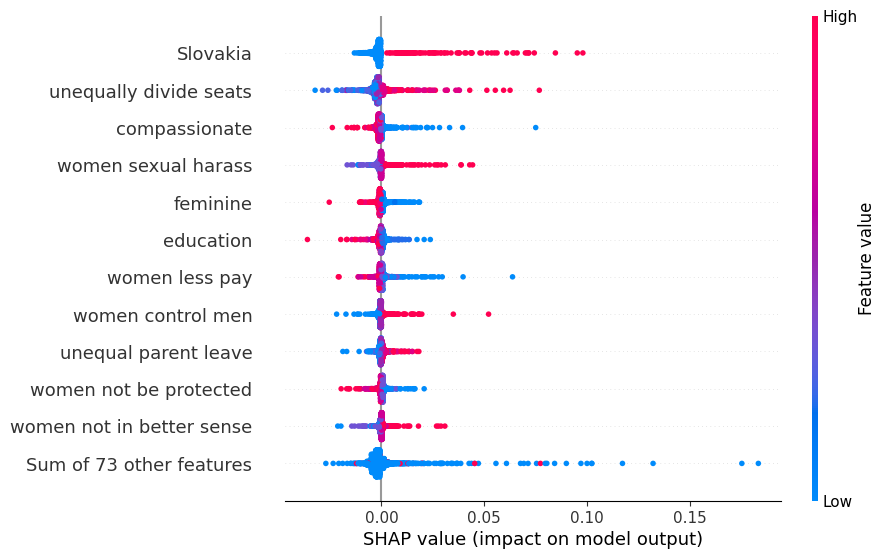

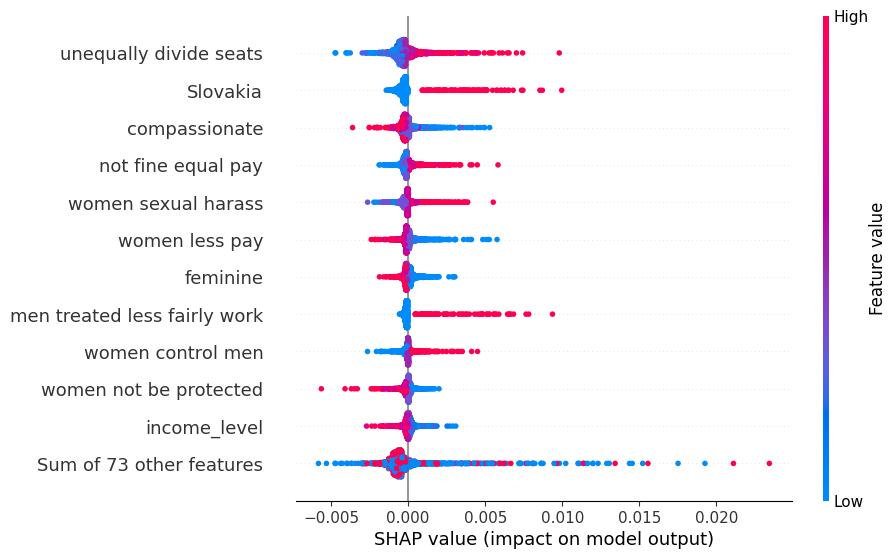

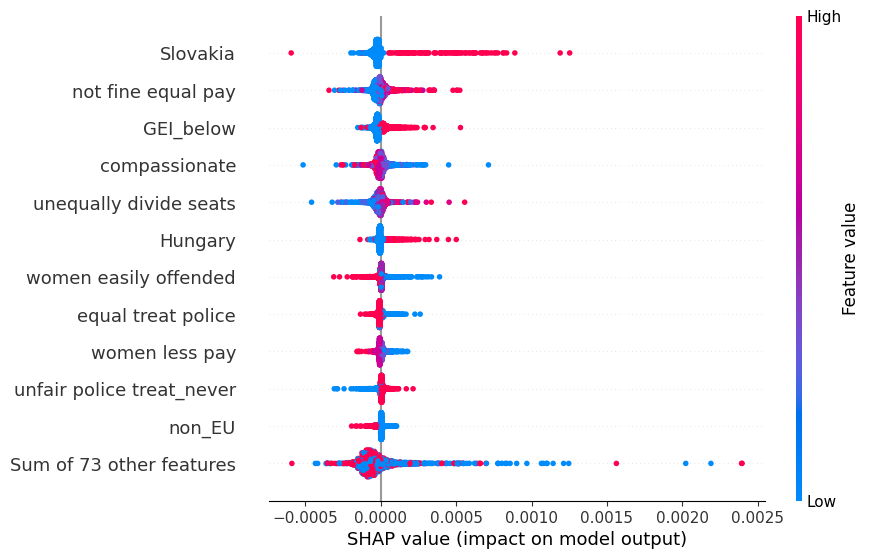

In [208]:
shap.plots.beeswarm(shap_values_wrk[:,:,0], max_display=12)
shap.plots.beeswarm(shap_values_pol[:,:,0], max_display=12)
shap.plots.beeswarm(shap_values_mgm[:,:,0], max_display=12)
shap.plots.beeswarm(shap_values_pay[:,:,0], max_display=12)


In [ ]:
# compute gradients of the output with respect to the input
model = best_model_wrk
input_tensor = tf.convert_to_tensor(X_train_sc)

def feature_importance(input_tensor, model):
    with tf.GradientTape() as tape:

        tape.watch(input_tensor)

        output = model(input_tensor)

        gradients = tape.gradient(output, input_tensor)

        # calculate feature importance as the absolute mean of the gradients

        feature_importance = np.mean(np.abs(gradients.numpy()), axis=0)
    return feature_importance
feature_importance_wrk = feature_importance(input_tensor, best_model_wrk)
feature_importance_pol = feature_importance(input_tensor, best_model_pol)
feature_importance_mgm = feature_importance(input_tensor, best_model_mgm)
feature_importance_pay = feature_importance(input_tensor, best_model_pay)


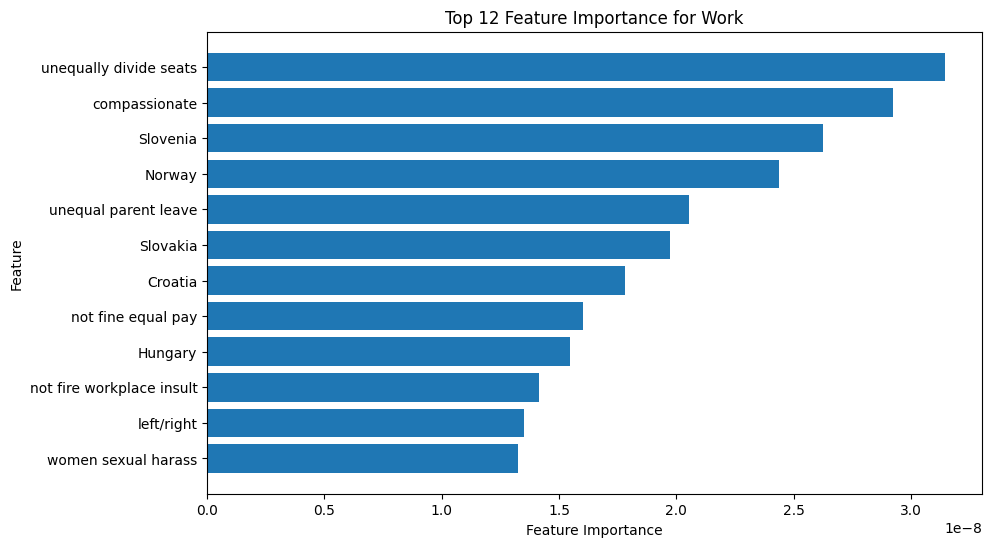

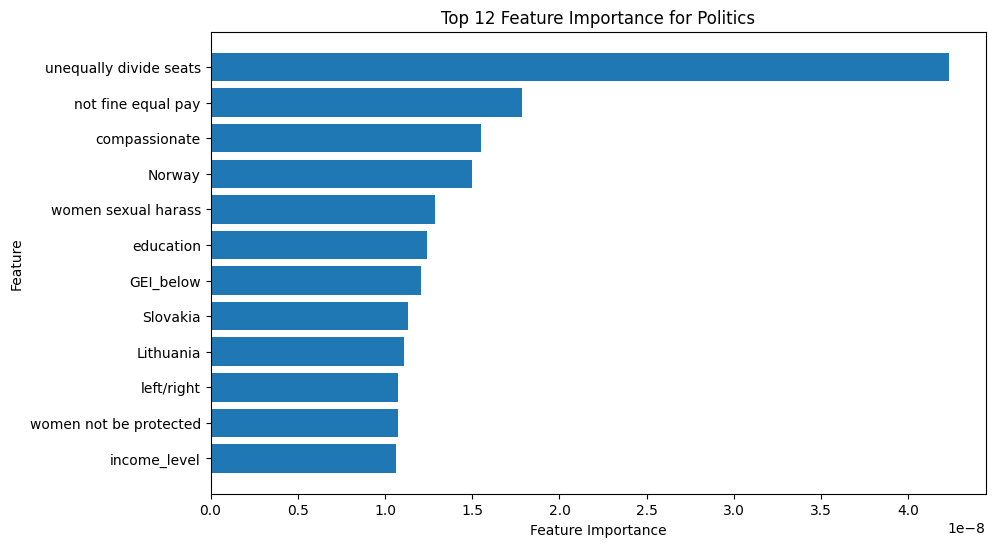

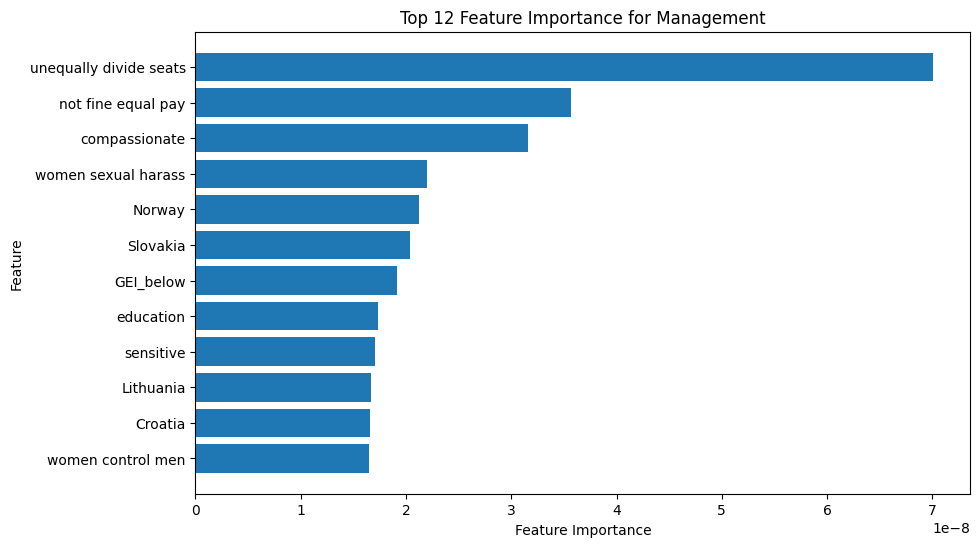

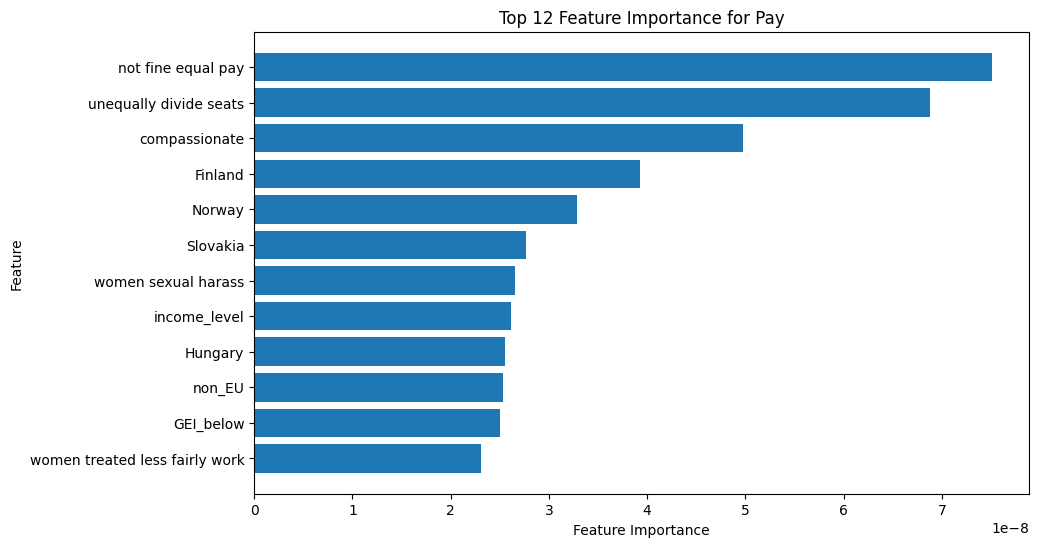

In [185]:
def plot_feature_importance(feature_importance, max_display=12, task=task):
    sorted_idx = np.argsort(feature_importance)[::-1]
    sorted_fi = feature_importance[sorted_idx]
    sorted_features = X_train_or.columns[sorted_idx]

    top_features = sorted_features[:max_display]
    top_fi = sorted_fi[:max_display]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_fi)
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Top {max_display} Feature Importance for {task.capitalize()}")
    plt.show()

plot_feature_importance(feature_importance_wrk, task='work')
plot_feature_importance(feature_importance_pol, task='politics')
plot_feature_importance(feature_importance_mgm, task='management')
plot_feature_importance(feature_importance_pay, task='pay')

## Error analysis

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


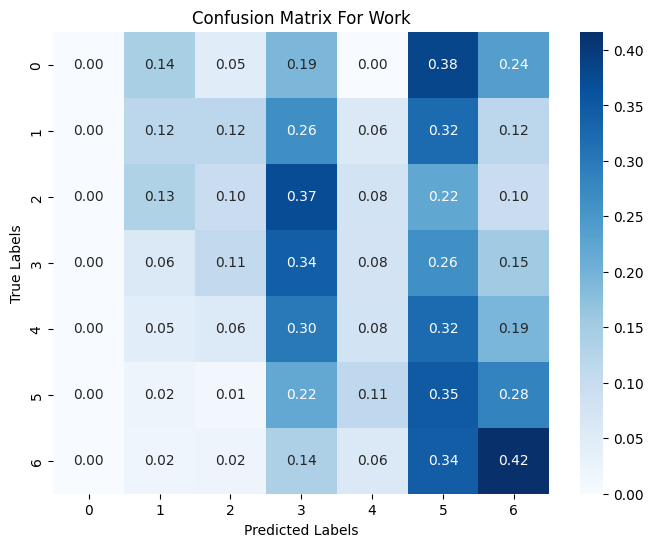

In [ ]:
set_seed()
# confusion matrix
y_pred_wrk = best_model_wrk.predict(X_test_sc) 
y_pred_classes_wrk = np.argmax(y_pred_wrk, axis=1)  

cm_wrk = confusion_matrix(y_test_wrk, y_pred_classes_wrk)
cm_normalized_wrk = cm_wrk.astype('float') / cm_wrk.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized_wrk, annot=True, fmt=".2f", cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7)) 
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Work')
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step


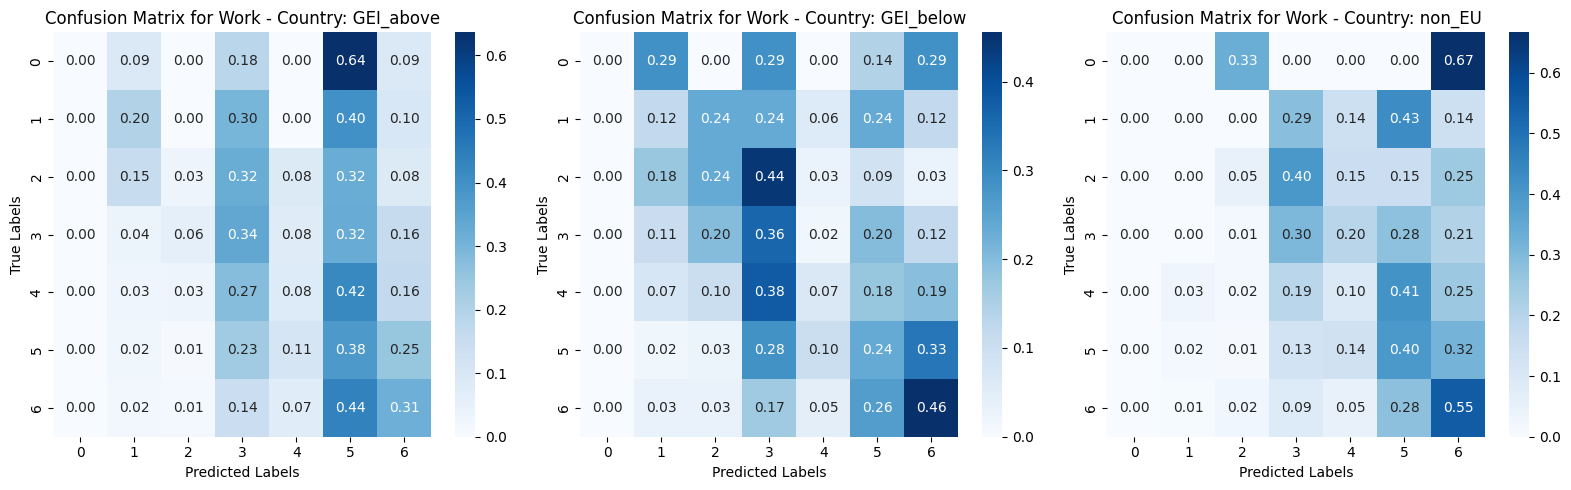

In [216]:
set_seed()

country_column_names = ['GEI_above', 'GEI_below', 'non_EU']
country_indices = [X_train_or.columns.get_loc(col) for col in country_column_names]

def plot_confusion_matrix_for_country(country_name, X_train_sc, X_train_or, y_train, y_test, model, target, ax):

    country_column = f'{country_name}' 

    country_data_mask_train = X_train_or[country_column] == 1  
    country_data_mask_test = X_test_or[country_column] == 1
    
    X_country_train = X_train_sc[country_data_mask_train, :]
    X_country_test = X_test_sc[country_data_mask_test, :]
    
    y_country_train = y_train[country_data_mask_train]
    y_country_test = y_test[country_data_mask_test]
    
    y_pred_country = model.predict(X_country_test)
    y_pred_classes_country = np.argmax(y_pred_country, axis=1)

    cm_country = confusion_matrix(y_country_test, y_pred_classes_country, labels=[0, 1, 2, 3, 4, 5, 6])
    cm_normalized_country = cm_country.astype('float') / cm_country.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized_country, annot=True, fmt=".2f", cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7), ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(f'Confusion Matrix for {target} - Country: {country_name}')



# subplot layout
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

for i, country in enumerate(country_column_names):
    plot_confusion_matrix_for_country(country, X_train_sc, X_train_or, y_train_wrk, y_test_wrk, best_model_wrk, 'Work', axs[i])

plt.tight_layout()
plt.show()


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


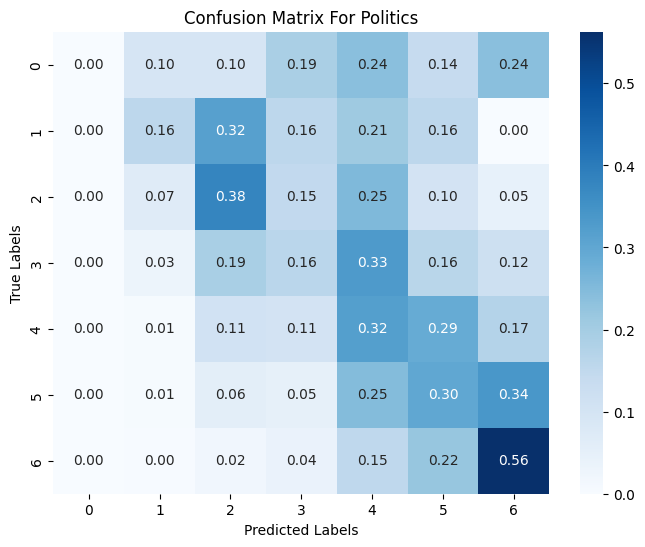

In [70]:
set_seed()
# confusion matrix
y_pred_pol = best_model_pol.predict(X_test_sc)
y_pred_classes_pol = np.argmax(y_pred_pol, axis=1)

cm_pol = confusion_matrix(y_test_pol, y_pred_classes_pol)
cm_normalized_pol = cm_pol.astype('float') / cm_pol.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized_pol, annot=True, fmt=".2f", cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Politics')
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


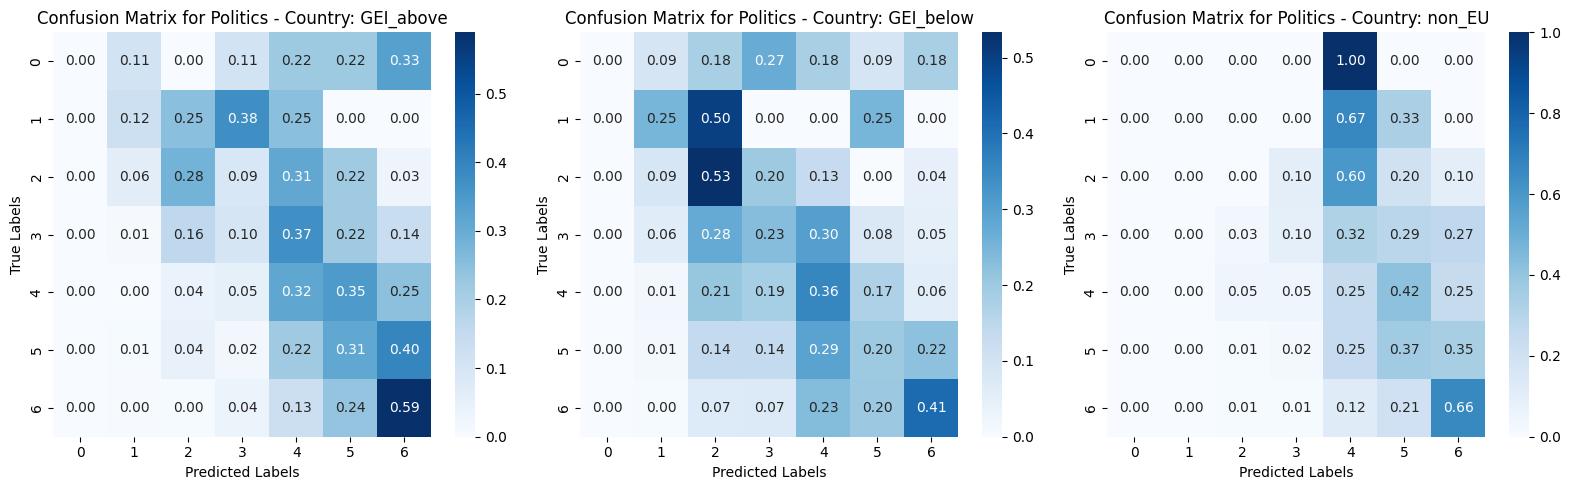

In [211]:
set_seed()
# subplot layout
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

for i, country in enumerate(country_column_names):
    plot_confusion_matrix_for_country(country, X_train_sc, X_train_or, y_train_pol, y_test_pol, best_model_pol, 'Politics', axs[i])
plt.tight_layout()
plt.show()

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


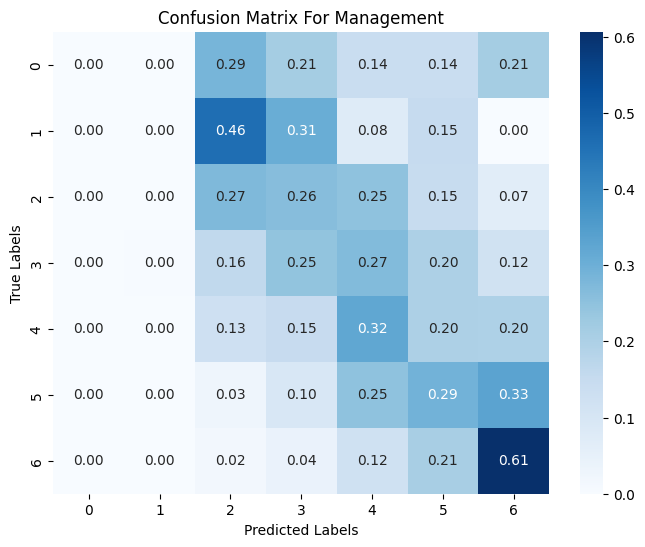

In [72]:
set_seed()
# confusion matrix
y_pred_mgm = best_model_mgm.predict(X_test_sc)
y_pred_classes_mgm = np.argmax(y_pred_mgm, axis=1)

cm_mgm = confusion_matrix(y_test_mgm, y_pred_classes_mgm)
cm_normalized_mgm = cm_mgm.astype('float') / cm_mgm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized_mgm, annot=True, fmt=".2f", cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Management')
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


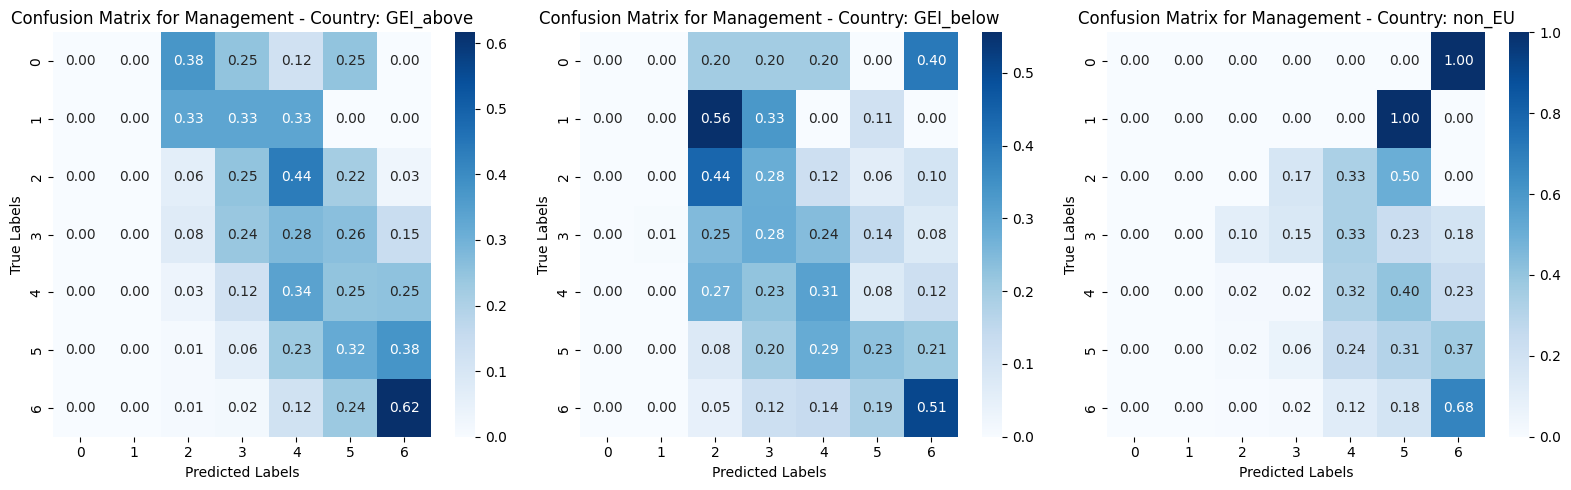

In [215]:
set_seed()
# subplot layout
fig, axs = plt.subplots(1, 3, figsize=(16,5))

for i, country in enumerate(country_column_names):
    plot_confusion_matrix_for_country(country, X_train_sc, X_train_or, y_train_mgm, y_test_mgm, best_model_mgm, 'Management', axs[i])

plt.tight_layout()
plt.show()


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


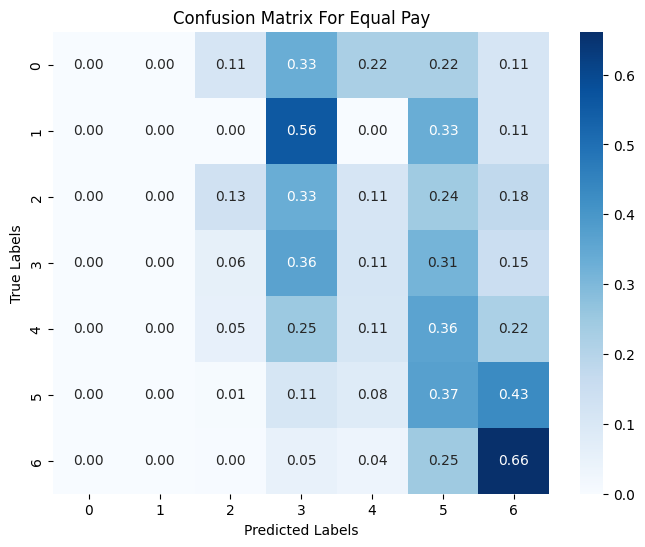

In [74]:
set_seed()
# confusion matrix
y_pred_pay = best_model_pay.predict(X_test_sc)
y_pred_classes_pay = np.argmax(y_pred_pay, axis=1)

cm_pay = confusion_matrix(y_test_pay, y_pred_classes_pay)
cm_normalized_pay = cm_pay.astype('float') / cm_pay.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized_pay, annot=True, fmt=".2f", cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For Equal Pay')
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


/var/folders/rs/6q4q8pf944x46t2hzwlscw4h0000gn/T/ipykernel_50884/257820595.py:23: RuntimeWarning: invalid value encountered in divide
  cm_normalized_country = cm_country.astype('float') / cm_country.sum(axis=1)[:, np.newaxis]


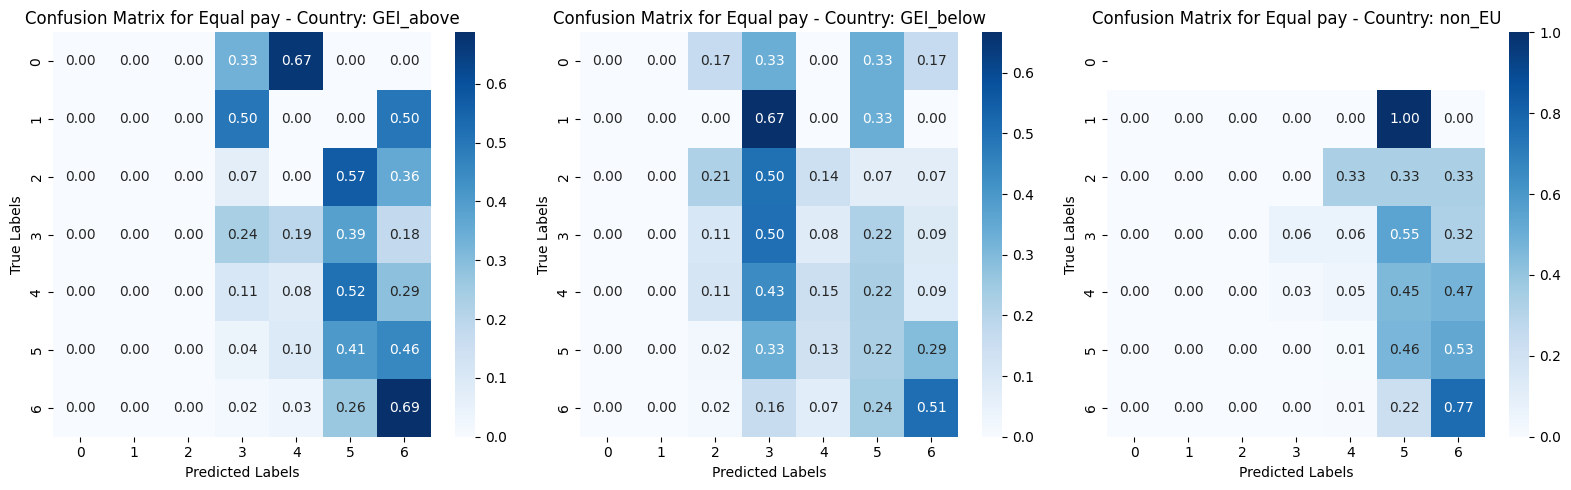

In [217]:
set_seed()
# subplot layout
fig, axs = plt.subplots(1, 3, figsize=(16,5))

for i, country in enumerate(country_column_names):
    plot_confusion_matrix_for_country(country, X_train_sc, X_train_or, y_train_pay, y_test_pay, best_model_pay, 'Equal pay', axs[i])

plt.tight_layout()
plt.show()